In [1]:
from __future__ import print_function
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse
import random
import torchvision.transforms.functional as TF

from torchvision.utils import save_image
from skimage.util import random_noise
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 

In [2]:
root = "./"
def default_loader(path):
    return Image.open(path).convert('RGB')

In [3]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self,root, datatxt, transform=None, target_transform=None,loader=default_loader):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r') 
        imgs = []     
        data = []
        label = []
        for line in fh:                
            line = line.rstrip()       
            data.append(line)
        for line in range(len(data)-1):
            words = data[line].split()  
            imgs.append((words[0])) 
            label.append(int(words[1]))
            
        
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.label = torch.LongTensor(label)
 
    # def __getitem__(self, index):    
    def __getitem__(self, idx):    
        image = Image.open(str(self.imgs[idx]))
        # image = image.convert('RGB')
        image = image.convert('L')
        if self.transform is not None:
            image = self.transform(image)
        label = self.label[idx]
        return image, label
    def __len__(self): 
        return len(self.imgs)

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
train_dataset = MyDataset(root='./',datatxt='train.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
trainNew_dataset = MyDataset(root='./',datatxt='train-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
test_dataset = MyDataset(root='./',datatxt='test.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
testNew_dataset = MyDataset(root='./',datatxt='test-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
origin_dataset = MyDataset(root='./',datatxt='origin.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=1)
trainNew_loader = DataLoader(dataset=trainNew_dataset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False,num_workers=1)
testNew_loader = DataLoader(dataset=testNew_dataset, batch_size=64, shuffle=False,num_workers=1)
origin_loader = DataLoader(dataset=origin_dataset, batch_size=64, shuffle=False,num_workers=1)
print('num_of_trainData:', len(train_dataset))
print('num_of_trainNewData:', len(trainNew_dataset))
print('num_of_testData:', len(test_dataset))
print('num_of_testNewData:', len(testNew_dataset))
print('num_of_originData:', len(origin_dataset))

num_of_trainData: 71432
num_of_trainNewData: 89827
num_of_testData: 8141
num_of_testNewData: 10299
num_of_originData: 8141


label： tensor(0) shape: (1, 19, 19)
<class 'numpy.ndarray'>


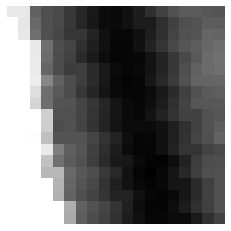

In [6]:
import matplotlib
idx = 11
img = test_dataset[idx][0].numpy()
plt.imshow(img[0], cmap = 'gray')
plt.imsave('test.png', img[0], cmap = 'gray')
# figure, b = plt.subplots()
# figure.set_size_inches(0.19, 0.19)
plt.axis('off') 
print('label：',train_dataset[idx][1], 'shape:', img.shape)
print(type(img[0]))
matplotlib.image.imsave('name.png',img[0])

In [7]:
positive = 0
negative = 0
for idx in range(1,71432):
    if trainNew_dataset[idx][1].item() == 0:
        negative = negative+1
    else:
        positive = positive+1
print('negative: ', negative)
print('positive: ', positive)

KeyboardInterrupt: 

In [8]:
class GaborConvPC(nn.Module):
    def __init__(self, kernel_size, in_channels, num_orientations, num_scales):
        super(GaborConvPC, self).__init__()
        self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, self.bias1, self.weights1, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
        self.sigma2, self.theta2, self.Lambda2, self.psi2, self.gamma2, self.bias2, self.weights2, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
        # self.filter1 = self.whole_filter(in_channels, channel1, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1)
        self.filter_cos = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, True)
        self.filter_sin = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, False)
    
            
        
        self.fc1 = nn.Linear(1*1*48, 24)
        self.fc2 = nn.Linear(24, 2)



    def forward(self, x):
        x_cos = F.conv2d(x, self.filter_cos, bias=self.bias1)
        x_sin = F.conv2d(x, self.filter_sin, bias=self.bias2)
        x_comb = torch.cat((x_cos, x_sin), 2)
#         print("ken",len(x))
#         print("x_comb size", x_comb.size())
#         x_comb = F.max_pool2d(x_comb, 2, 2)
#         x_comb = F.relu(self.conv(x_comb))
#         x_comb = F.max_pool2d(x_comb, 2, 2)
#         bbb = torch.abs(torch.tensor([-1, -2, 3]))
        x_cos = x_cos.view(len(x), 1, 1, 80)
        x_sin = x_sin.view(len(x), 1, 1, 80)
        weighted_cos = (torch.matmul(x_cos, self.weights1)).view(len(x), 1)
        weighted_sin = (torch.matmul(x_sin, self.weights1)).view(len(x), 1)

        numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
#         print("numerator", numerator.size())
        x_comb_norm = torch.norm(x_comb, dim=2)
        x_comb_norm = x_comb_norm.view(len(x), 1, 80)
#         print("x_comb_norm", x_comb_norm.size())
        denominator = torch.matmul(x_comb_norm, torch.abs(self.weights1))
        denominator = denominator.view(len(x))
#         print("size:", numerator.size(), denominator.size())
        pc = numerator / denominator                
#         x_comb = x_comb.view(-1, 1*1*48)
#         x_comb = F.relu(self.fc1(x_comb))
#         x_comb = self.fc2(x_comb)
        return denominator, pc, torch.sigmoid(self.w * pc + self.b)


    def generate_parameters(self, dim_out, dim_in):
        sigma = nn.Parameter(torch.randn(1, 1))
        theta = nn.Parameter(torch.randn(1, 1))
        Lambda = nn.Parameter(torch.randn(1, 1))
        psi = nn.Parameter(torch.randn(1, 1))
        gamma = nn.Parameter(torch.randn(1, 1))
        bias = nn.Parameter(torch.randn(dim_out))
#         bias2 = nn.Parameter(torch.randn(dim_out))
        weights = nn.Parameter(torch.randn(1, 80, 1))
        w = nn.Parameter(torch.randn(1, 1))
        b = nn.Parameter(torch.randn(1, 1))
        return sigma, theta, Lambda, psi, gamma, bias, weights, w, b


    def whole_filter(self, in_channels, num_orientations, num_scales, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(num_orientations*num_scales, in_channels, kernel_size, kernel_size) # \text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW
        for i in range(num_orientations):
            for j in range(num_scales):
                result[i*num_scales + j] = self.one_filter(in_channels, kernel_size, sigma[0]*(2.1**j), theta[0]+i*2*np.pi/num_orientations, Lambda[0], psi[0], gamma[0], cos)
        return nn.Parameter(result)


    def one_filter(self, in_channels, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(in_channels, kernel_size, kernel_size)
        for i in range(in_channels):
            result[i] = self.gabor_fn(sigma, theta, Lambda, psi, gamma, kernel_size, cos)
        return nn.Parameter(result)


    def gabor_fn(self, sigma, theta, Lambda, psi, gamma, kernel_size, cos):
        sigma_x = sigma
        # sigma_y = float(sigma) / gamma
        sigma_y = sigma / gamma

        # Bounding box
        half_size = (kernel_size - 1) // 2
        ymin, xmin = -half_size, -half_size
        ymax, xmax = half_size, half_size
        (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
        y = torch.FloatTensor(y)
        x = torch.FloatTensor(x)

        # Rotation
        x_theta = x * torch.cos(theta) + y * torch.sin(theta)
        y_theta = -x * torch.sin(theta) + y * torch.cos(theta)

        if cos:
            gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * torch.cos(2 * np.pi / Lambda * x_theta + psi)
        else:
            gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * torch.sin(2 * np.pi / Lambda * x_theta + psi)
        return gb

<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([80])
<class 'torch.Tensor'> torch.Size([1, 80, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([80])
<class 'torch.Tensor'> torch.Size([1, 80, 1])
<class 'torch.Tensor'> torch.Size([80, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([80, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([24, 48])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([2, 24])
<class 'torch.Tensor'> torch.Size([2])
Train Epoch: 1 [0/71432 (0%)]	Loss: 48.537678
Train Epoc

[[ 0.11507579  0.13614501 -0.1786866  -0.08950543  0.25475627  0.02088428
  -0.29827213  0.08751265  0.31376478 -0.19994007 -0.26686412  0.32078946
   0.18946141 -0.389015   -0.05115841  0.4321802  -0.077722   -0.39204615
   0.22044125]
 [-0.22309013  0.04022361  0.2695209  -0.1367231  -0.26322404  0.25798985
   0.21414776 -0.36676022 -0.10949988  0.44618222 -0.03040415 -0.46293464
   0.19853817  0.42720592 -0.33748057 -0.31099263  0.45248628  0.16949193
  -0.48550028]
 [ 0.19809154 -0.26652247 -0.12850502  0.37256506  0.02353281 -0.43639866
   0.12813678  0.44443172 -0.29854617 -0.38384026  0.4543128   0.2556282
  -0.5584336  -0.07038751  0.6002935  -0.12132642 -0.54868513  0.30571795
   0.43848664]
 [ 0.061781    0.3786523  -0.19592902 -0.36452046  0.36335957  0.2905144
  -0.5125176  -0.1472948   0.6092241  -0.05467099 -0.6345628   0.27139953
   0.5671874  -0.46579564 -0.4150447   0.60371023  0.21276495 -0.6501305
   0.01206498]
 [-0.36300236 -0.16730008  0.50307554  0.02555562 -0.57

[[ 0.57119924  0.644651   -0.85644966 -0.40379703  0.93369985  0.01575567
  -1.0119874   0.22839624  0.8548594  -0.6022236  -0.7099813   0.83956766
   0.5203216  -0.85468346 -0.06443296  1.059424   -0.13950416 -0.86963534
   0.56105477]
 [-1.0602438   0.10879579  0.9531586  -0.51015323 -0.8713842   0.66635174
   0.5032631  -0.9566043  -0.32461795  0.9184133  -0.11438789 -0.955963
   0.4334337   0.891783   -0.6130318  -0.5624685   0.9243068   0.38634825
  -0.94100565]
 [ 0.6314201  -0.85581243 -0.3858674   0.92226464  0.03470504 -1.0463444
   0.23906958  0.83863854 -0.6757843  -0.79077333  0.7804629   0.39683673
  -0.97937834 -0.11391985  1.0045089  -0.19067708 -0.8935635   0.5658645
   0.80821866]
 [ 0.15603371  0.9478005  -0.44560093 -0.79201645  0.7351868   0.5423898
  -0.9464731  -0.30700067  0.9074975  -0.19941539 -1.0879085   0.3179562
   0.7477964  -0.751813   -0.659275    0.84622324  0.2990053  -0.97839165
   0.04991941]
 [-0.8386868  -0.34619895  1.0014664   0.07310805 -0.97515

[[ 1.14389189e-01  1.37291223e-01  1.24887586e-01  1.21397264e-01
   9.53922346e-02  7.53480196e-02  9.43957493e-02  7.37080276e-02
   5.78271709e-02  5.19161262e-02  7.43096173e-02  9.39452127e-02
   1.03979044e-01  1.02646649e-01  7.76414424e-02  8.45589787e-02
   7.16944411e-02  8.12597573e-02  1.06872797e-01]
 [ 8.15676078e-02  1.10793926e-01  1.37486249e-01  7.71604553e-02
   5.94127662e-02  6.98384419e-02  6.45963848e-02  5.58692068e-02
   4.90658581e-02  2.47490592e-02  4.12224755e-02  9.46212411e-02
   1.02580056e-01  9.23227817e-02  7.98913091e-02  7.97780529e-02
   6.66346997e-02  7.37559199e-02  8.68866071e-02]
 [ 8.22333843e-02  1.01940319e-01  1.02451071e-01  6.18186668e-02
   7.38367438e-02  4.67052087e-02  6.71678931e-02  4.43249010e-02
   9.79222171e-03  3.08553614e-02  6.80599660e-02  7.06881583e-02
   8.35032836e-02  7.88979828e-02  5.80237582e-02  5.93490042e-02
   6.71391636e-02  7.03785121e-02  8.89165252e-02]
 [ 9.55746844e-02  9.91788656e-02  1.07469000e-01  8.33

[[ 0.91652304  0.6864543   0.28078115 -0.19931109 -0.6228316  -0.8774677
  -0.8940862  -0.6596344  -0.23841377  0.26136625  0.7040814   0.97378737
   0.9973051   0.76776874  0.34718117 -0.1550199  -0.60110396 -0.8751269
  -0.9050924 ]
 [ 0.8507519   0.5347966   0.08040406 -0.390113   -0.7564392  -0.91815346
  -0.82556796 -0.5013277  -0.03037531  0.46473306  0.8484275   1.0180788
   0.9307672   0.60882086  0.13569176 -0.36034077 -0.7472402  -0.9230776
  -0.84325314]
 [ 0.7435036   0.35618168 -0.12202746 -0.5647078  -0.8574346  -0.9116109
  -0.7163829  -0.31497732  0.18516186  0.64815176  0.95166314  1.0180637
   0.8230984   0.4214524  -0.07911747 -0.5464541  -0.85544485 -0.9251939
  -0.73953766]
 [ 0.6003906   0.15983504 -0.32139102 -0.71483475 -0.9143205  -0.86169624
  -0.5682235  -0.10985228  0.39212018  0.80641943  1.0176505   0.96948916
   0.6781165   0.21785559 -0.28728    -0.70320576 -0.91819566 -0.8785156
  -0.5975041 ]
 [ 0.43048814 -0.04324472 -0.5040578  -0.82794166 -0.9255618

[[ 0.97865397  0.71853054  0.2746524  -0.2375976  -0.6793925  -0.9382492
  -0.9473997  -0.69766563 -0.262025    0.24853997  0.69675004  0.9674302
   0.98876184  0.7546924   0.32784948 -0.18268295 -0.63777006 -0.92195976
  -0.9598473 ]
 [ 0.8997666   0.55010957  0.06018154 -0.43422374 -0.81054205 -0.9693182
  -0.86496043 -0.525162   -0.04123203  0.46146917  0.8472629   1.01541
   0.9251946   0.59821105  0.11921911 -0.3844558  -0.7802896  -0.964686
  -0.89053017]
 [ 0.77621263  0.3542641  -0.15390371 -0.61279005 -0.9082821  -0.95251364
  -0.7424856  -0.32647166  0.18481335  0.6521236   0.95503724  1.0187979
   0.8205292   0.41455844 -0.09147279 -0.5658638  -0.8834396  -0.9614605
  -0.7788188 ]
 [ 0.6158654   0.14279325 -0.36254323 -0.76460403 -0.95909417 -0.8927539
  -0.5827693  -0.11109183  0.39938372  0.816307    1.0259186   0.9739697
   0.68009865  0.21577185 -0.29500332 -0.7180553  -0.9414469  -0.9091865
  -0.6294042 ]
 [ 0.42897677 -0.07311751 -0.5506319  -0.8761327  -0.9629216  -0.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[-9.02368873e-03  8.16086587e-03  1.49395540e-02  1.93696730e-02
   3.39522166e-03  1.37522409e-03  2.09013596e-02  1.76871233e-02
   1.19124688e-02  1.51683635e-03  3.20866480e-02  3.78553309e-02
   4.61756065e-02  5.27885668e-02  3.70573699e-02  3.23123559e-02
   1.64367575e-02  2.04323009e-02  1.50268618e-02]
 [-2.86159217e-02 -1.36374659e-03  2.51432732e-02 -2.75788456e-02
  -4.13762927e-02 -3.19436938e-02 -4.95810583e-02  8.27871612e-04
  -4.91314940e-02 -5.25793210e-02 -2.68799402e-02 -1.99699937e-03
   7.89544452e-03  1.53711988e-02  2.27369890e-02  1.56266522e-02
   1.72247831e-02  1.95483565e-02  8.94752890e-03]
 [-7.48334127e-03  6.66050659e-03  2.51471857e-03 -3.07027847e-02
  -1.71497166e-02 -7.46991262e-02 -2.25873608e-02 -6.22112416e-02
  -1.43294096e-01 -5.70689999e-02 -5.75657375e-02 -6.75106049e-02
  -5.58820628e-02 -2.73704100e-02 -2.43625008e-02 -2.32182797e-02
  -1.33356743e-03  1.33665167e-02  9.78895929e-03]
 [ 7.24504422e-03 -6.72909105e-03  3.31884366e-03 -1.59

[[ 0.44759053 -0.924901    0.76424766  0.05209702 -0.7569677   0.95613563
  -0.42834052 -0.3209483   0.962741   -0.7978938   0.2514562   0.787745
  -0.8252344   0.72848475  0.30028382 -0.7727092   0.8557375  -0.2953184
  -0.5131024 ]
 [-0.9598516   0.32391688  0.57154185 -1.0135248   0.6700709  -0.02169549
  -0.8334637   0.9323916  -0.49202794 -0.4233443   0.9461879  -0.73633856
   0.23454666  0.7731086  -0.8439136   0.64864737  0.24842335 -0.82444954
   0.8311941 ]
 [-0.21749394  0.8705323  -0.89998424  0.2396992   0.46732497 -1.1034114
   0.64744073 -0.07036906 -0.91941077  0.88340265 -0.4583112  -0.40025502
   0.96555173 -0.73732656  0.18742198  0.7103236  -0.9021631   0.57383716
   0.21953072]
 [ 0.96152705 -0.5800601  -0.18784751  0.82314855 -0.990798    0.18084972
   0.38884473 -1.1452831   0.57287896 -0.12309509 -0.9395177   0.9172594
  -0.45103285 -0.39633897  0.97050416 -0.7576291   0.11339495  0.6533094
  -0.90653485]
 [-0.12073916 -0.64763904  0.94786453 -0.6581674  -0.33052

[[ 0.51563513 -0.9751078   0.7688893   0.0239298  -0.76933426  0.9862789
  -0.4752121  -0.35989422  0.9499207  -0.8495716   0.14743276  0.6717972
  -0.9949428   0.61790085  0.21702556 -0.88175744  0.9258246  -0.29397744
  -0.5364321 ]
 [-0.92593884  0.3352929   0.52749497 -0.98303854  0.7529318   0.02826797
  -0.7841526   0.9776052  -0.4741408  -0.38036555  0.948255   -0.84572405
   0.13044111  0.6771997  -0.9964334   0.60465467  0.22666253 -0.8890158
   0.9222216 ]
 [-0.18597308  0.8881328  -0.9218674   0.3176532   0.52979356 -0.99350816
   0.7380577   0.03234928 -0.8022855   0.96701825 -0.46674767 -0.3958764
   0.9492833  -0.8422972   0.11585885  0.6841144  -0.99768156  0.59537125
   0.24012122]
 [ 1.0095983  -0.60813653 -0.20013958  0.8872609  -0.9246327   0.29915854
   0.53005016 -1.0023484   0.72116554  0.03615455 -0.81481785  0.9604829
  -0.4604965  -0.4089271   0.9515894  -0.8364714   0.10307083  0.69418776
  -0.99399555]
 [-0.12560317 -0.66431147  1.0053325  -0.60412216 -0.2202

[[-0.5583437  -0.52484494 -0.46089822 -0.37189147 -0.26371634 -0.14859632
  -0.0352965   0.07080041  0.1599799   0.22702676  0.26905352  0.28797653
   0.28509644  0.26468706  0.2323129   0.19023594  0.14685456  0.10432374
   0.06379722]
 [-0.5947007  -0.6348184  -0.63973075 -0.6030744  -0.5355931  -0.44175768
  -0.32775757 -0.20414366 -0.08092476  0.03253477  0.12765297  0.19904171
   0.2476529   0.27133778  0.27326465  0.2563908   0.22731753  0.1897369
   0.14724892]
 [-0.4524341  -0.56571853 -0.6493632  -0.6961757  -0.7054313  -0.67173386
  -0.6042898  -0.5051661  -0.3839419  -0.25575092 -0.1279512  -0.00908891
   0.09128754  0.16911916  0.22154818  0.24924733  0.25447303  0.241302
   0.21468706]
 [-0.14961298 -0.3079646  -0.45766315 -0.5845644  -0.68175125 -0.73852926
  -0.75199544 -0.7225382  -0.65381634 -0.5525105  -0.43123752 -0.29985106
  -0.16787085 -0.04600039  0.05720907  0.13634315  0.19133581  0.2211403
   0.2276754 ]
 [ 0.22722848  0.07408935 -0.0969746  -0.27160233 -0.437

[[-8.10049355e-01 -7.52511859e-01 -6.51867509e-01 -5.13306797e-01
  -3.45366359e-01 -1.50474325e-01  6.24373928e-02  2.76342481e-01
   4.86220956e-01  6.79023743e-01  8.47392023e-01  9.82279718e-01
   1.07554233e+00  1.12190080e+00  1.12160039e+00  1.07426000e+00
   9.79963005e-01  8.50967526e-01  6.92845464e-01]
 [-7.85881102e-01 -8.40322077e-01 -8.46599400e-01 -8.14237237e-01
  -7.31823564e-01 -6.06030166e-01 -4.43555713e-01 -2.53958553e-01
  -4.44153063e-02  1.72429472e-01  3.90103638e-01  5.95548868e-01
   7.74773896e-01  9.21429098e-01  1.02879763e+00  1.09205008e+00
   1.10978889e+00  1.08316660e+00  1.01658881e+00]
 [-5.08624017e-01 -6.63825095e-01 -7.81792641e-01 -8.61816764e-01
  -8.90158534e-01 -8.71873438e-01 -8.01168740e-01 -6.87673450e-01
  -5.36587298e-01 -3.48424137e-01 -1.36417732e-01  8.13861936e-02
   3.00410658e-01  5.08543193e-01  6.93932712e-01  8.52295876e-01
   9.76106763e-01  1.06189024e+00  1.10551417e+00]
 [-5.72584122e-02 -2.76444882e-01 -4.75927770e-01 -6.50

[[ 4.85130548e-02  7.90437534e-02  7.35670328e-02  8.27931762e-02
   5.27622700e-02  2.99855862e-02  5.91429919e-02  3.94486412e-02
   2.32964326e-02  3.81106399e-02  9.11653265e-02  1.16175748e-01
   1.30772635e-01  1.24799728e-01  8.62549618e-02  6.27978891e-02
   1.10882735e-02 -1.02982554e-03 -6.58104708e-03]
 [ 3.27747092e-02  7.31599852e-02  1.11056872e-01  2.92634163e-02
   1.41779482e-02  1.71099715e-02 -5.57462405e-03 -2.55539780e-03
  -7.01974146e-04 -1.51253333e-02  2.75847763e-02  9.35992897e-02
   1.02764904e-01  1.02398612e-01  9.49596390e-02  7.39563704e-02
   3.86836082e-02  8.80619325e-03 -4.89442842e-03]
 [ 5.41506335e-02  8.10751021e-02  6.53559566e-02  2.32579689e-02
   2.74653193e-02 -3.73212546e-02 -1.90963931e-02 -5.10983802e-02
  -8.14795271e-02 -3.65269259e-02  2.19147447e-02  1.03356149e-02
   4.99233231e-02  7.57180378e-02  6.51238635e-02  6.22733459e-02
   4.26022299e-02  2.67488509e-02  1.24465171e-02]
 [ 8.00085068e-02  7.17044547e-02  6.98717758e-02  3.78

[[-0.61004     0.7859436   0.171823   -0.97099787 -0.01720549  0.7871246
  -0.41229463 -0.80004615  0.61576253  0.5345967  -0.7823558  -0.20313086
   1.0466038   0.07006439 -0.87801915  0.36759186  0.76547474 -0.6722693
  -0.67764986]
 [-0.438599   -0.8983714   0.55918723  0.46525115 -0.99735206 -0.58492684
   0.7321055  -0.04673084 -1.0856608   0.05646818  0.8088969  -0.48621976
  -0.6589401   0.8337669   0.55686873 -0.8626725  -0.16132793  0.9328115
  -0.19571121]
 [ 0.7494797   0.17072152 -1.0243679  -0.10512225  0.72716874 -0.70546985
  -1.0151393   0.41963026  0.27749655 -1.0974905  -0.392167    0.8350852
  -0.09636541 -0.92839855  0.37816274  0.83661115 -0.6241658  -0.6393701
   0.7975529 ]
 [-0.8745949   0.51932436  0.58760285 -0.96175134 -0.630395    0.66145194
  -0.2195003  -1.3063744  -0.08640905  0.55274135 -0.8406709  -0.8707929
   0.66345733  0.34963208 -0.96007216 -0.18198642  0.91989017 -0.23043835
  -0.94617295]
 [ 0.18113683 -1.0234947  -0.00977016  0.7509471  -0.69855

[[-0.56271255  0.8978027   0.2183371  -1.0157067   0.07805634  0.9502802
  -0.43251085 -0.8454452   0.67056096  0.57853746 -0.9132265  -0.3301386
   0.9639895  -0.04781711 -0.99864066  0.3356251   0.85383105 -0.6474282
  -0.6646098 ]
 [-0.31634167 -0.9110627   0.5741308   0.68215036 -0.8345555  -0.43110424
   0.954577    0.09070694 -1.0088652   0.21908692  0.9053605  -0.55714196
  -0.7635436   0.76440644  0.46730053 -0.95452267 -0.17860688  0.9927071
  -0.17022124]
 [ 0.9004134   0.2036686  -1.0155522   0.09545091  0.95191115 -0.429806
  -0.8254329   0.6951825   0.5873579  -0.899704   -0.30412218  0.9791712
  -0.05081578 -0.9921779   0.35150585  0.8512435  -0.65211403 -0.6484651
   0.8550173 ]
 [-0.911959    0.5806825   0.6671258  -0.8440313  -0.41734847  0.965406
   0.09083883 -0.993108    0.2453187   0.9205162  -0.54593366 -0.7403666
   0.7837043   0.4663032  -0.9517201  -0.15931787  1.0003985  -0.17399997
  -0.94452685]
 [ 0.18687186 -1.0203506   0.10206361  0.9485829  -0.44125324 -

[[ 0.09396388  0.1695812   0.22989811  0.23626873  0.15822127 -0.0118471
  -0.2422682  -0.46139252 -0.5842398  -0.5433053  -0.32382235  0.02427791
   0.39615577  0.6699449   0.756689    0.6325485   0.3523519   0.01661949
  -0.26417422]
 [ 0.1327321   0.20989239  0.25423187  0.22778523  0.10230484 -0.11198509
  -0.36137027 -0.56209755 -0.6258447  -0.49996078 -0.19953719  0.19398364
   0.5589768   0.7728521   0.76771444  0.55617183  0.21985187 -0.12350852
  -0.36881918]
 [ 0.17410205  0.24634038  0.26622608  0.19563235  0.01917531 -0.22961721
  -0.4833313  -0.64319354 -0.62948793 -0.41402543 -0.04265011  0.3768841
   0.7067311   0.83854085  0.73485917  0.44271073  0.07020059 -0.2588374
  -0.45158046]
 [ 0.21656348  0.27481067  0.2586831   0.13756612 -0.0852027  -0.35882083
  -0.5944646  -0.6938577  -0.5901463  -0.28453404  0.1424746   0.5568488
   0.82513875  0.8595102   0.6570771   0.29996416 -0.0845411  -0.37694937
  -0.50597   ]
 [ 0.25676236  0.29019353  0.23013346  0.05613047 -0.207

[[ 0.6018397   0.9313874   1.0267253   0.8606726   0.47730324 -0.02373888
  -0.5117235  -0.8561871  -0.9669975  -0.814509   -0.44093505  0.05723193
   0.55029726  0.90799874  1.0356169   0.90091586  0.5407726   0.04879993
  -0.44346225]
 [ 0.7641279   1.0022974   0.98585075  0.7222986   0.27433184 -0.23914643
  -0.68061405 -0.9355004  -0.9359955  -0.6810339  -0.24076892  0.2701816
   0.7198769   0.98872906  1.0056335   0.76881146  0.33926842 -0.16888559
  -0.6205672 ]
 [ 0.8911753   1.0262613   0.9015031   0.5486194   0.05681099 -0.44112387
  -0.8176282  -0.9696651  -0.8587442  -0.5148902  -0.0293752   0.47295803
   0.8579554   1.0253807   0.9318916   0.6026013   0.12470201 -0.37576267
  -0.76475257]
 [ 0.97787195  1.004747    0.7756897   0.3501623  -0.16054158 -0.6221497
  -0.9133278  -0.9566762  -0.7408775  -0.32267112  0.18742968  0.65360105
   0.95656234  1.0167795   0.81613714  0.41058373 -0.0927752  -0.5612719
  -0.8706655 ]
 [ 1.0221229   0.93793005  0.615799    0.13869517 -0.36

[[-4.65683313e-03 -1.00150155e-02 -9.24832560e-03 -1.20689739e-02
  -7.17886817e-03 -2.69795861e-03 -1.93045028e-02 -2.09103874e-03
  -6.30530855e-03 -1.06533375e-02 -1.47459609e-02 -2.06881668e-02
  -2.22743303e-02 -2.31333617e-02 -1.74405947e-02 -1.53520703e-02
  -8.07791576e-03 -6.60575181e-03 -5.92017081e-03]
 [-3.54651175e-03 -1.02067953e-02 -1.66932065e-02 -3.54020786e-03
   6.64790045e-04 -1.00715123e-02  4.76219226e-03  1.07756369e-02
  -2.61097346e-02  1.13448845e-02 -5.08353673e-03 -1.63852889e-02
  -1.73465572e-02 -1.78950112e-02 -1.74226929e-02 -1.48751186e-02
  -1.00234170e-02 -6.44009793e-03 -5.66683942e-03]
 [-8.89449101e-03 -1.25485882e-02 -1.04162823e-02 -2.48932512e-03
  -6.05353341e-03  3.02370917e-03  3.37725468e-02 -5.18484116e-02
   2.99816076e-02  2.42308062e-02 -1.68300662e-02  1.02938758e-03
  -7.43820006e-03 -1.19653875e-02 -1.07577890e-02 -1.11378590e-02
  -9.47461370e-03 -8.79542995e-03 -8.37146956e-03]
 [-1.30222002e-02 -1.09979426e-02 -1.13429176e-02 -5.87

[[-6.10582590e-01 -1.34985730e-01  8.27554166e-01 -9.32673335e-01
   2.91939616e-01  4.52535003e-01 -9.59310412e-01  7.76566744e-01
   5.06280921e-02 -7.03404725e-01  1.04038107e+00 -3.77085239e-01
  -2.41003081e-01  1.00330615e+00 -7.47446001e-01  2.17816904e-01
   6.73801482e-01 -8.55734825e-01  6.98026478e-01]
 [-6.19944990e-01  9.71265256e-01 -5.94681919e-01 -2.13323280e-01
   7.90322185e-01 -9.41414237e-01  3.33643407e-01  5.27690351e-01
  -9.06700373e-01  8.02301526e-01  9.51063409e-02 -6.40750527e-01
   1.08617926e+00 -3.48164290e-01 -2.57688999e-01  9.77767527e-01
  -7.47039497e-01  1.86893061e-01  7.22642243e-01]
 [ 8.28086972e-01 -1.35884404e-01 -6.30800188e-01  9.30827677e-01
  -6.66090727e-01 -2.21418813e-01  8.93212557e-01 -8.78448009e-01
   3.69813055e-01  6.01816893e-01 -8.59408736e-01  8.49298179e-01
   1.62075683e-01 -6.36219859e-01  1.04529059e+00 -3.72582018e-01
  -2.96720713e-01  9.47677970e-01 -6.87404573e-01]
 [ 3.52068275e-01 -8.88017118e-01  8.34355474e-01 -1.87

[[-0.60579365 -0.10802989  0.90411514 -0.89896446  0.37242344  0.5140998
  -0.96022016  0.7798165   0.01573531 -0.7617031   1.0002869  -0.46255103
  -0.32964313  0.9647242  -0.84452015  0.16212884  0.65548295 -1.0072043
   0.6166979 ]
 [-0.6030351   1.0417452  -0.5893039  -0.14957571  0.87856215 -0.9228591
   0.3447682   0.5168416  -0.9782447   0.7543742   0.02267189 -0.7514096
   1.0063943  -0.45487684 -0.3463916   0.96048087 -0.852303    0.12851605
   0.66246533]
 [ 0.90334934 -0.12163126 -0.6067319   1.01901    -0.6140539  -0.18584044
   0.88279307 -0.9295692   0.31365725  0.5190292  -0.97315127  0.7549319
   0.04534596 -0.7630609   0.99321043 -0.45693025 -0.3760364   0.9466619
  -0.84366554]
 [ 0.39637905 -0.8972439   0.90009874 -0.13067396 -0.6388409   1.0056379
  -0.626982   -0.20394425  0.872689   -0.94217324  0.30429864  0.5363567
  -0.98072916  0.7505036   0.05472079 -0.78727907  0.9680129  -0.4689638
  -0.39277777]
 [-0.93893373  0.51936054  0.39391994 -0.9230169   0.8620344 

[[-0.3067751  -0.41411877 -0.49742898 -0.5518115  -0.571016   -0.56098616
  -0.52503616 -0.45846397 -0.37369502 -0.27845693 -0.18444924 -0.09437879
  -0.01679693  0.04798143  0.09822801  0.12730606  0.14531375  0.14780174
   0.13813551]
 [-0.02368838 -0.16617697 -0.3075859  -0.41526902 -0.508986   -0.57445455
  -0.60117155 -0.594608   -0.5526572  -0.4820962  -0.3976125  -0.30453107
  -0.20728567 -0.1151088  -0.03316779  0.03339198  0.08390217  0.11493161
   0.13036247]
 [ 0.30798805  0.17509057  0.02851618 -0.11961916 -0.27131742 -0.39882863
  -0.50815916 -0.57684886 -0.6048738  -0.6001208  -0.56345063 -0.4937129
  -0.4099228  -0.31601116 -0.21673428 -0.12493421 -0.04501854  0.01920912
   0.06682067]
 [ 0.5888901   0.5137685   0.40396383  0.26786187  0.10705467 -0.05904034
  -0.22121647 -0.36315402 -0.47631082 -0.55005884 -0.58594215 -0.58912
  -0.5543424  -0.48789483 -0.40610054 -0.31462273 -0.21903236 -0.1316117
  -0.05919501]
 [ 0.7184791   0.7314543   0.70349586  0.63095397  0.5152

[[-4.9136752e-01 -6.6051632e-01 -7.9878742e-01 -8.9808023e-01
  -9.5365238e-01 -9.6687096e-01 -9.3728018e-01 -8.5913616e-01
  -7.4186838e-01 -5.8841467e-01 -4.0799031e-01 -2.0687824e-01
   5.8051385e-03  2.2098531e-01  4.2752528e-01  6.1407310e-01
   7.7437091e-01  8.9600712e-01  9.7211444e-01]
 [ 5.7815383e-03 -2.0293495e-01 -4.0443820e-01 -5.7822156e-01
  -7.2885507e-01 -8.4753072e-01 -9.2540008e-01 -9.5931309e-01
  -9.4691187e-01 -8.8798064e-01 -7.8929269e-01 -6.5223497e-01
  -4.8004520e-01 -2.8307343e-01 -7.0403017e-02  1.4700404e-01
   3.5906154e-01  5.5406433e-01  7.1940327e-01]
 [ 4.9842772e-01  3.0731827e-01  1.0274189e-01 -1.0254471e-01
  -3.0721667e-01 -4.9486020e-01 -6.6374195e-01 -7.9822963e-01
  -8.9275527e-01 -9.4792831e-01 -9.5805508e-01 -9.1805476e-01
  -8.3385330e-01 -7.0699221e-01 -5.4296649e-01 -3.5253212e-01
  -1.4390862e-01  7.1151361e-02  2.8213921e-01]
 [ 8.6210507e-01  7.4179322e-01  5.8684015e-01  4.0744197e-01
   2.0755668e-01 -2.8274793e-03 -2.1420248e-01 -4.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train Epoch: 10 [0/71432 (0%)]	Loss: 7.239454
Train Epoch: 10 [6400/71432 (9%)]	Loss: 6.708454
Train Epoch: 10 [12800/71432 (18%)]	Loss: 7.277048
Train Epoch: 10 [19200/71432 (27%)]	Loss: 12.437606
Train Epoch: 10 [25600/71432 (36%)]	Loss: 12.615570
Train Epoch: 10 [32000/71432 (45%)]	Loss: 6.401418
Train Epoch: 10 [38400/71432 (54%)]	Loss: 12.906762
Train Epoch: 10 [44800/71432 (63%)]	Loss: 3.378899
Train Epoch: 10 [51200/71432 (72%)]	Loss: 1.795457
Train Epoch: 10 [57600/71432 (81%)]	Loss: 3.874936
Train Epoch: 10 [64000/71432 (90%)]	Loss: 12.791869
Train Epoch: 10 [70400/71432 (98%)]	Loss: 6.246937

Test set: Average loss: 0.1485, Accuracy: 7675/8141 (94%), Positive accuracy: 3730/4091 (91%), Negative accuracy: 3945/4050 (97%)



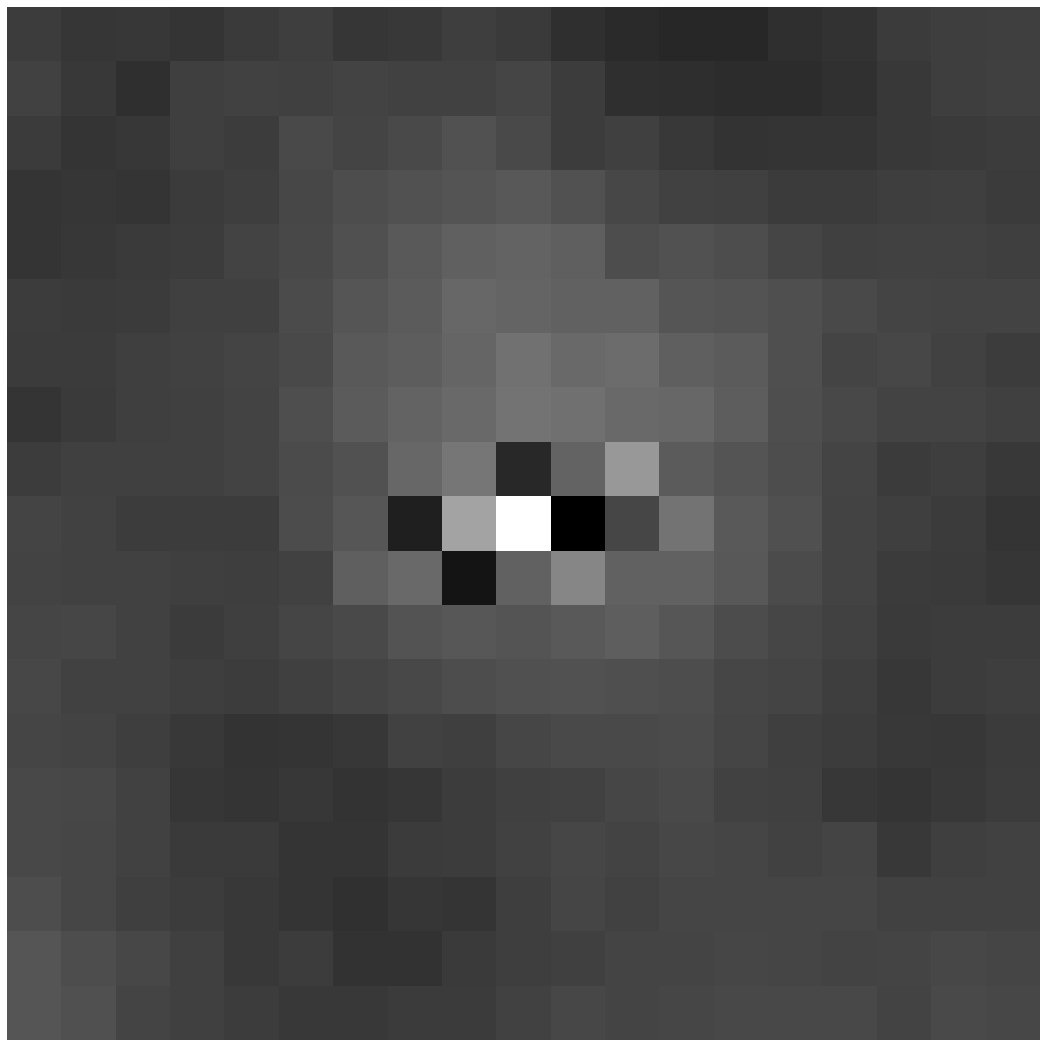

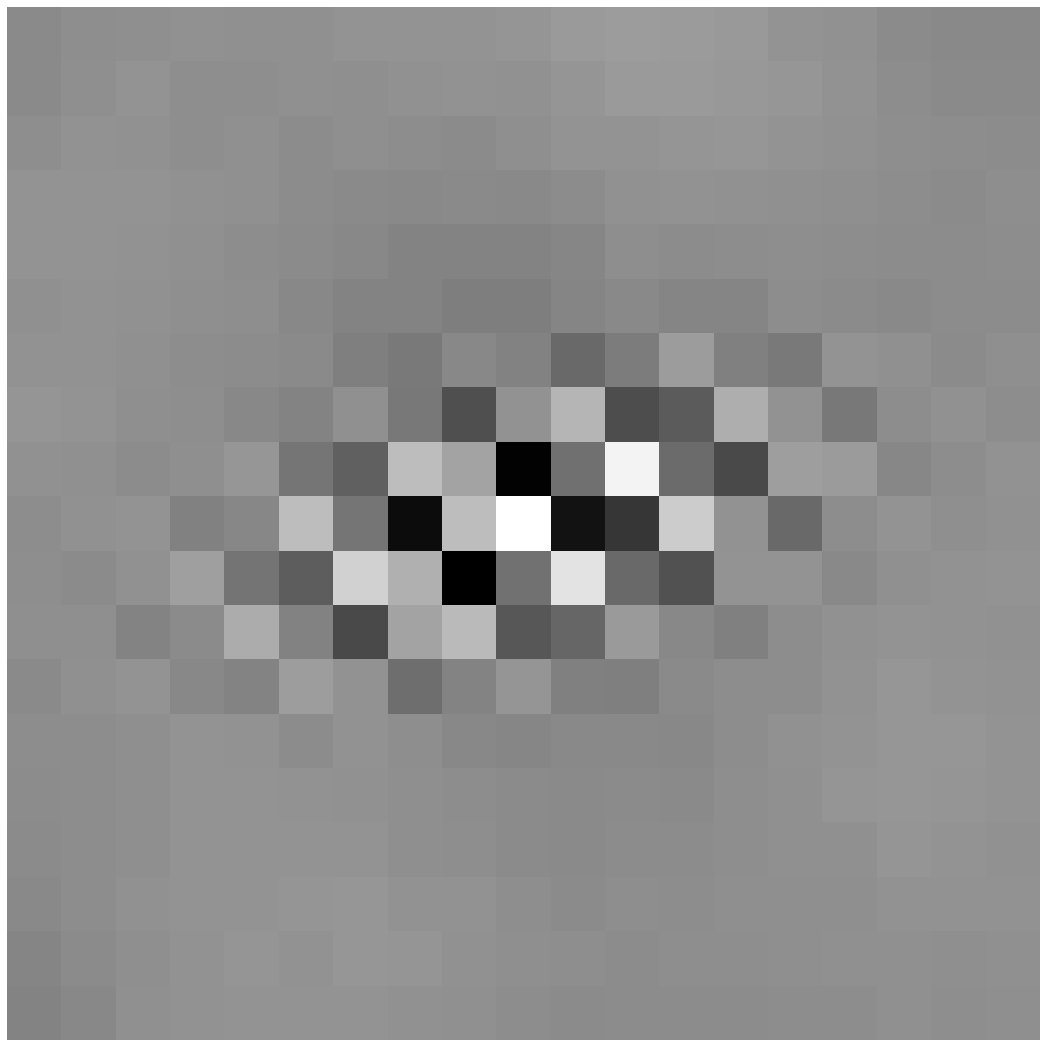

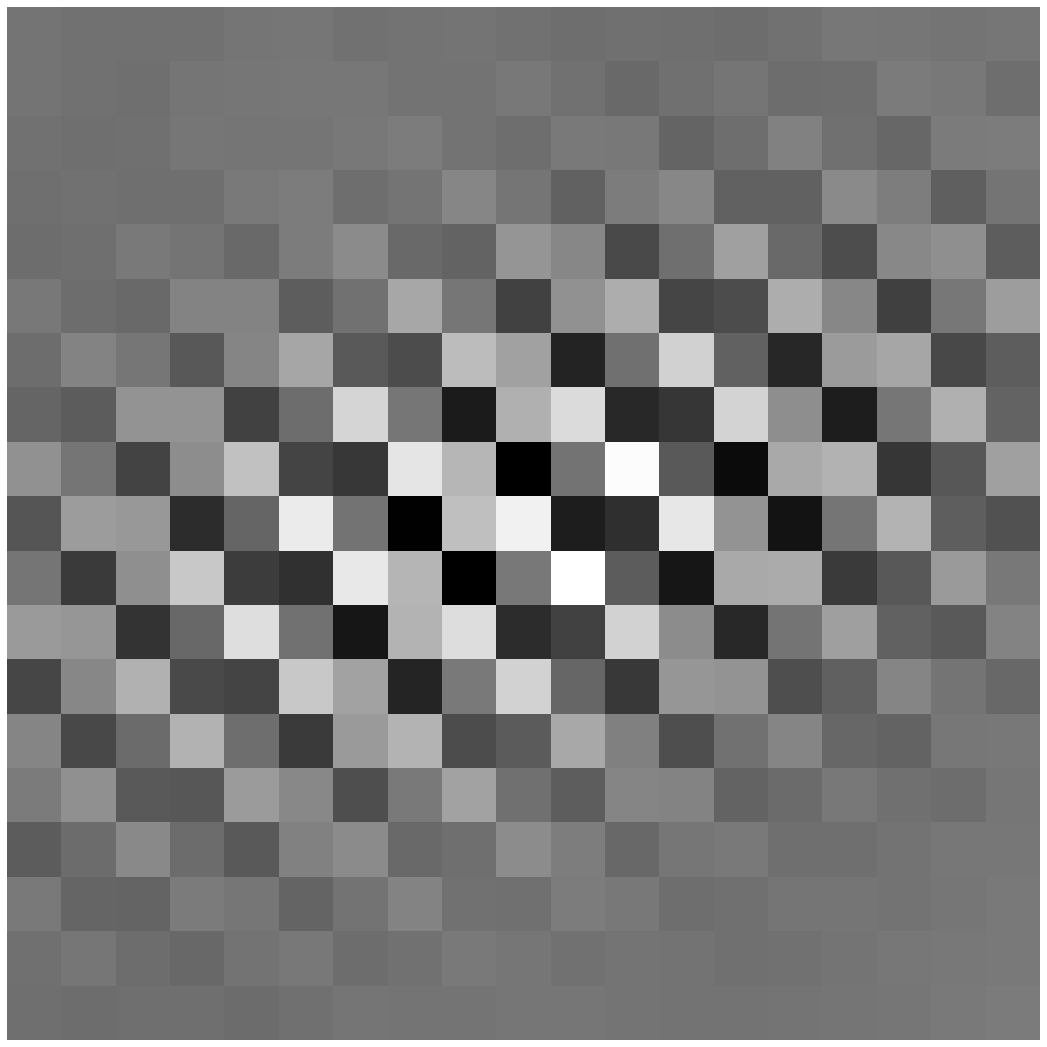

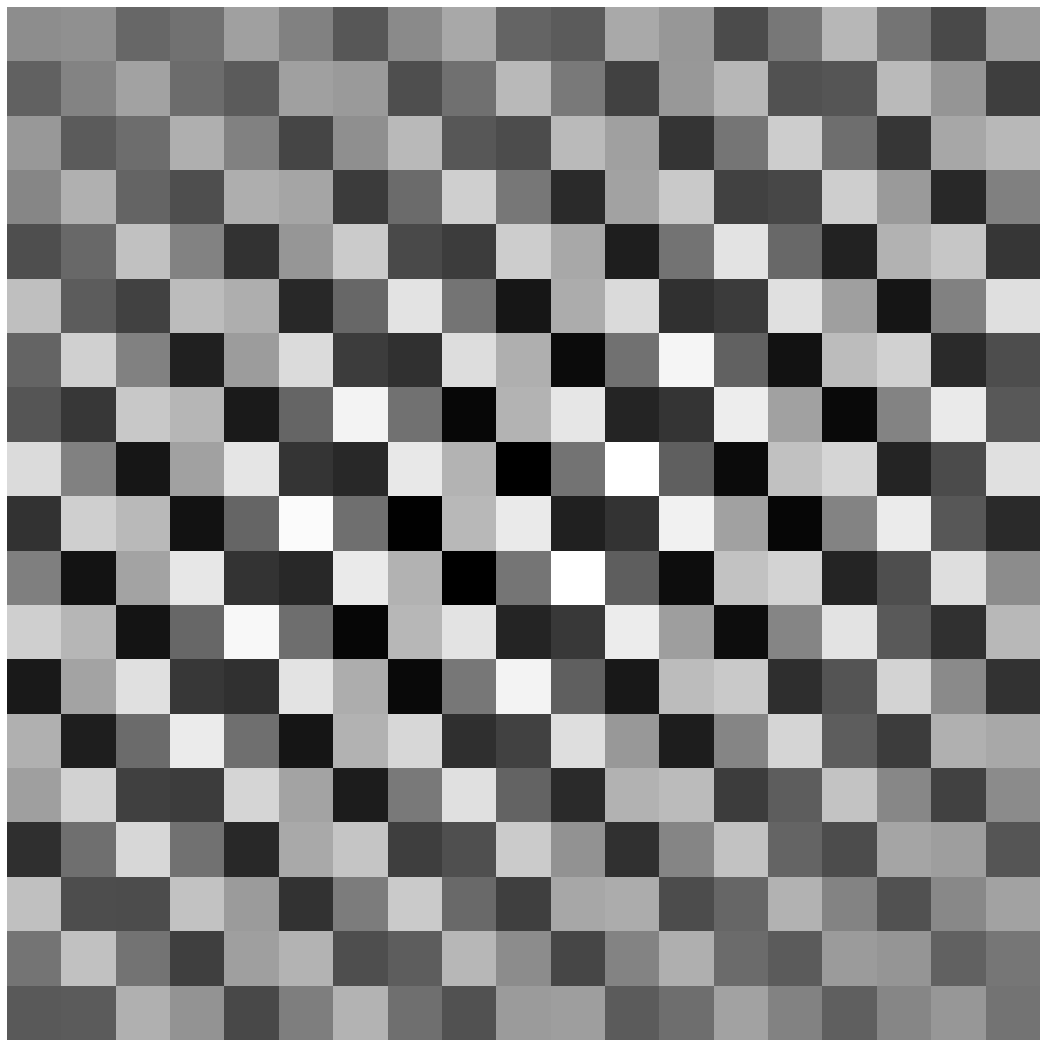

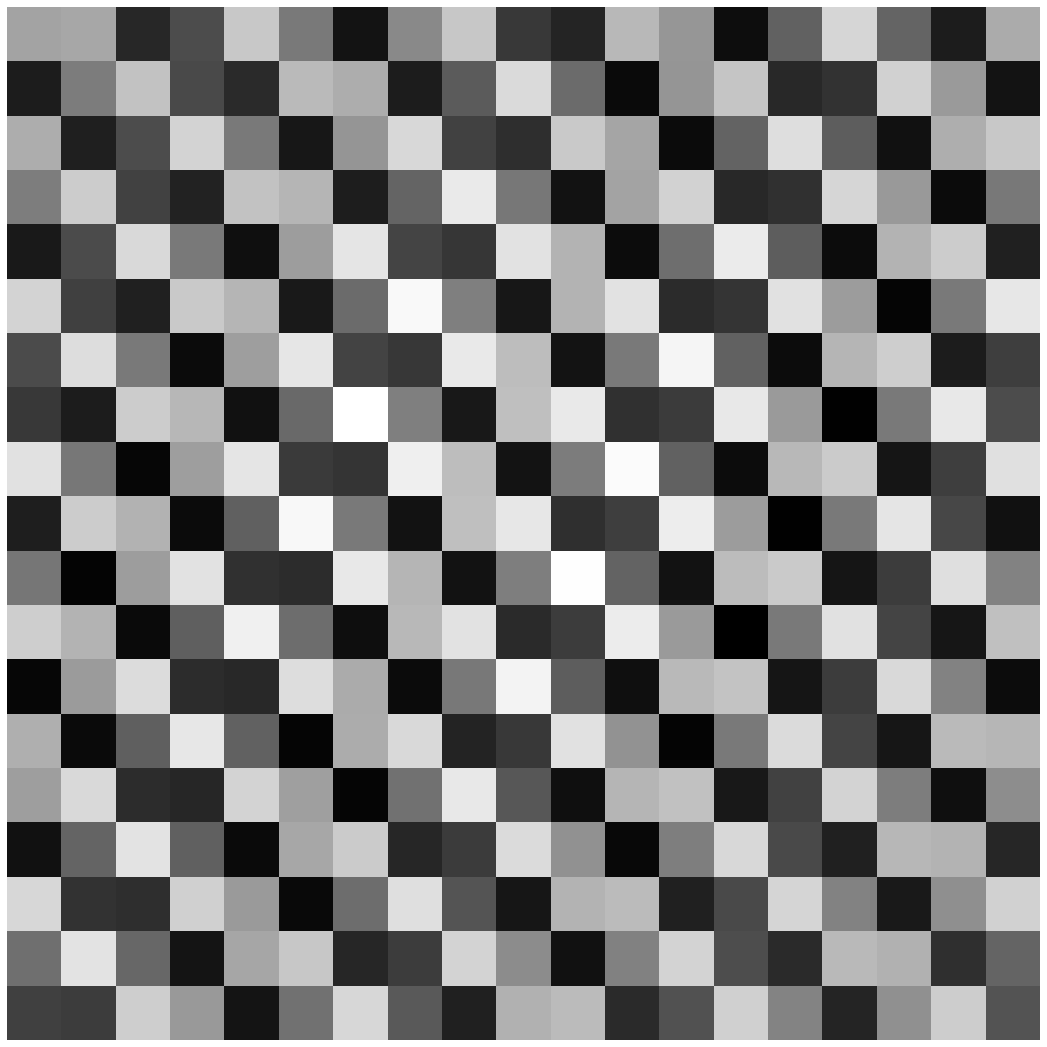

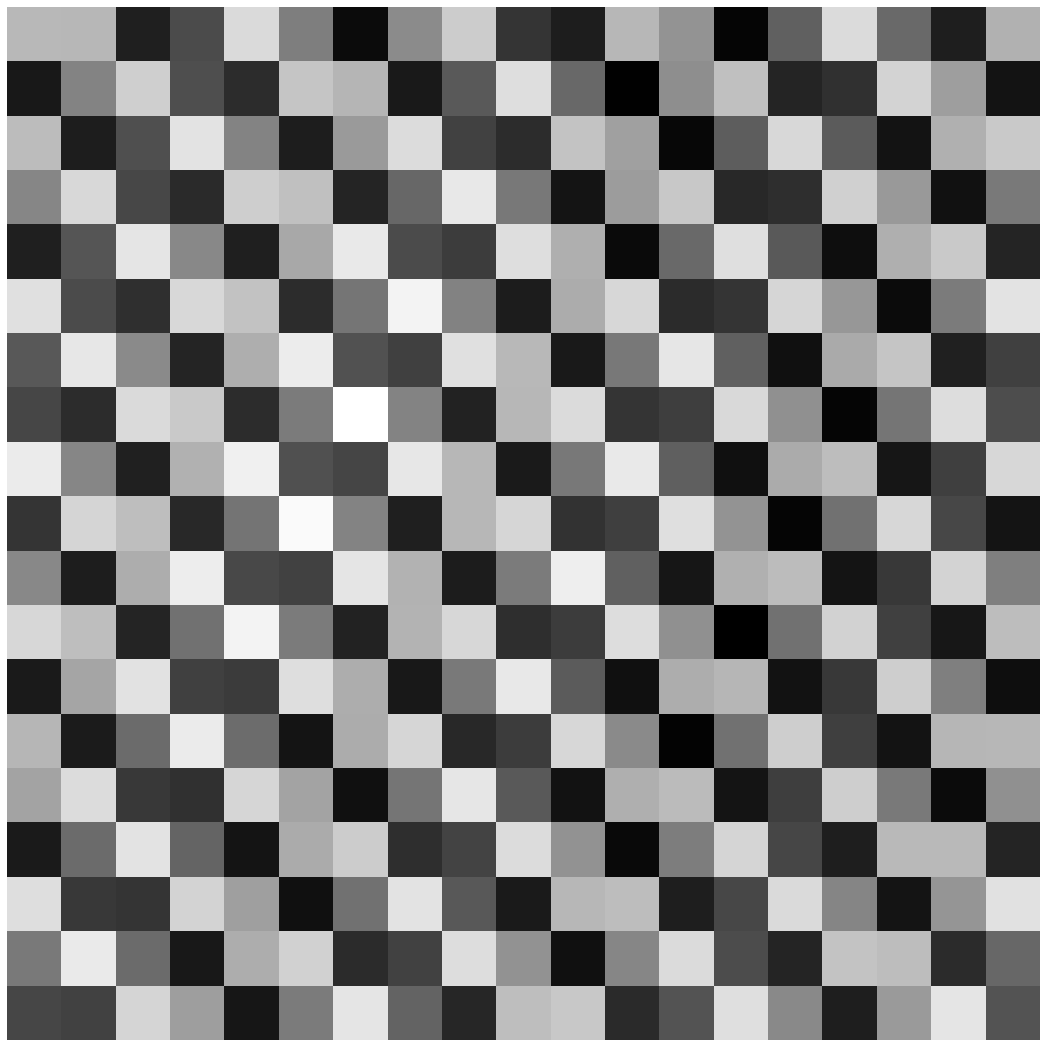

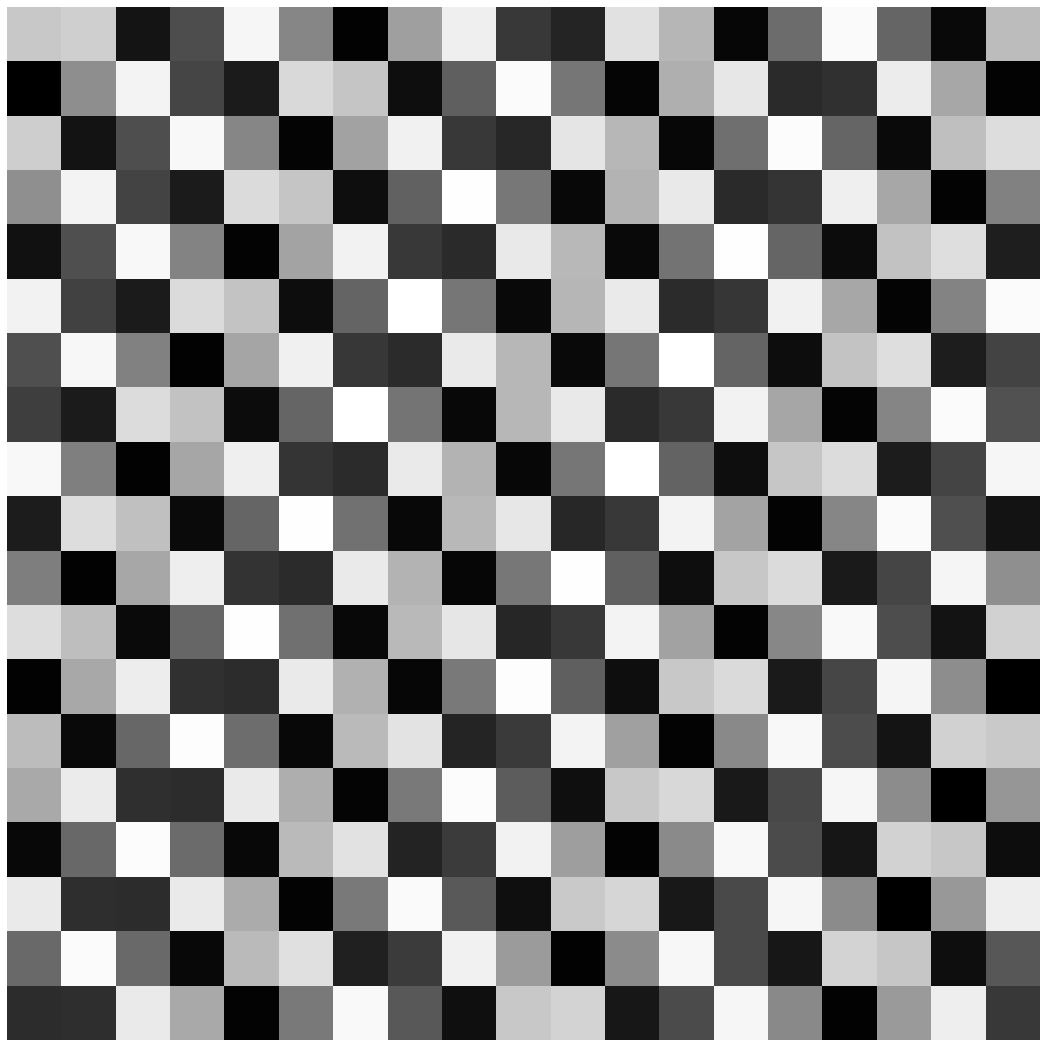

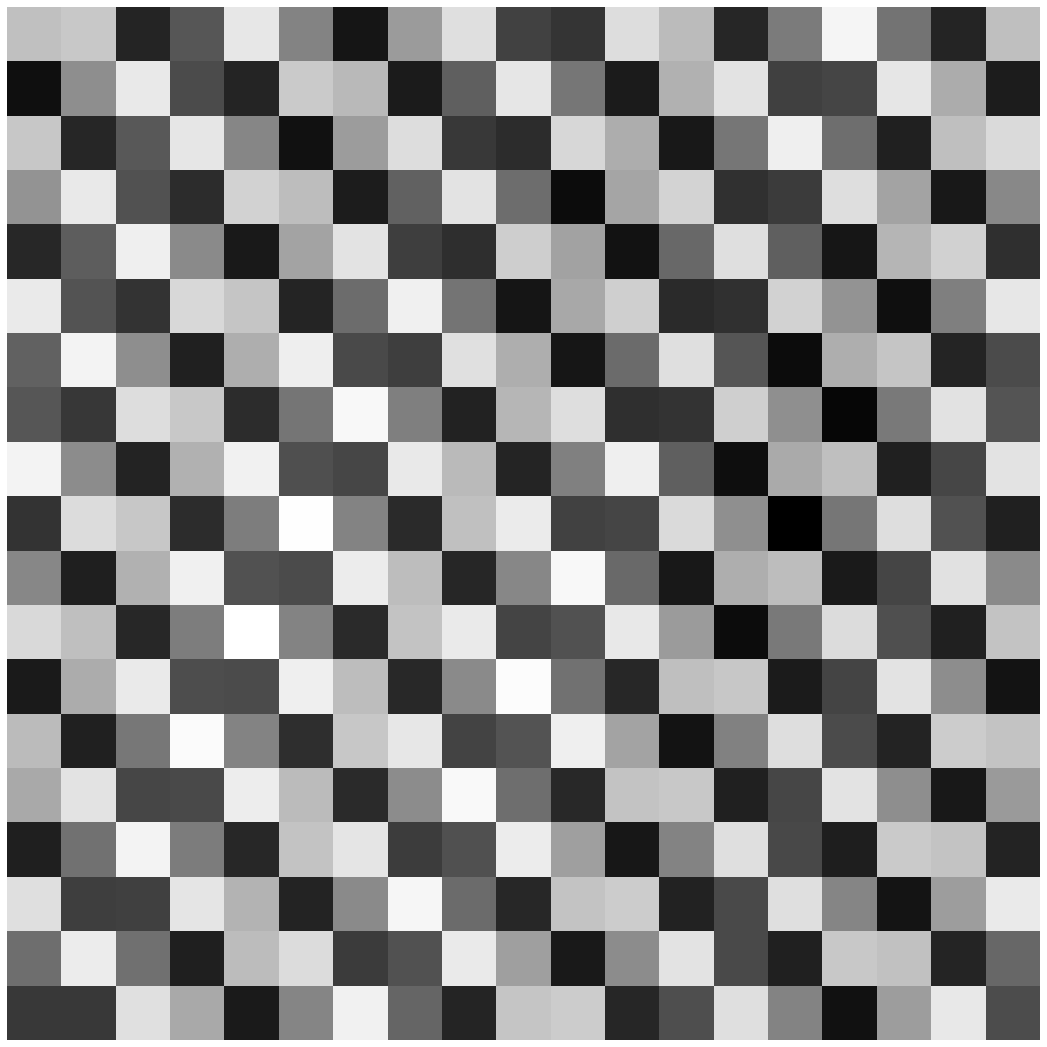

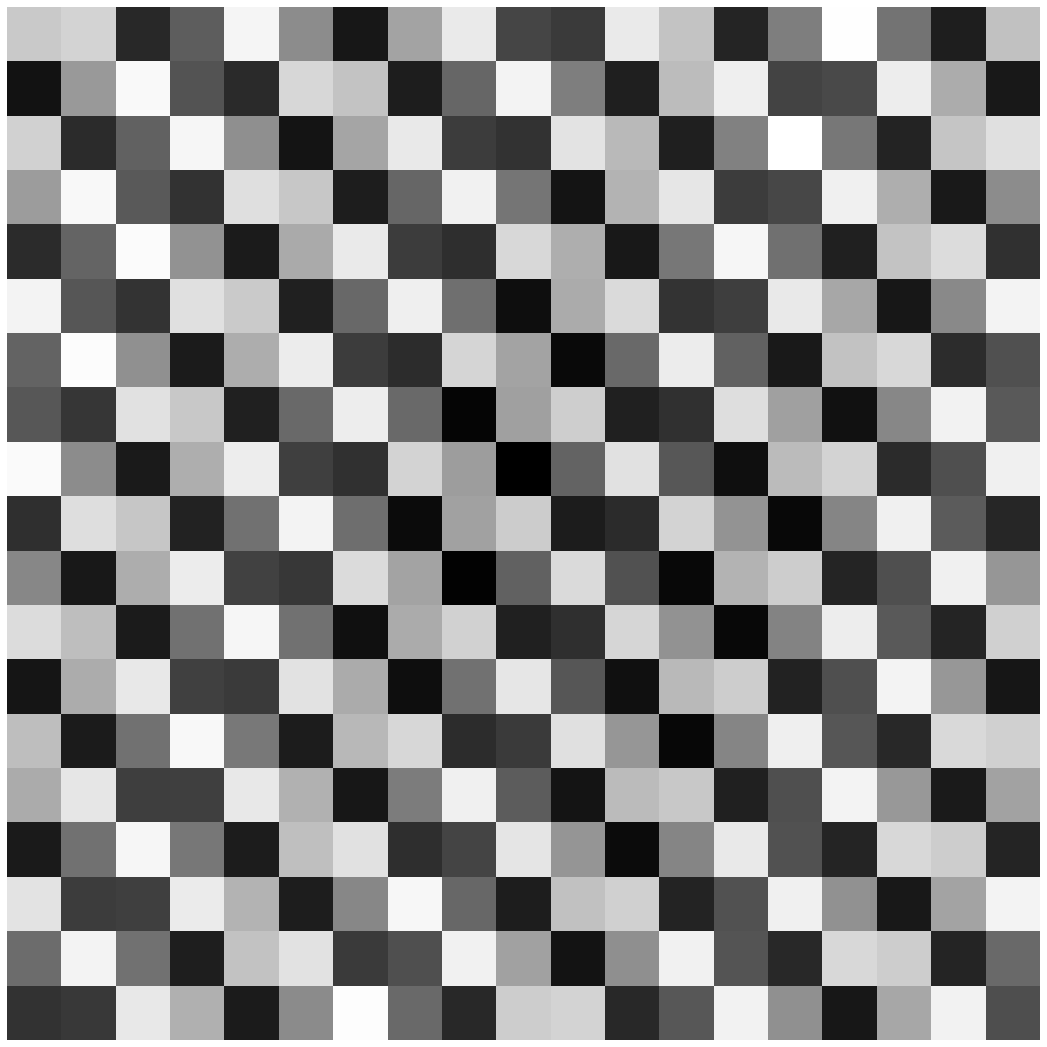

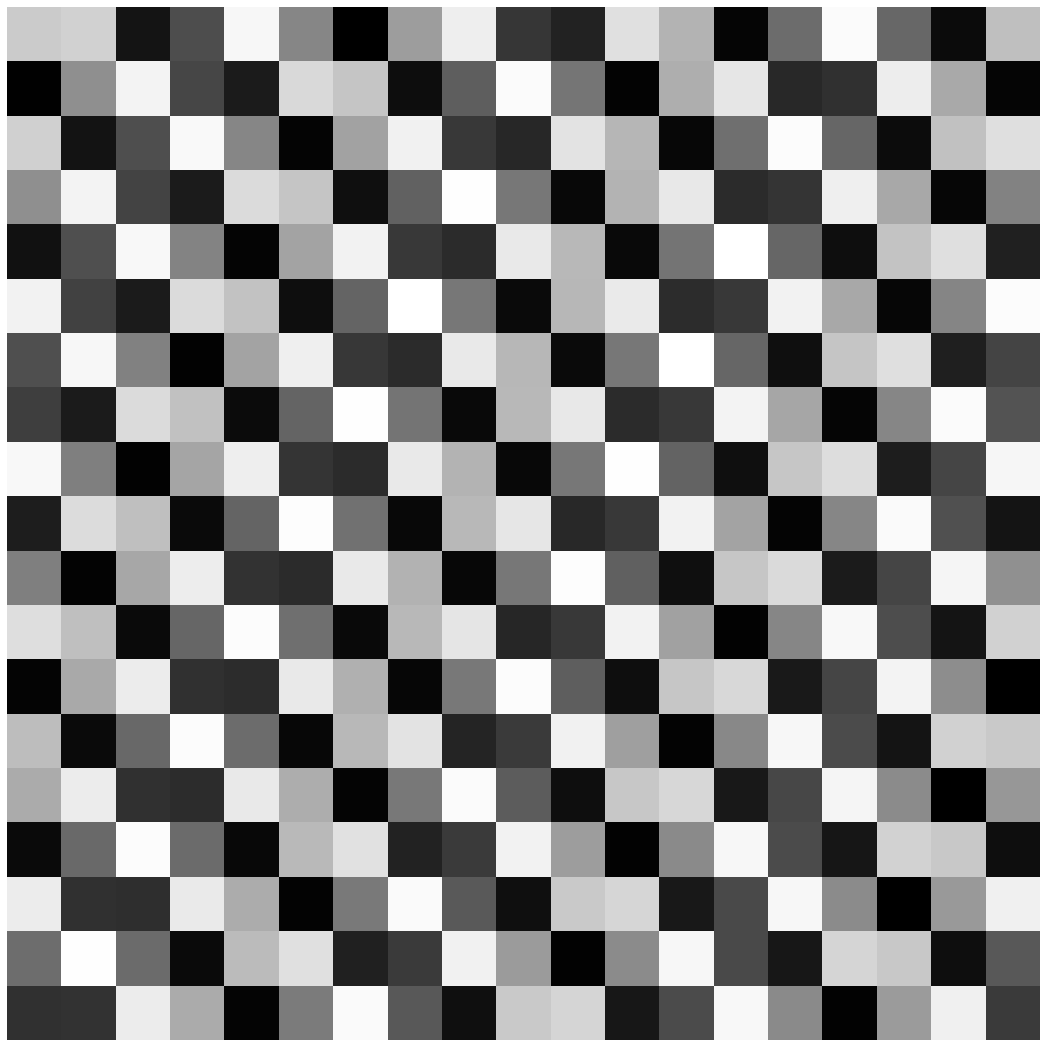

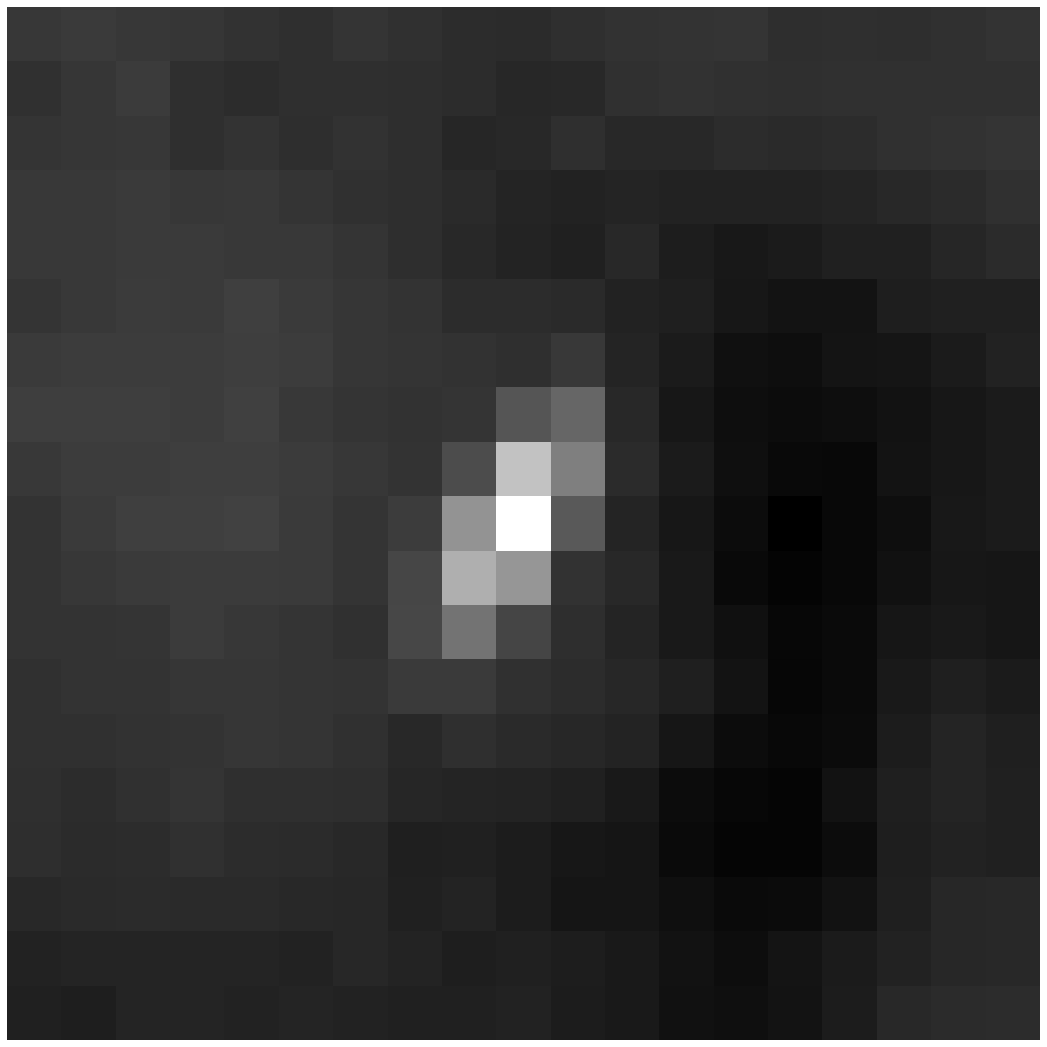

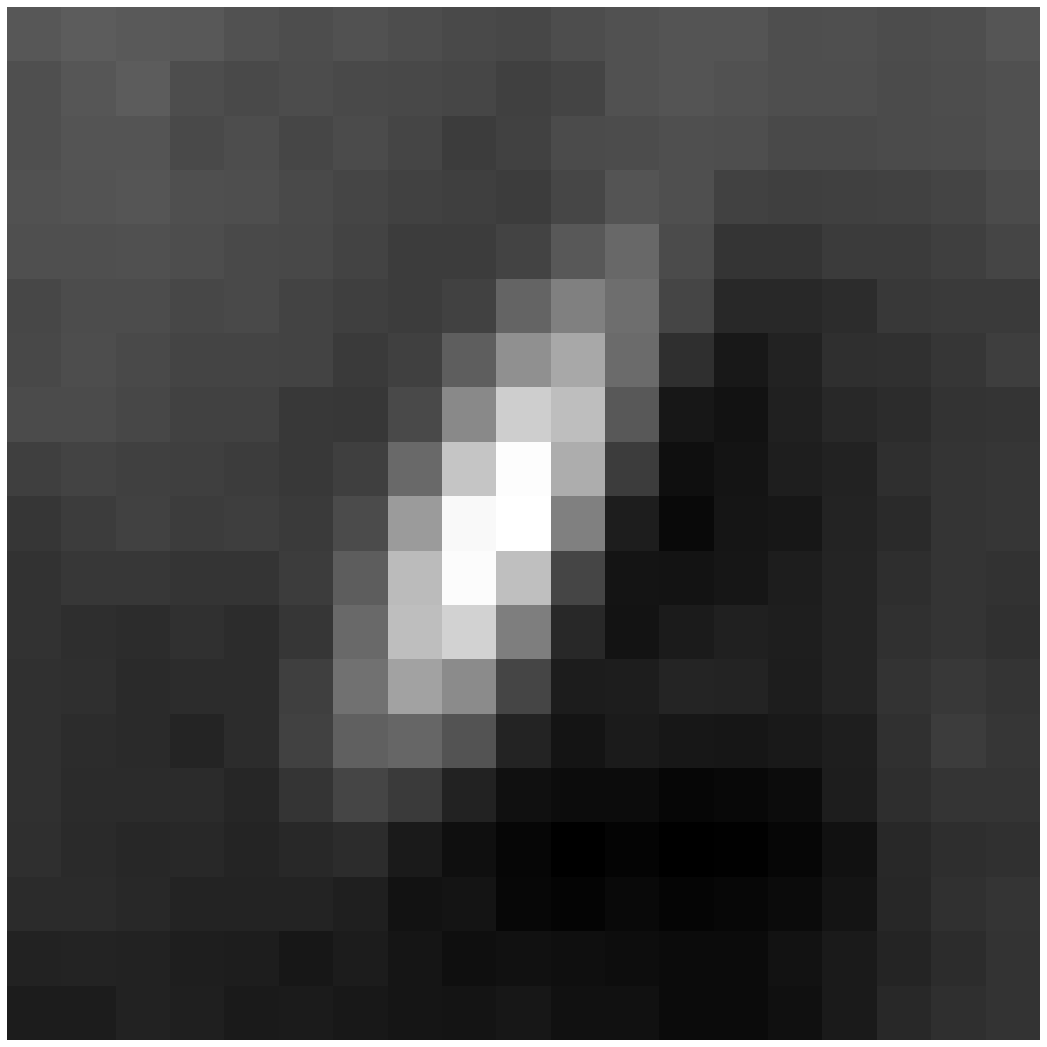

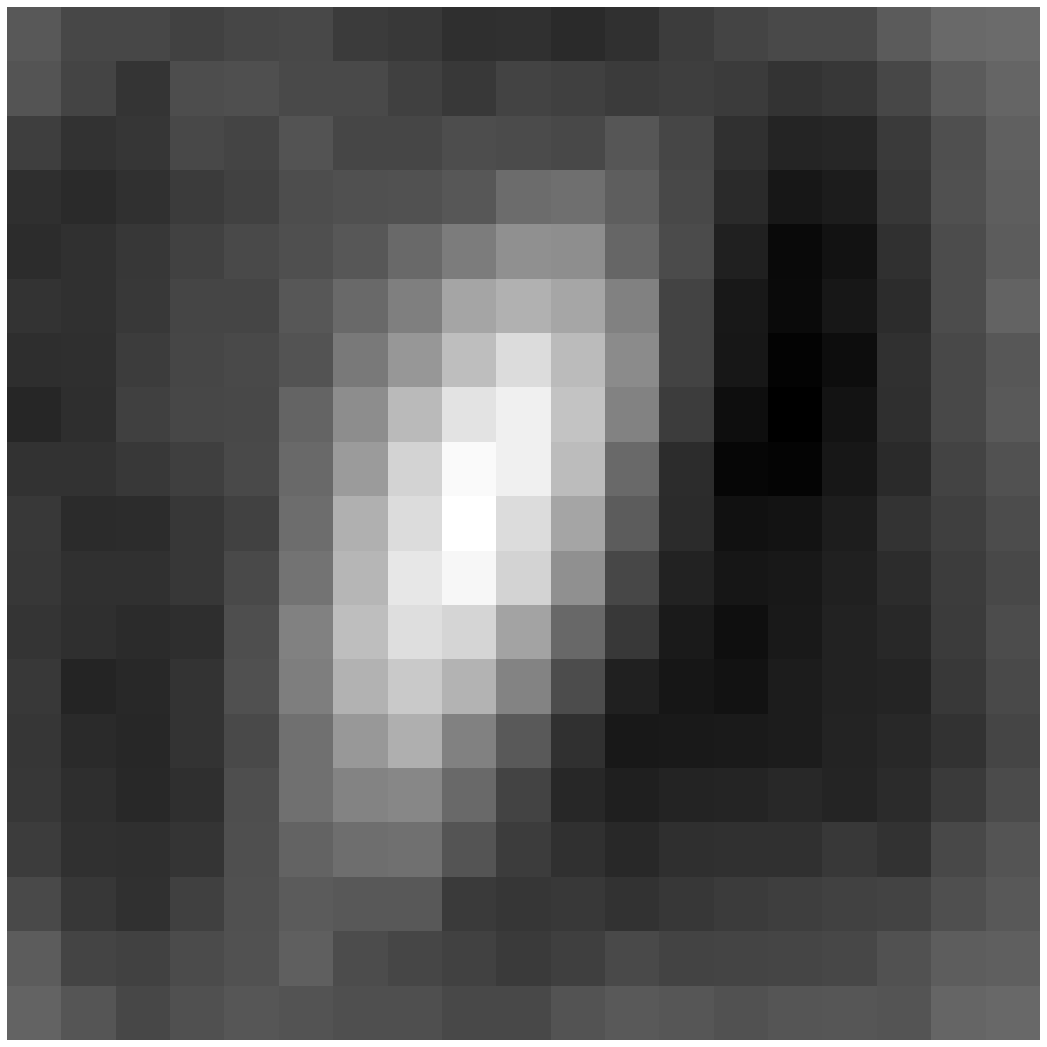

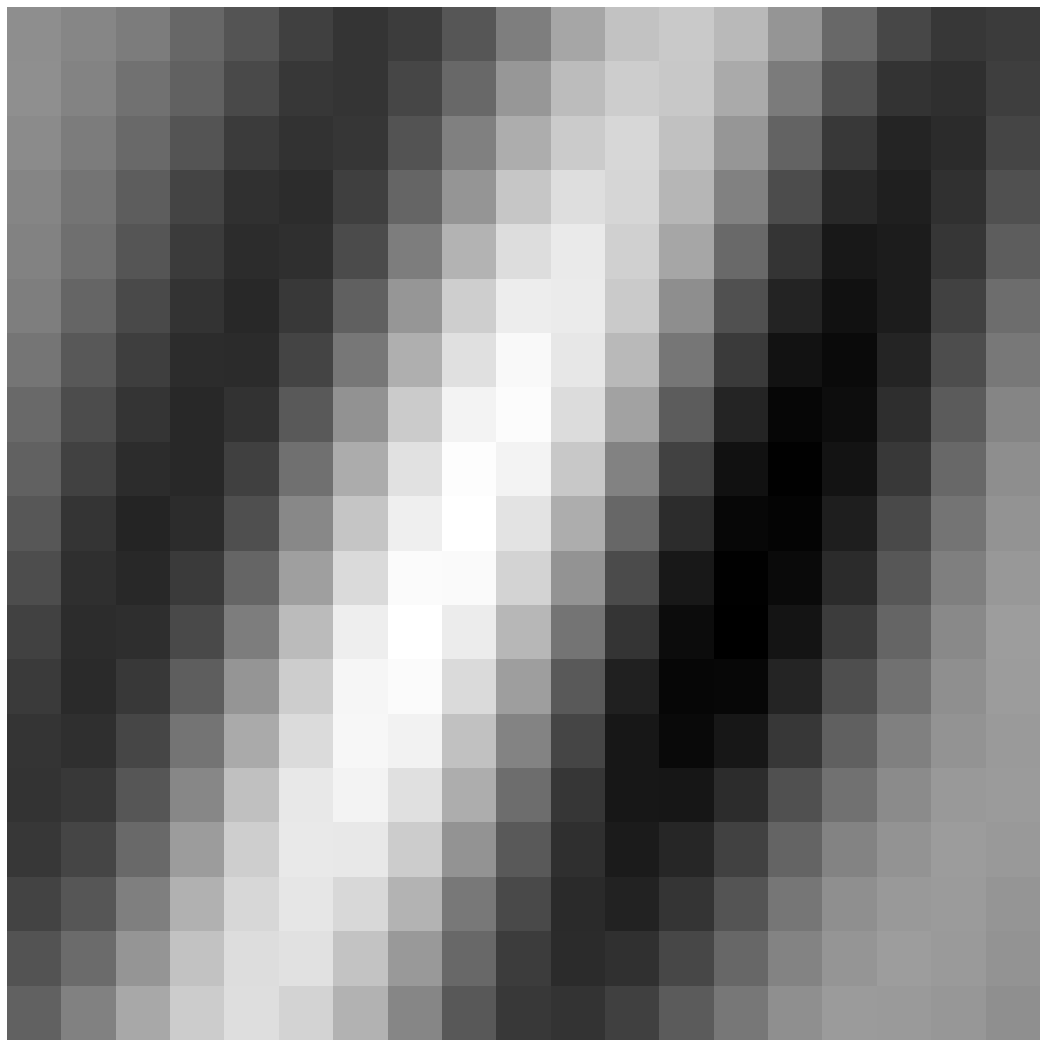

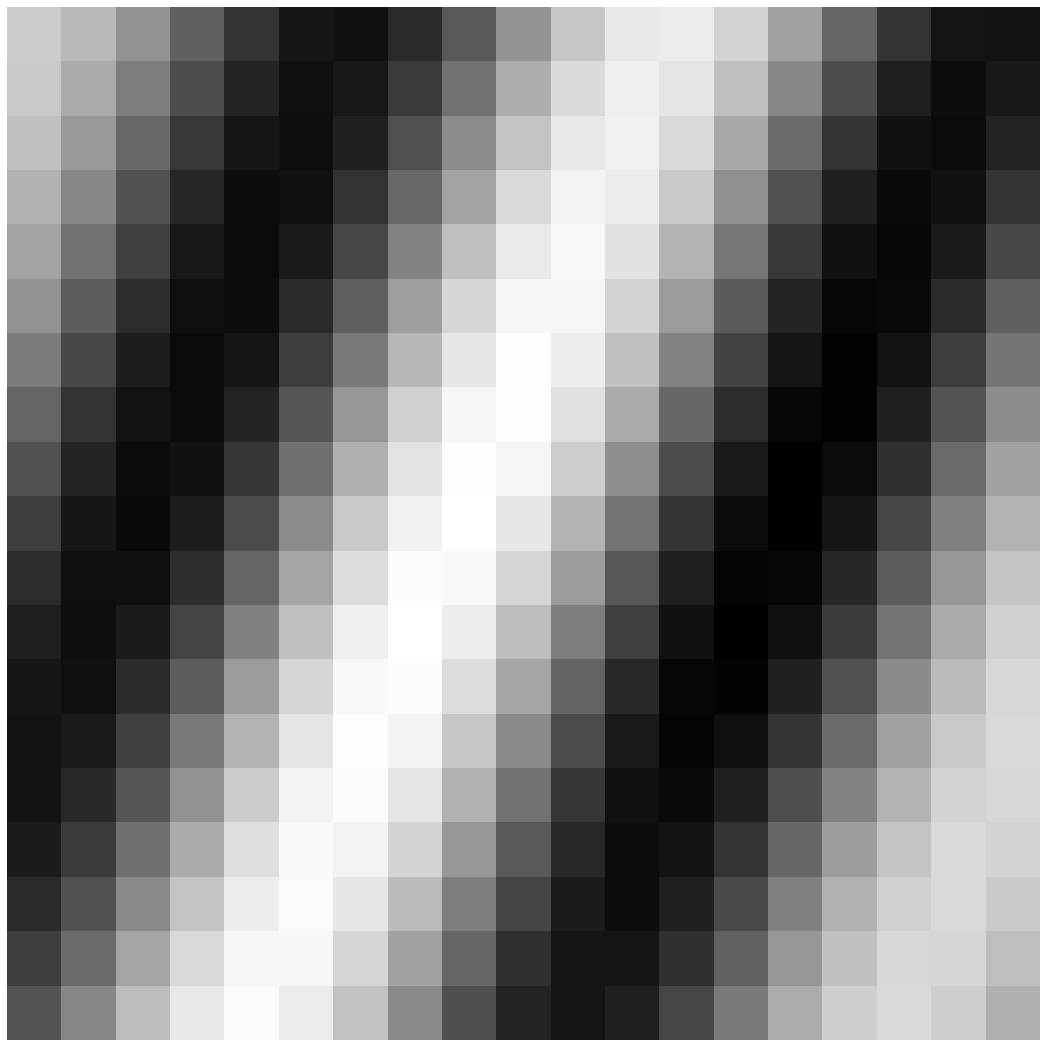

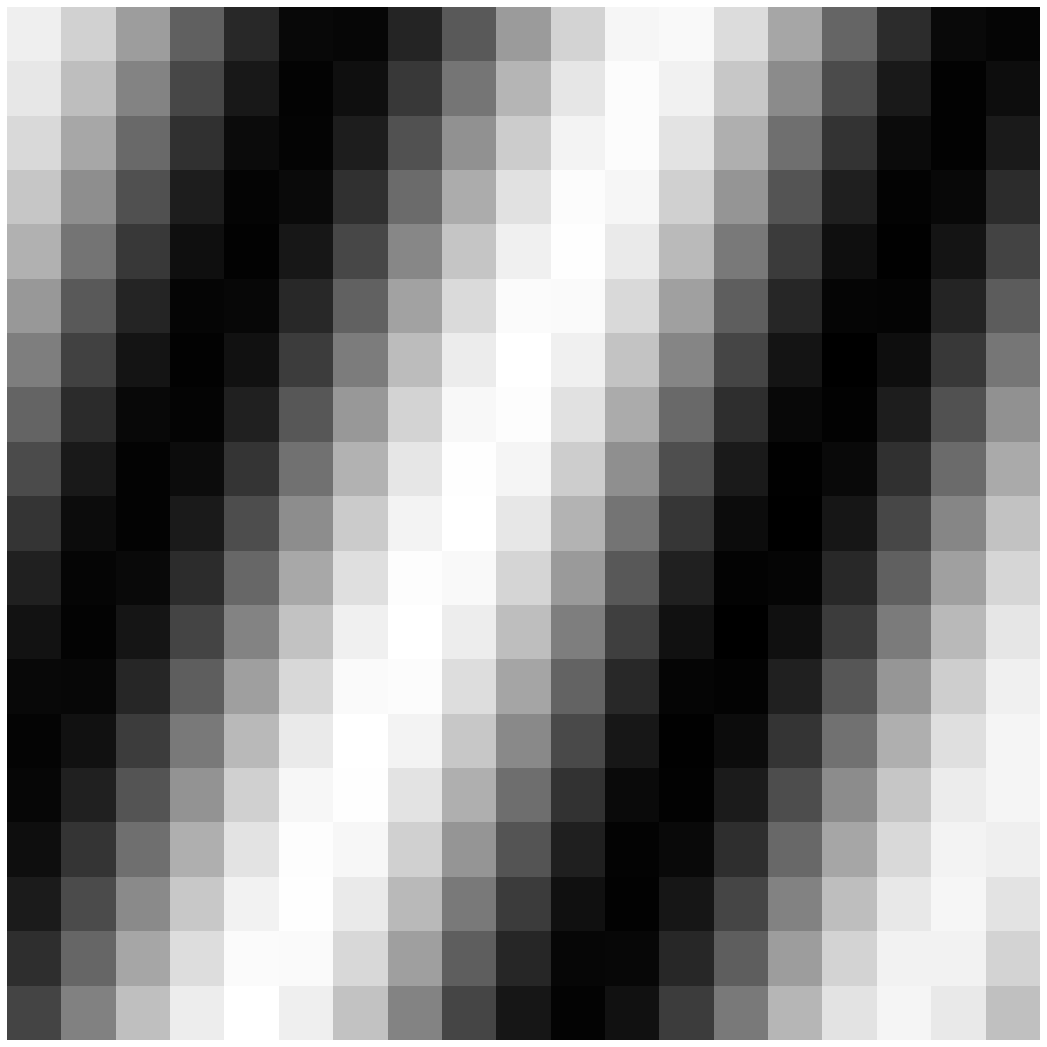

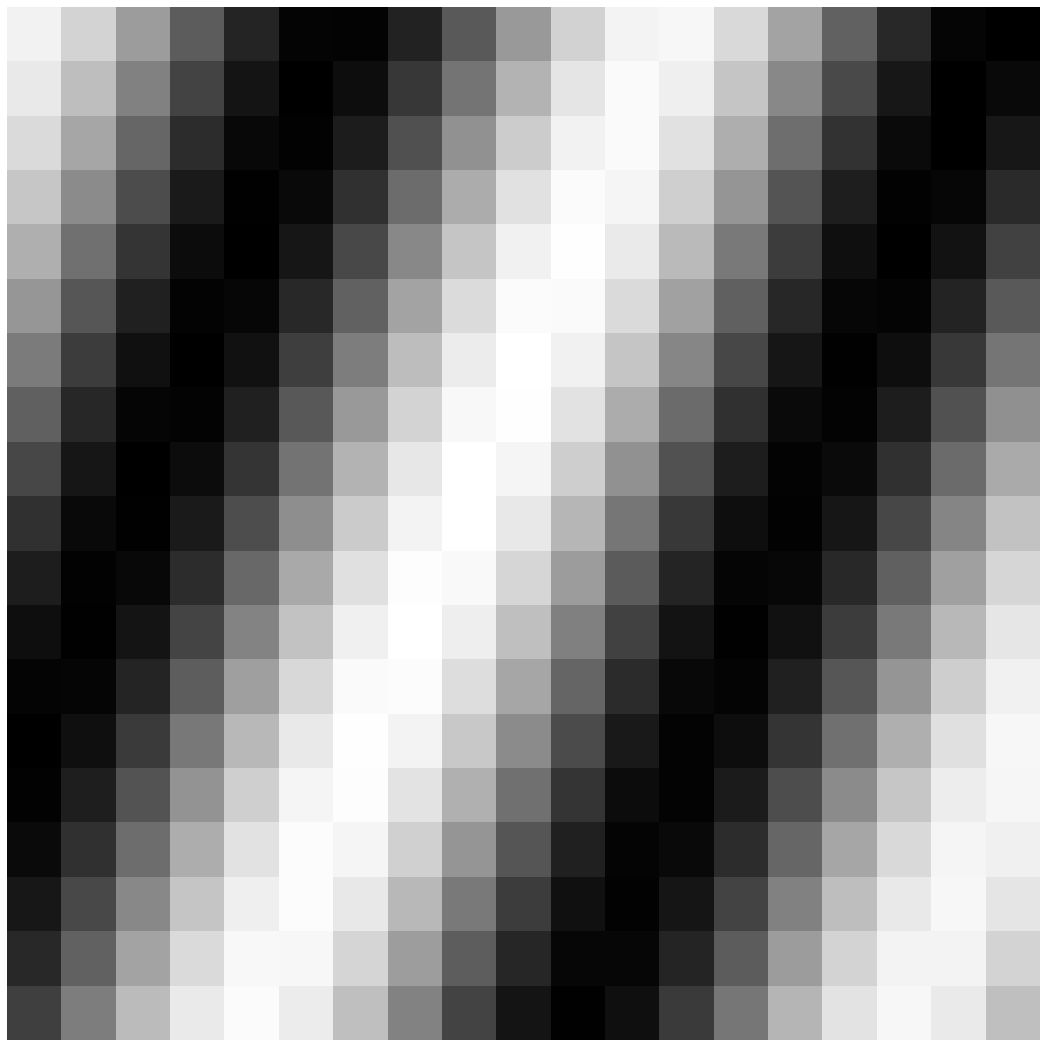

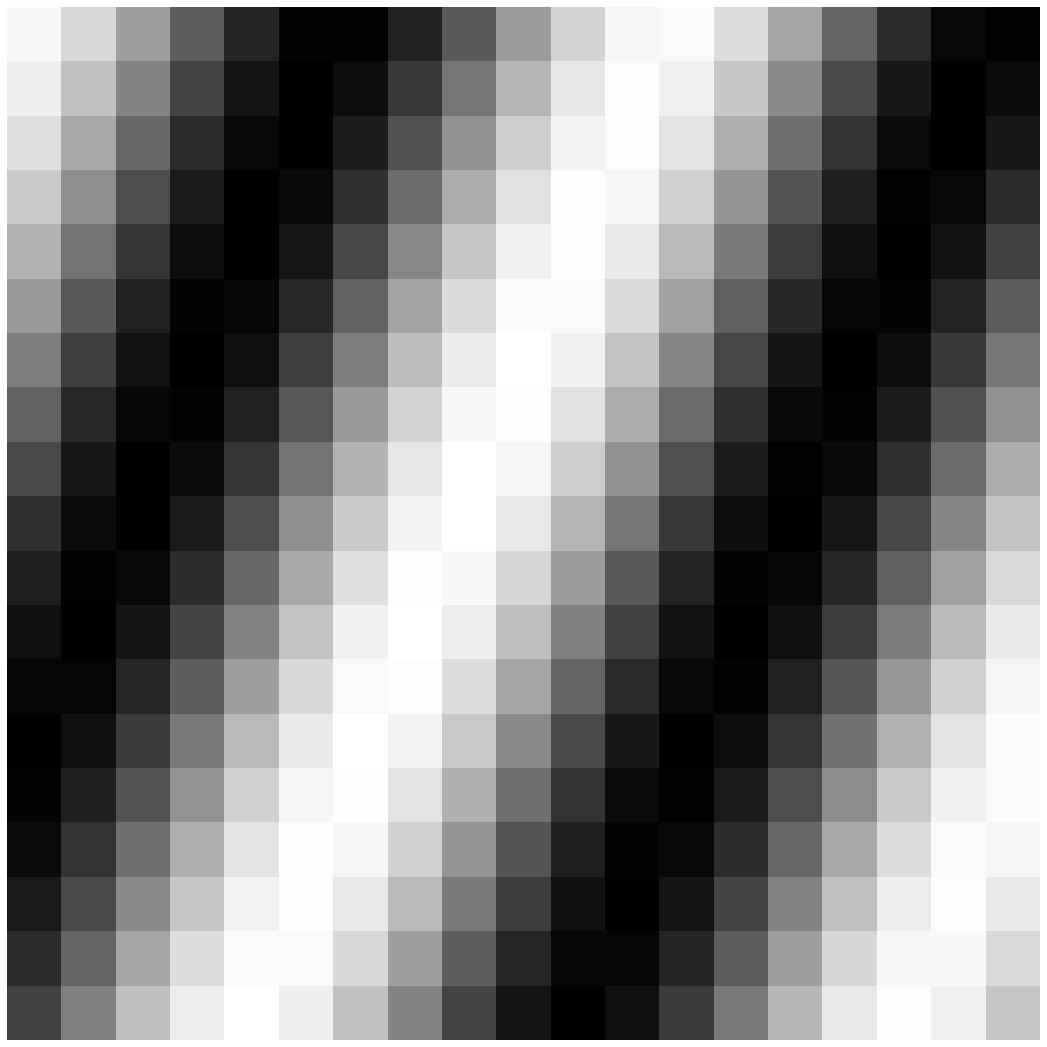

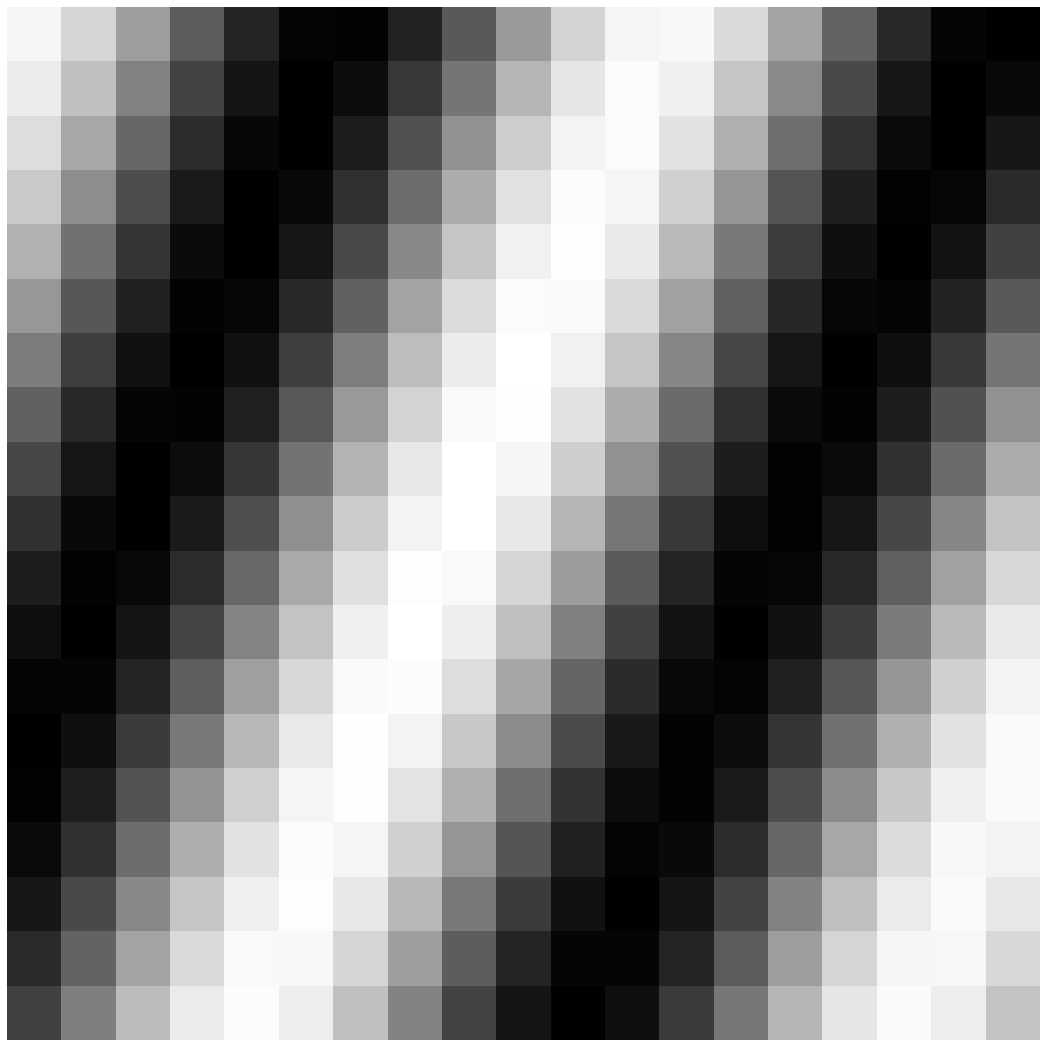

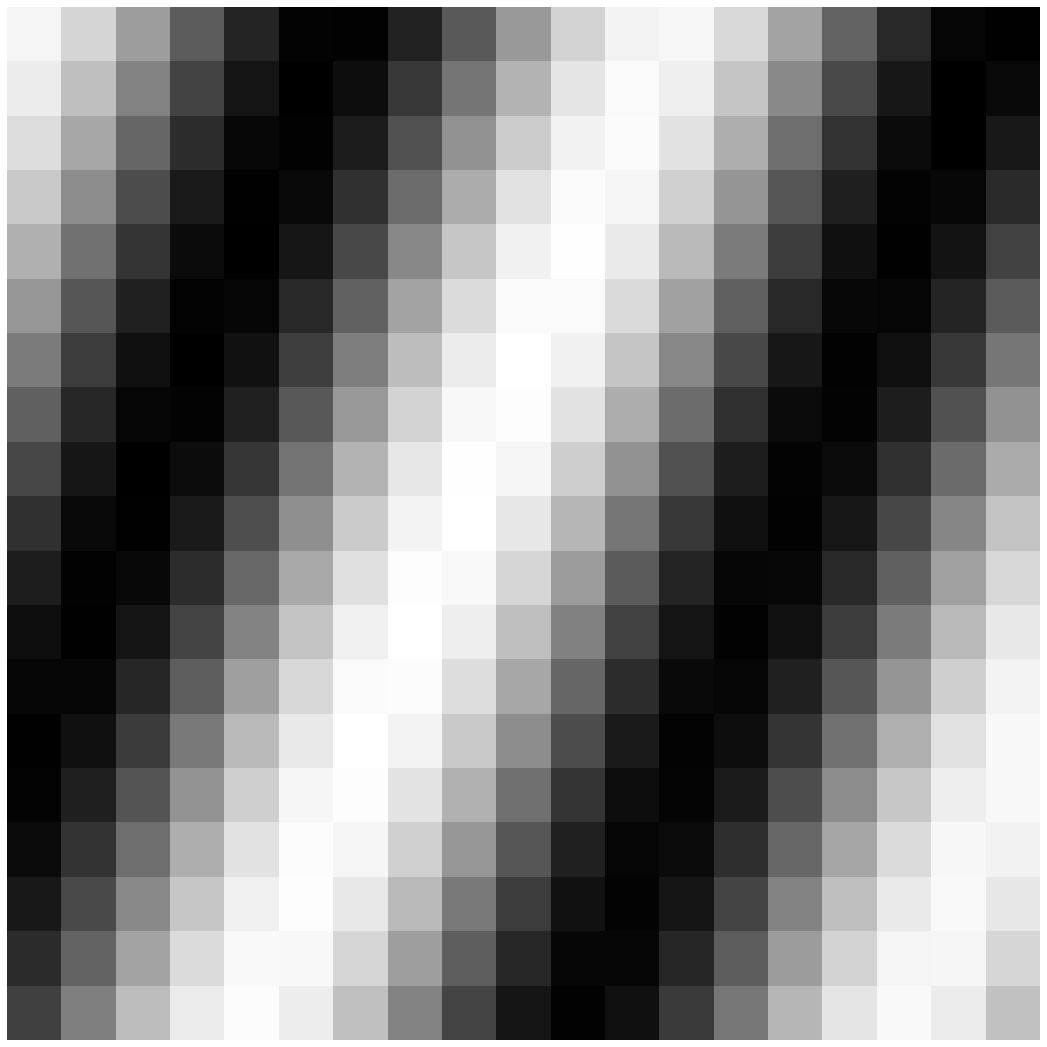

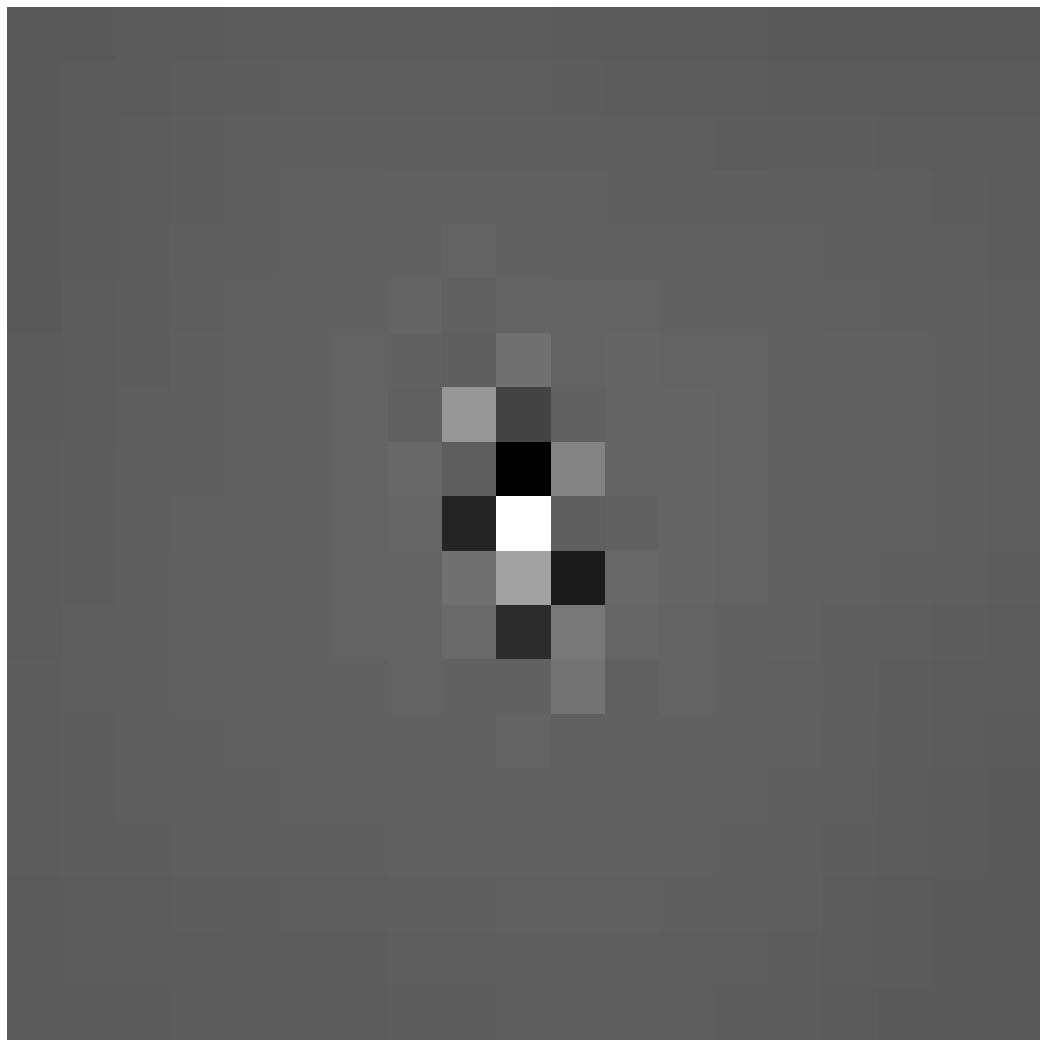

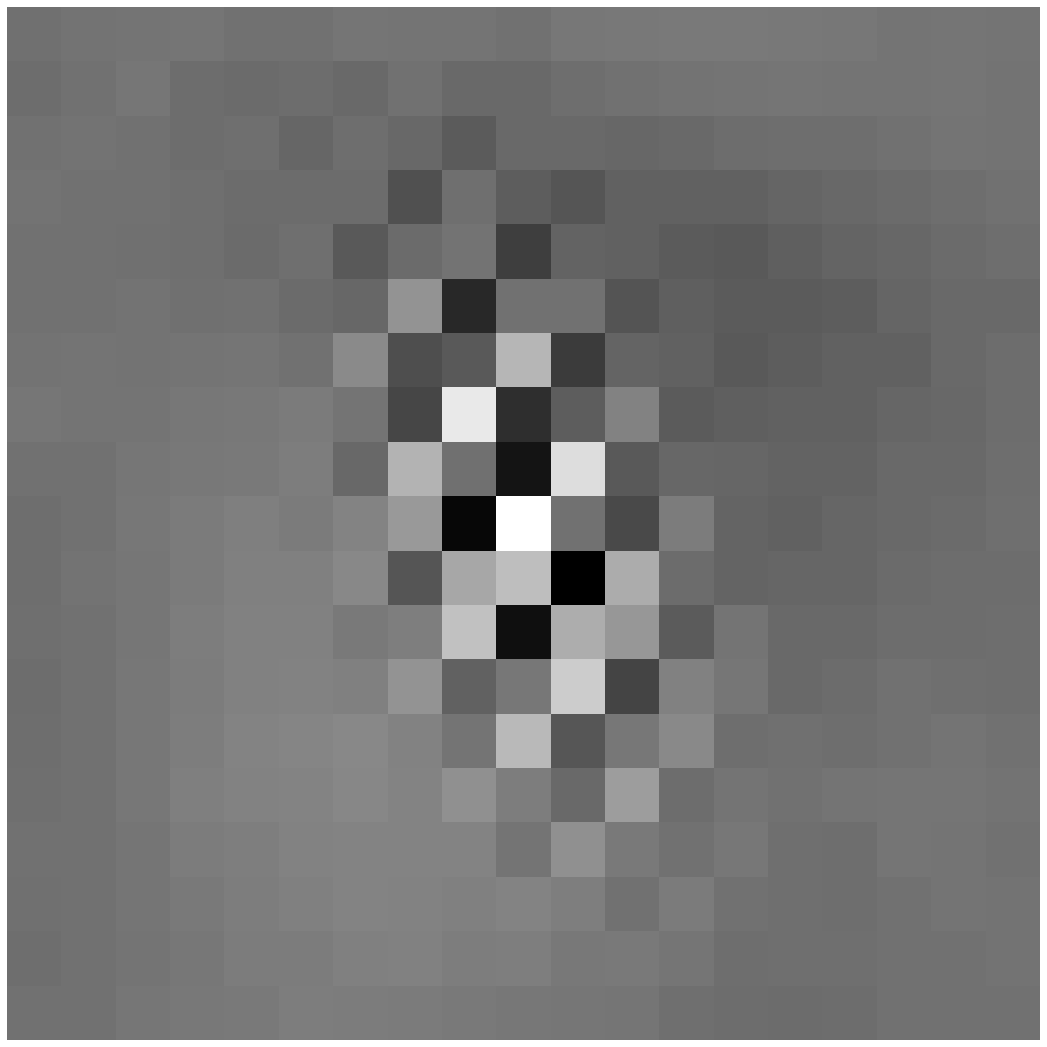

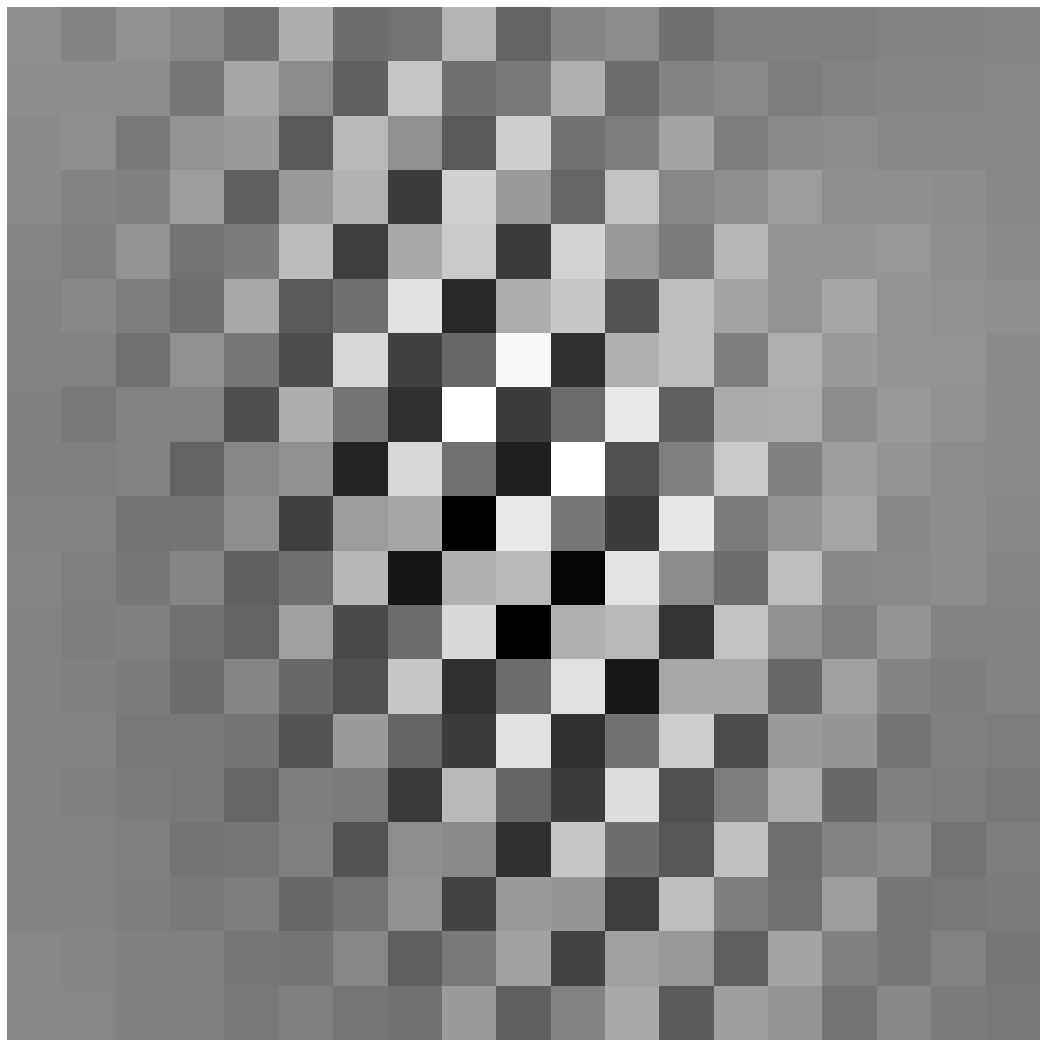

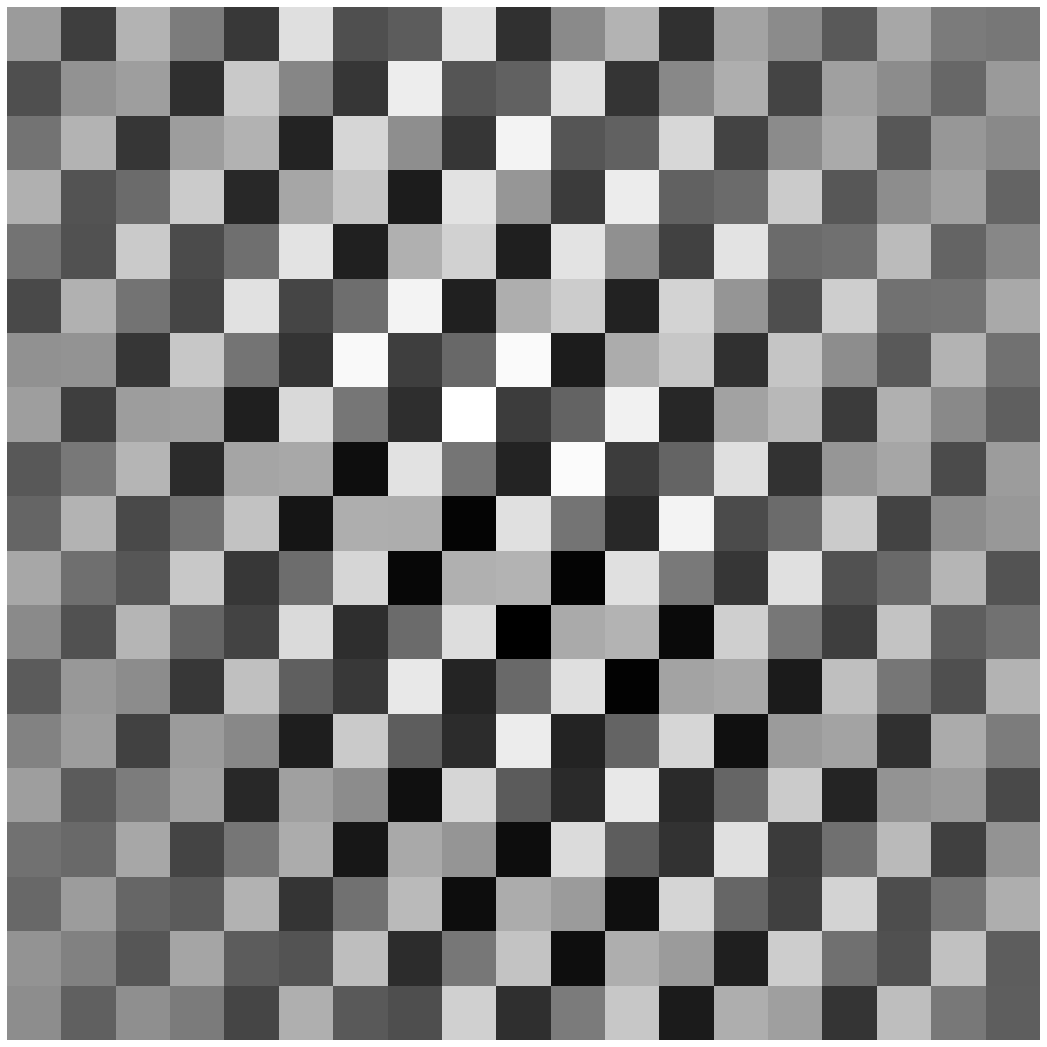

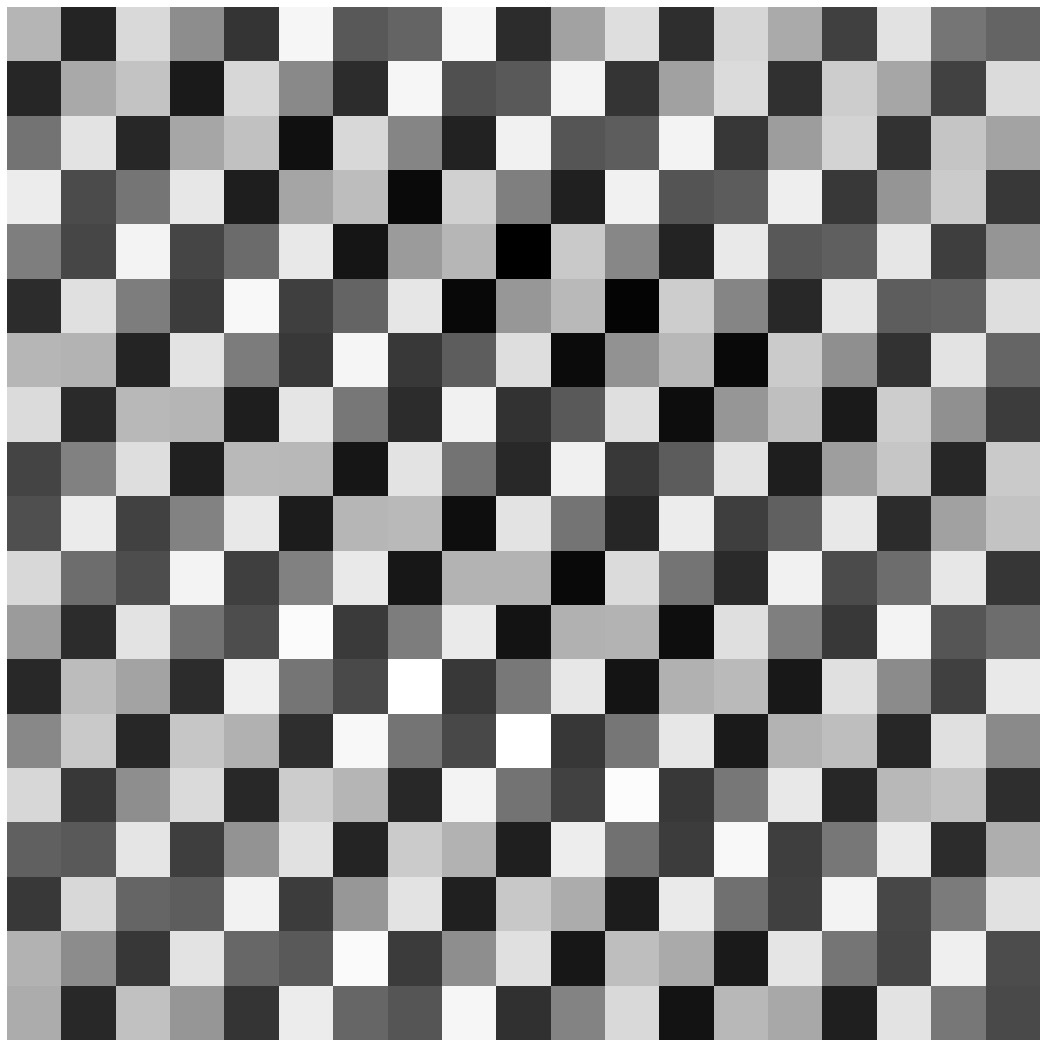

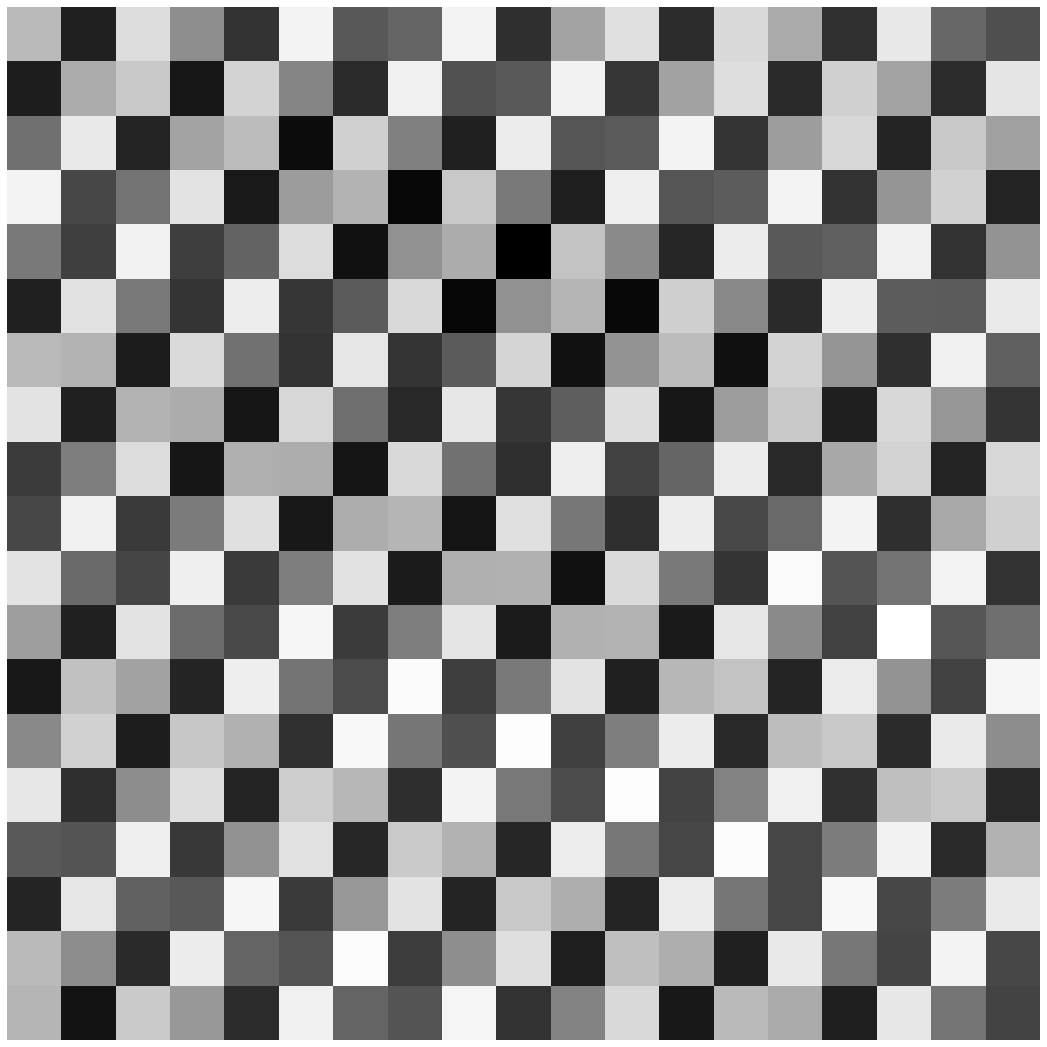

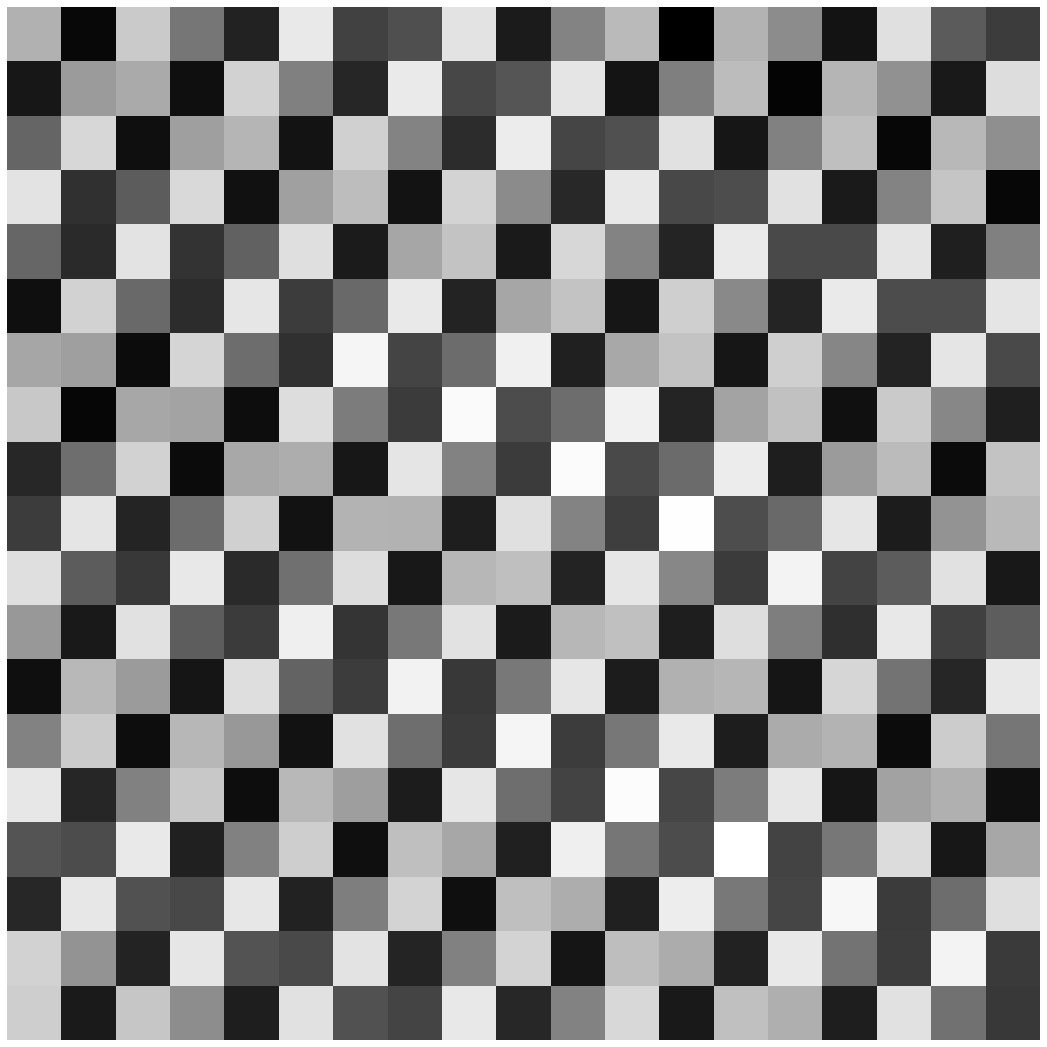

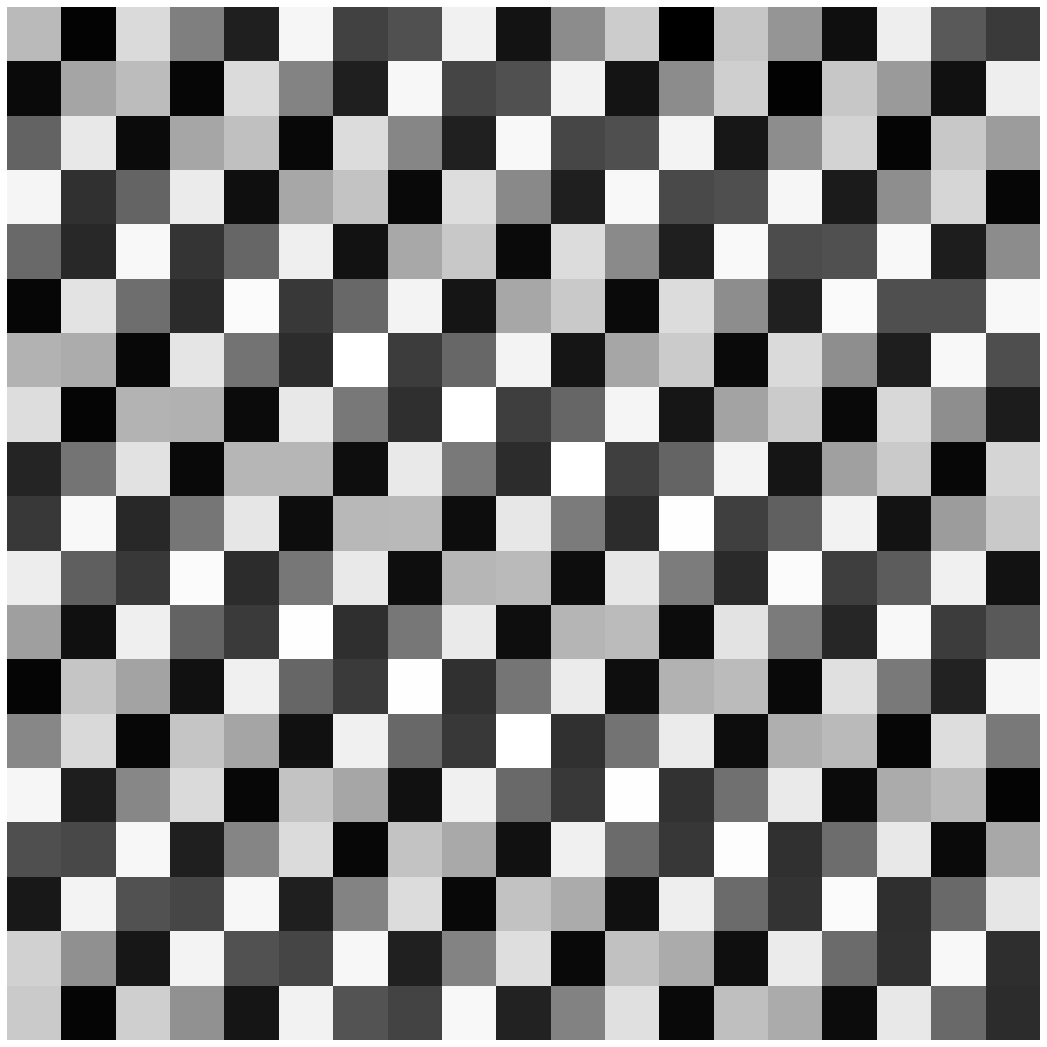

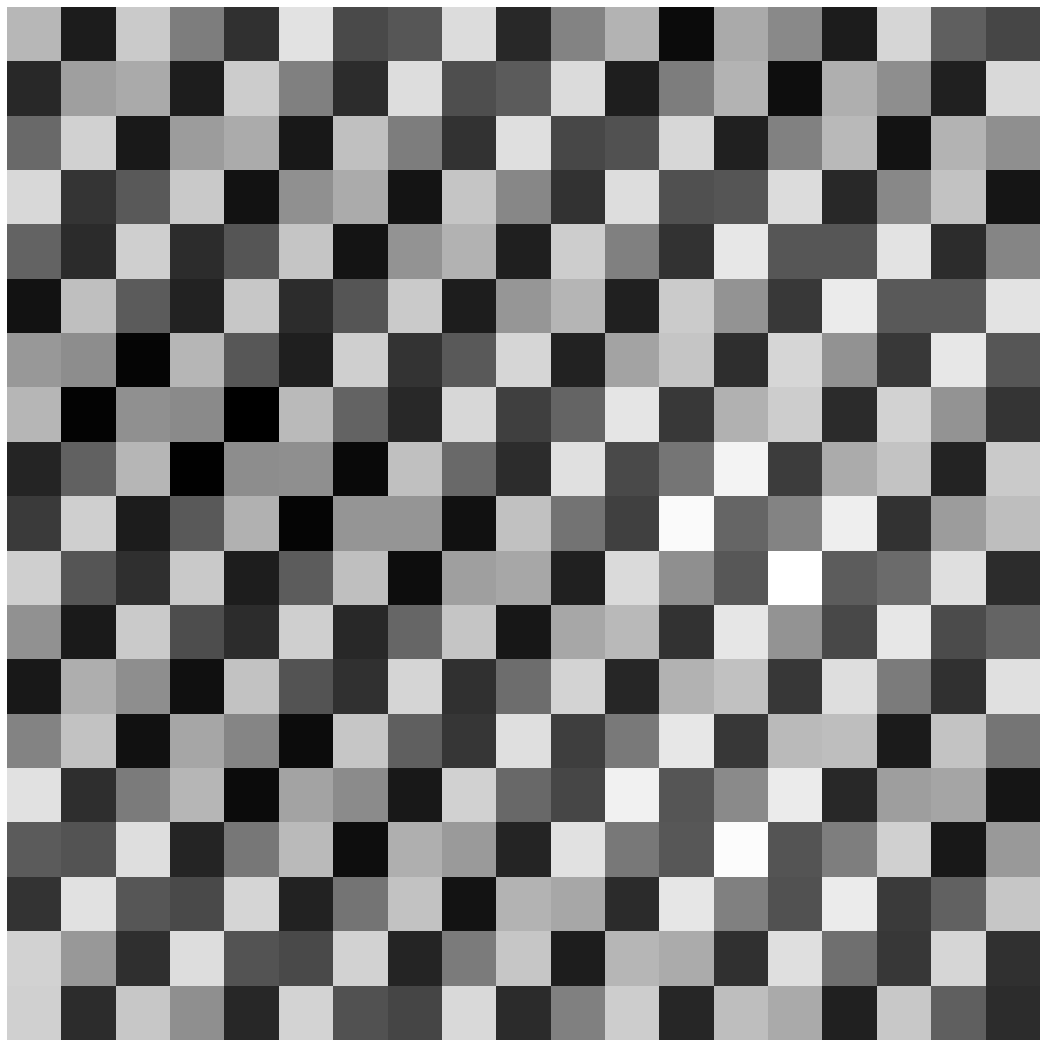

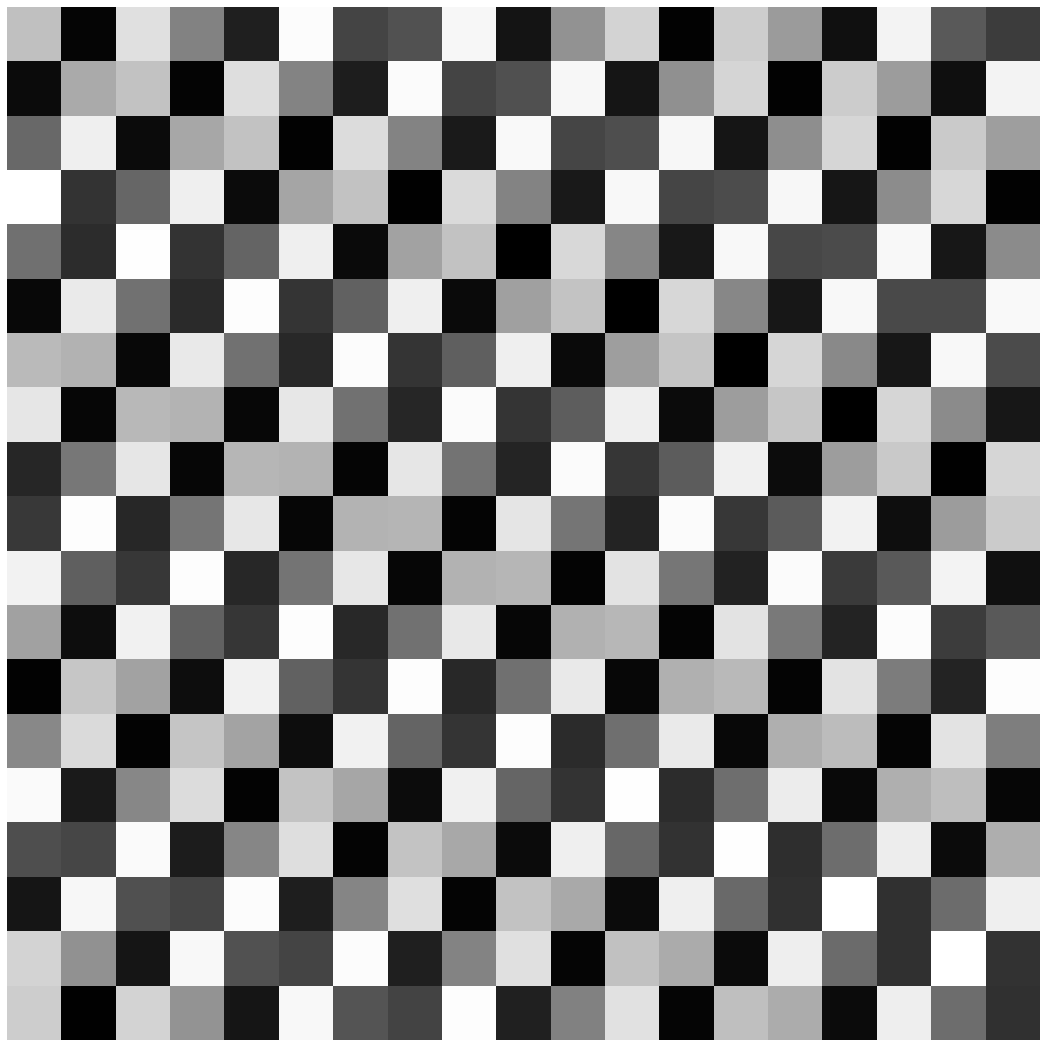

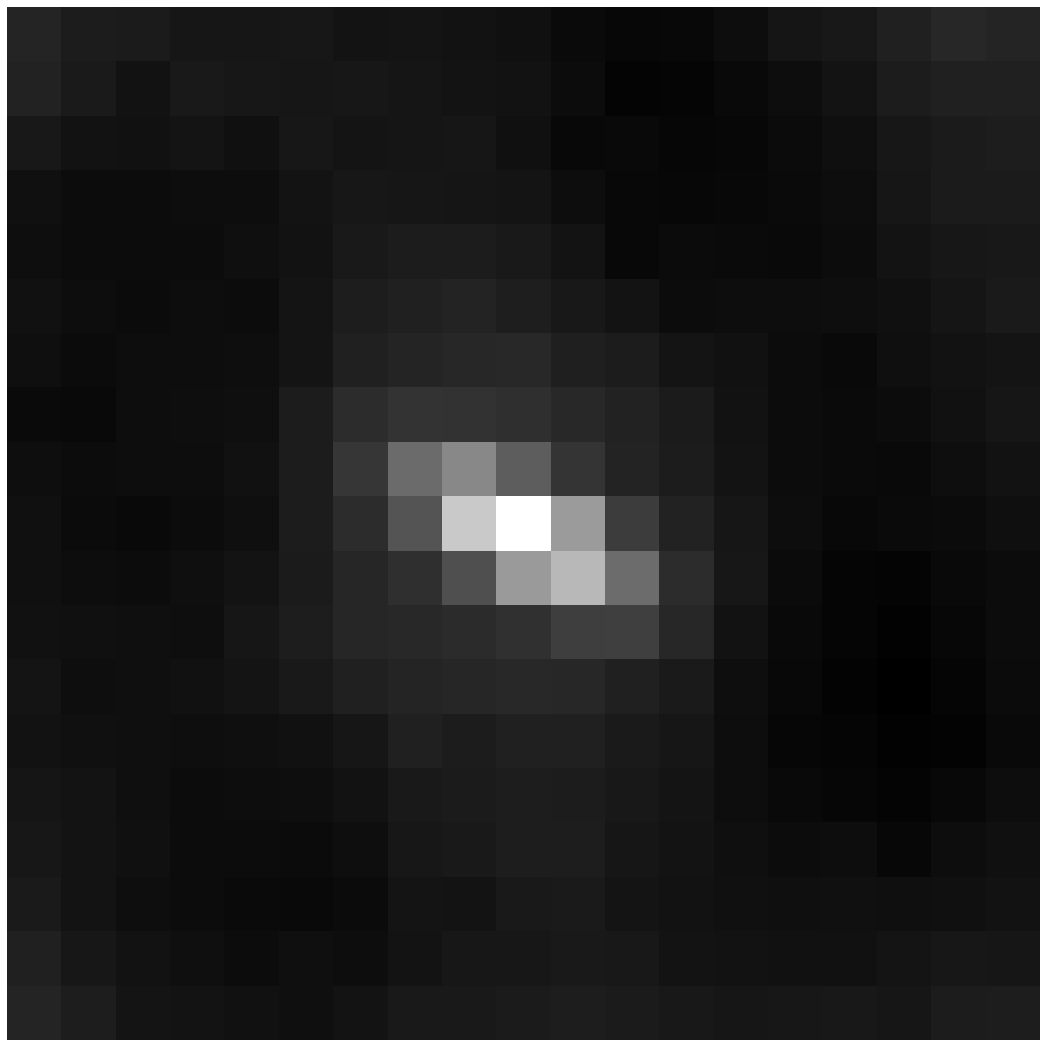

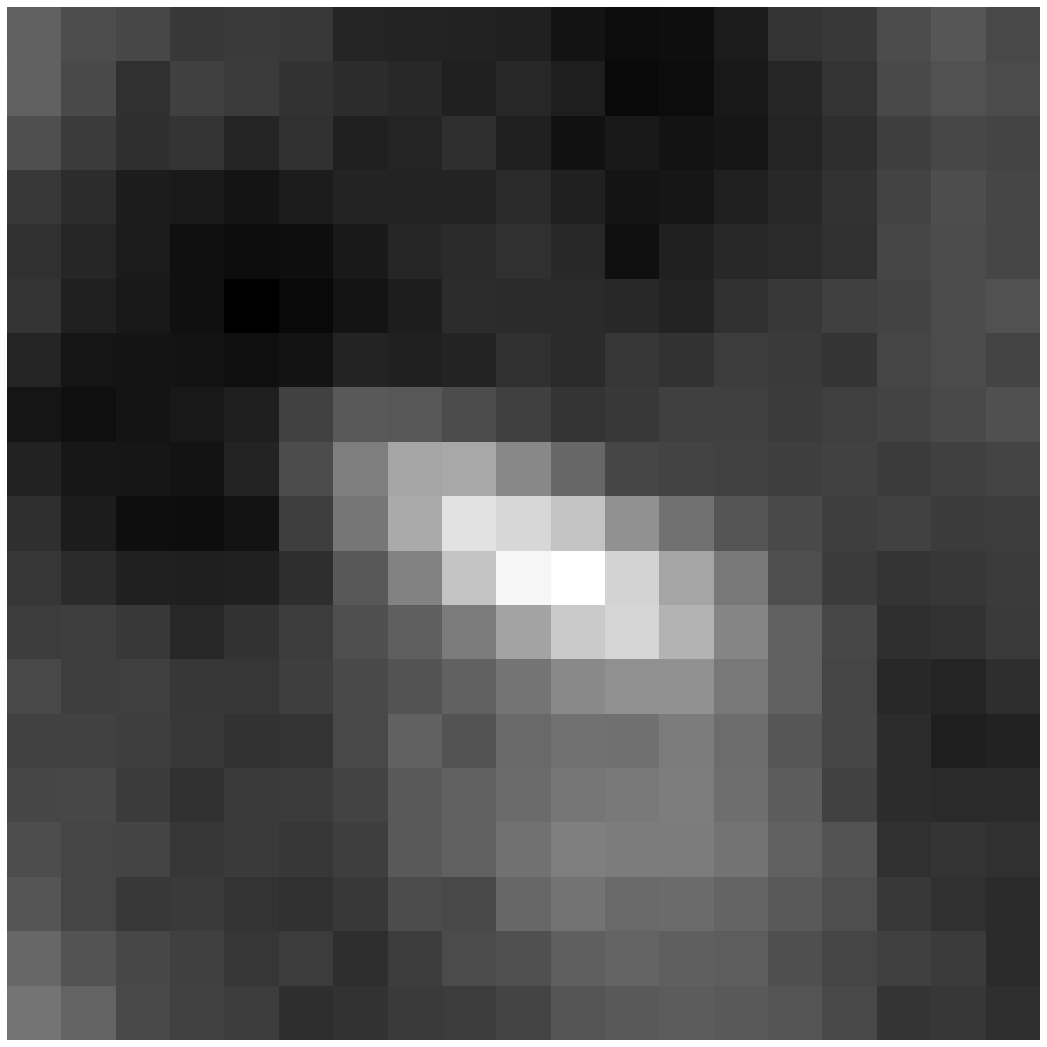

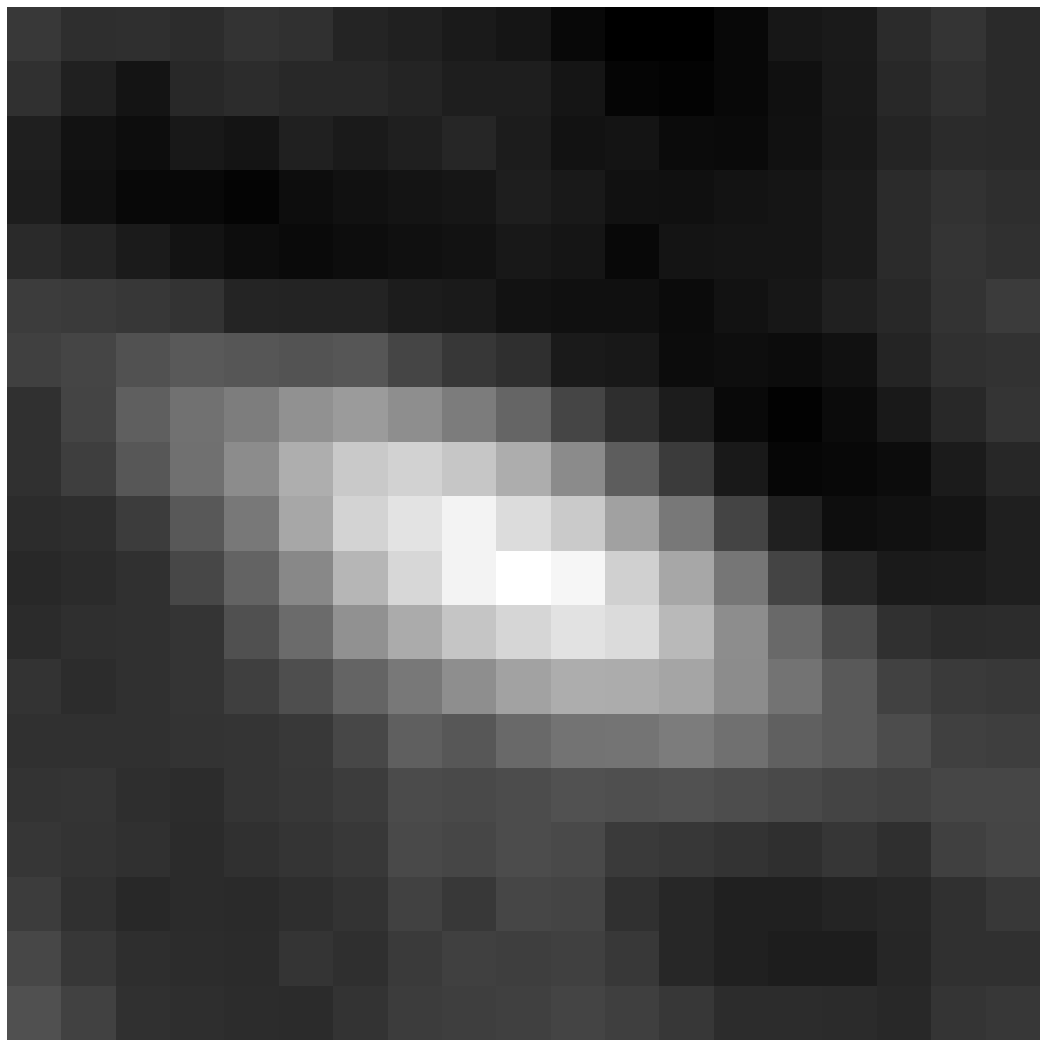

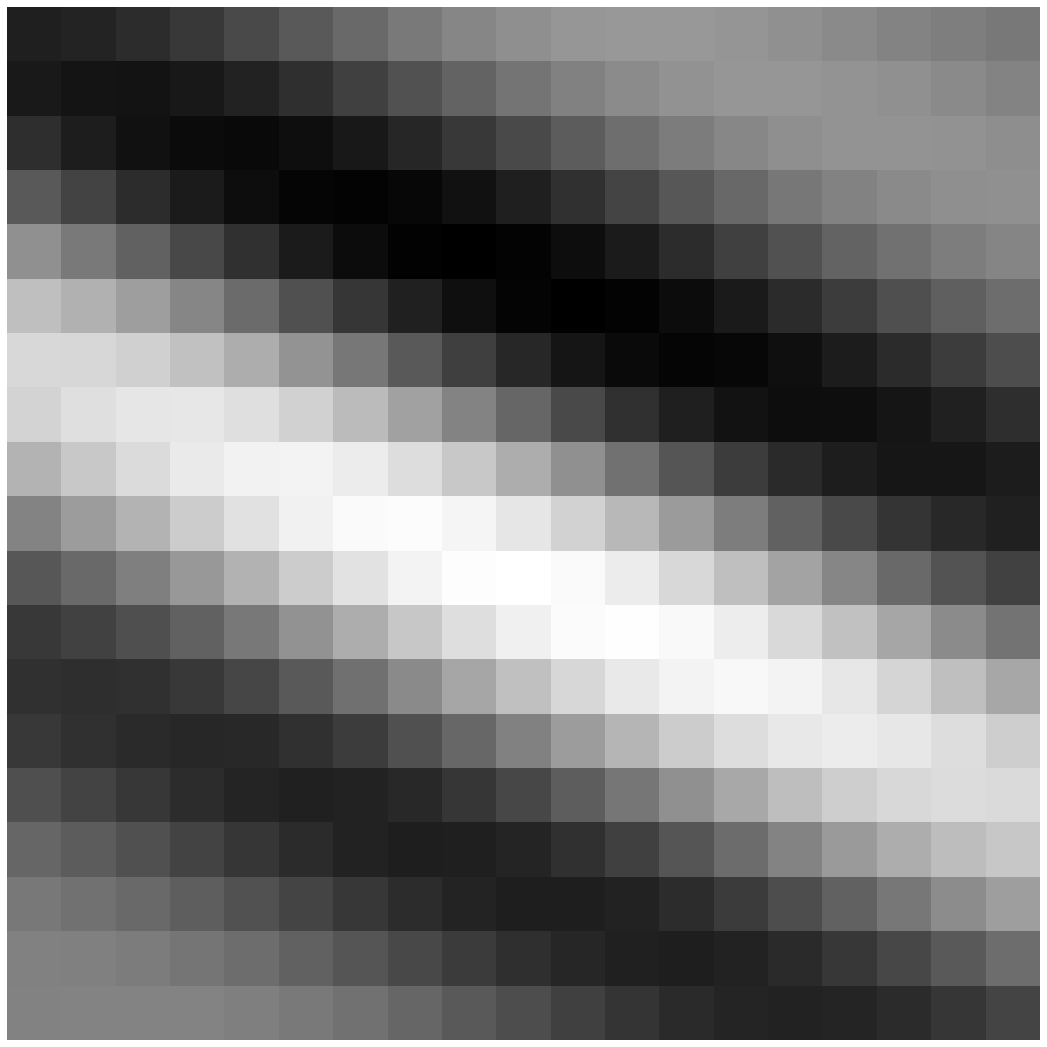

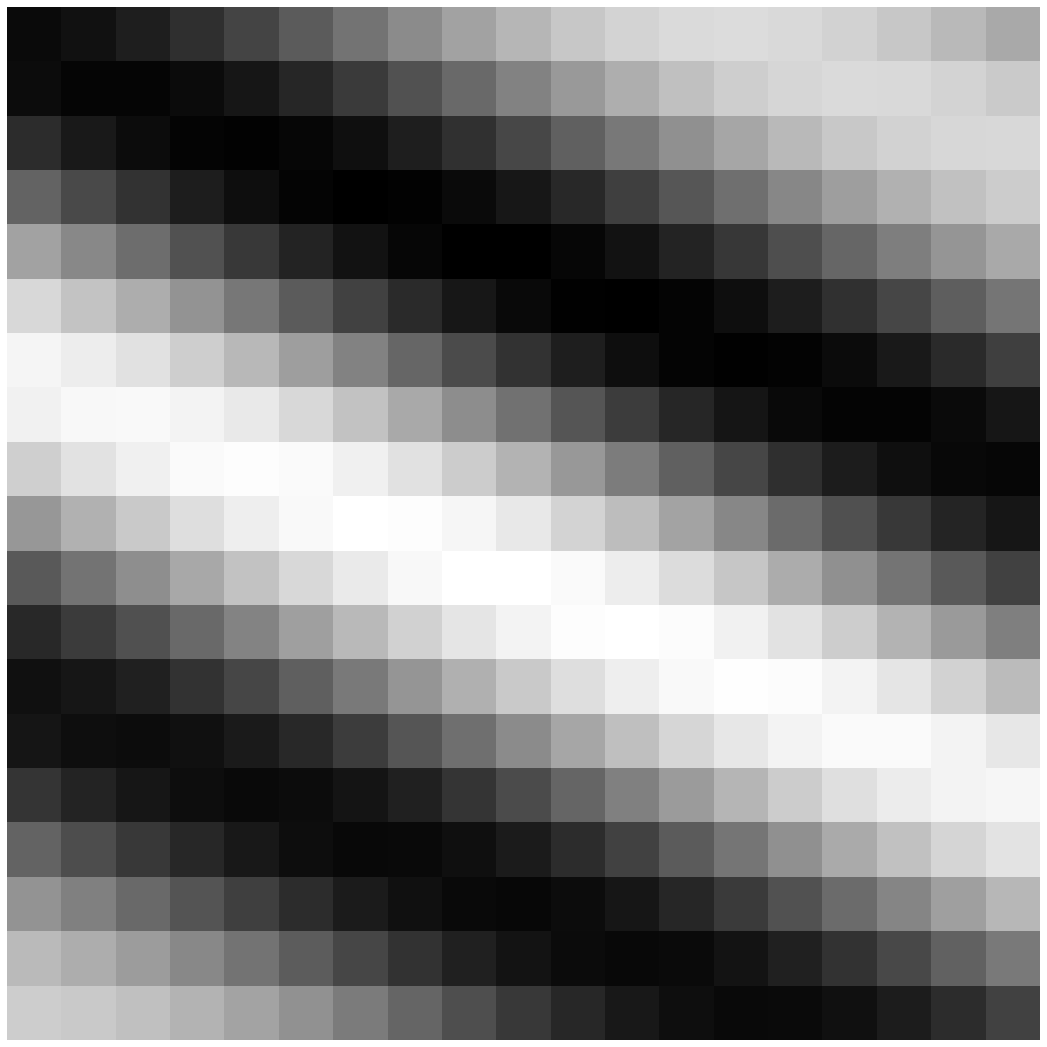

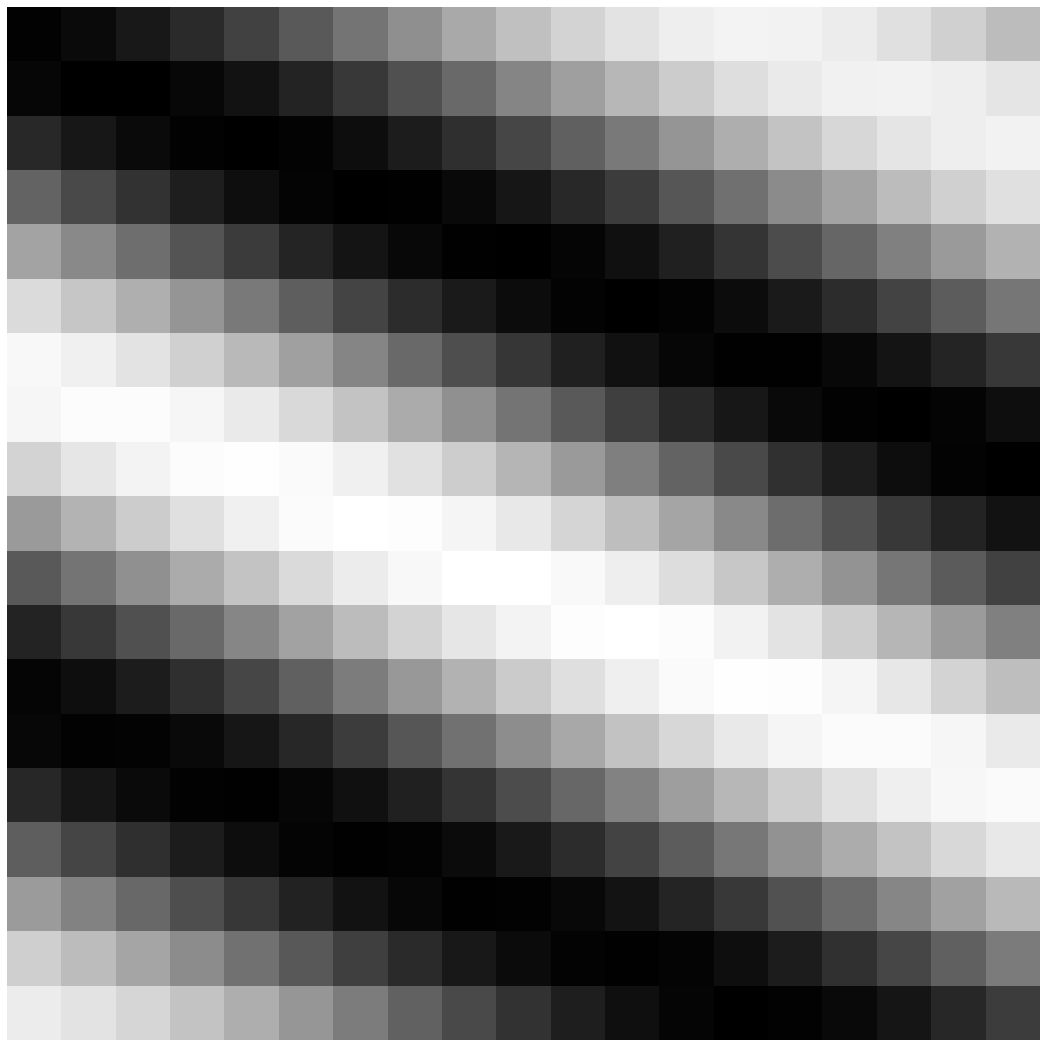

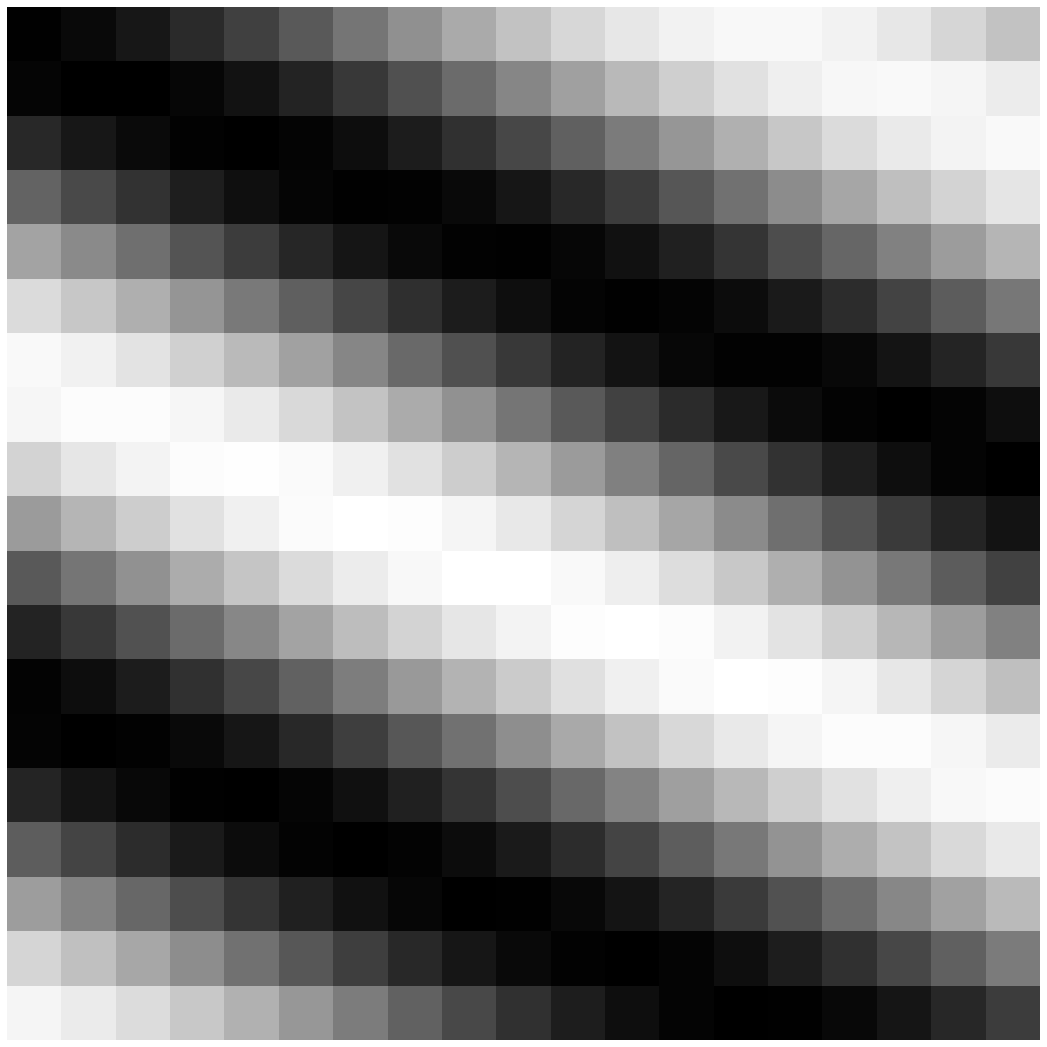

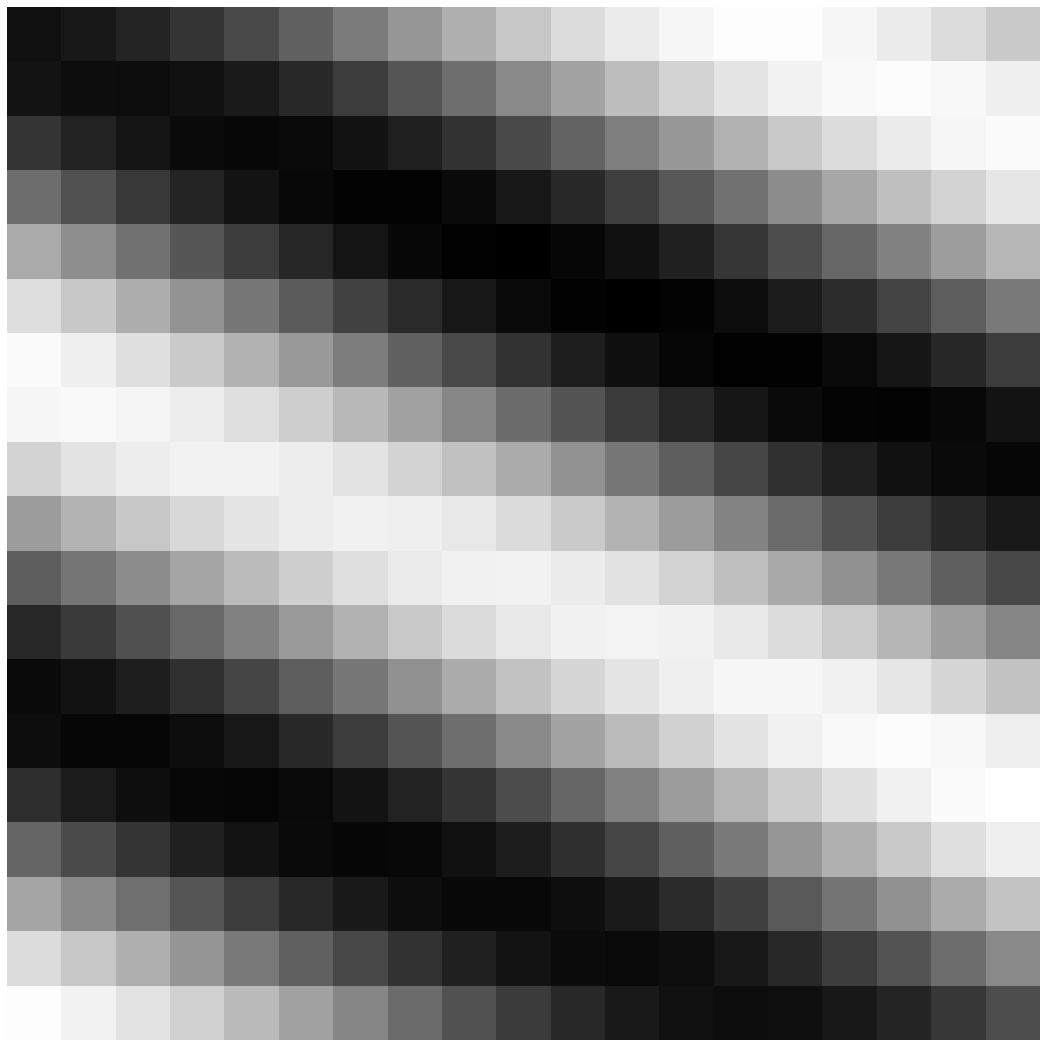

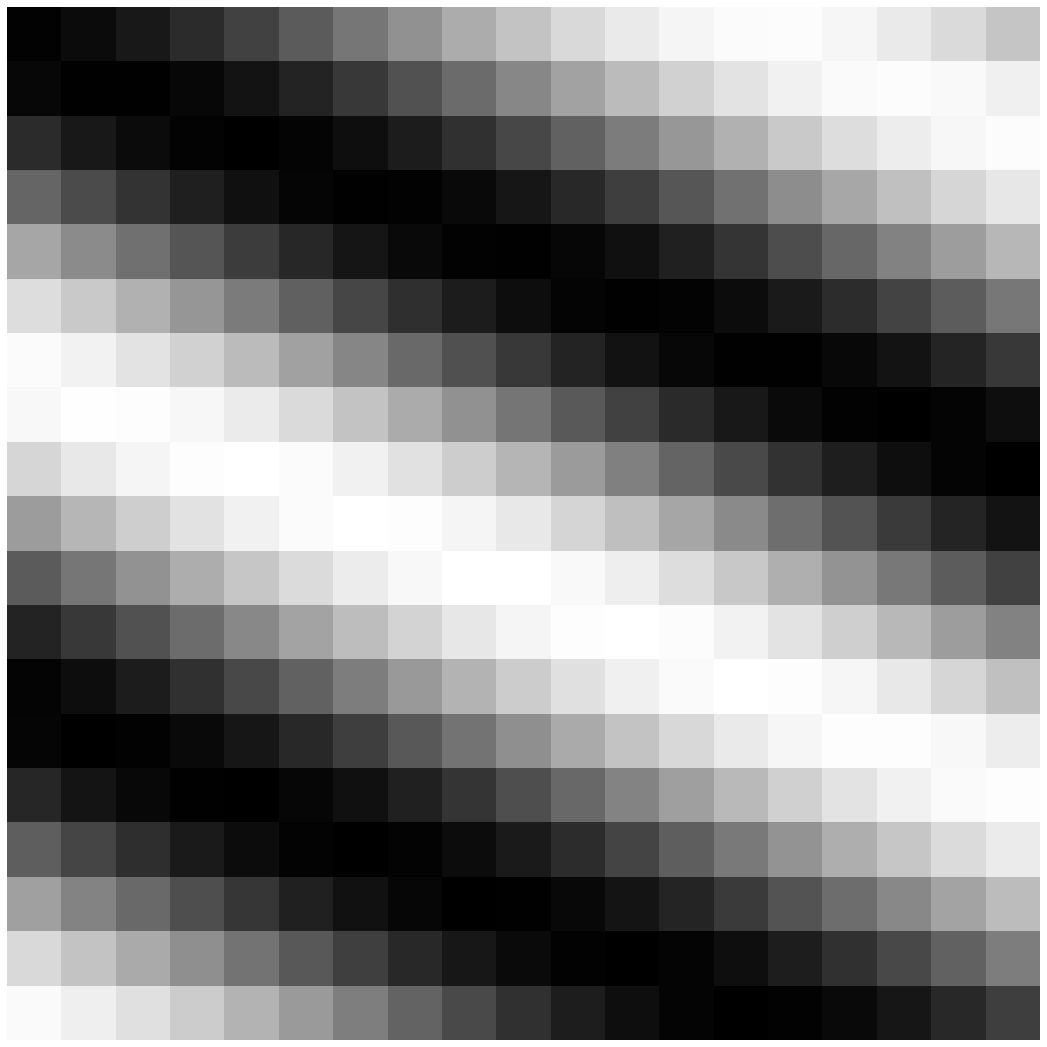

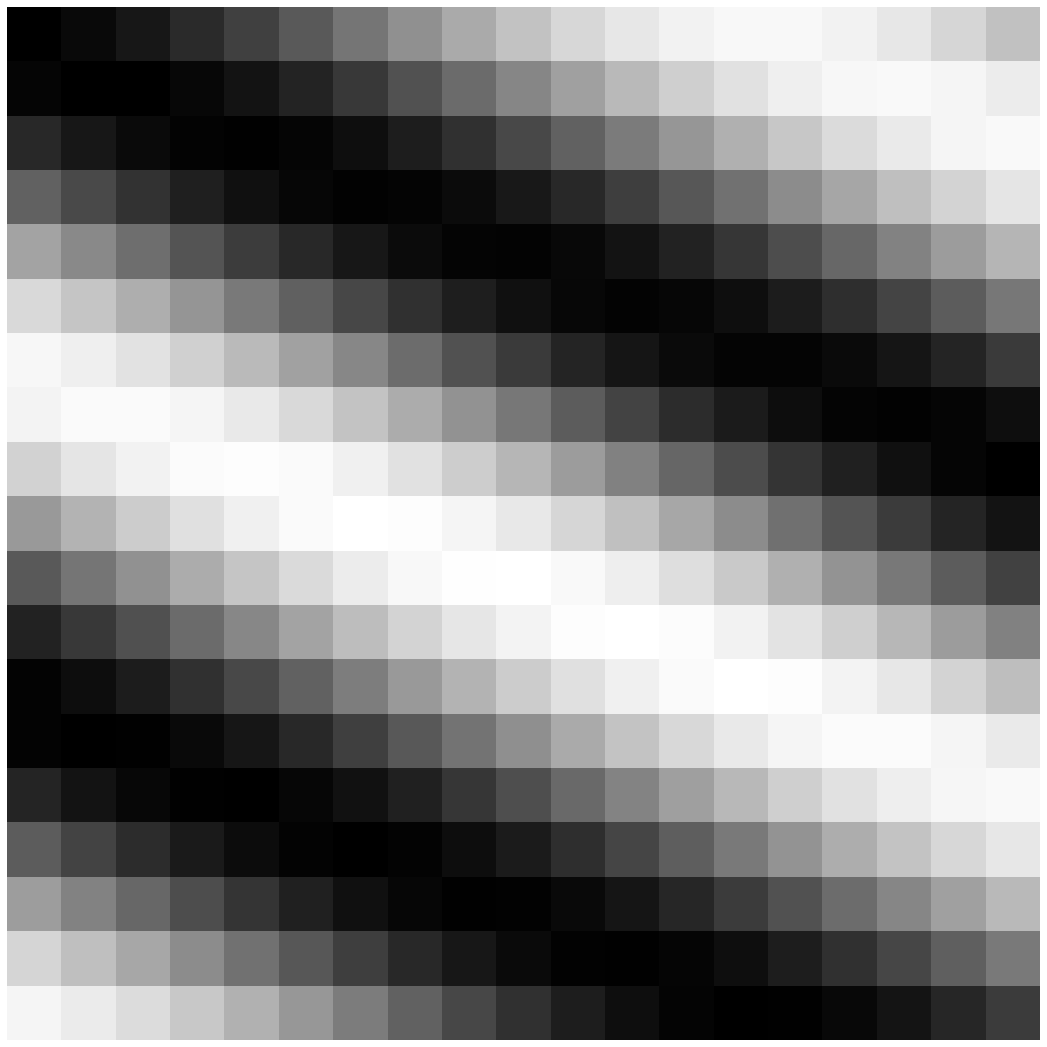

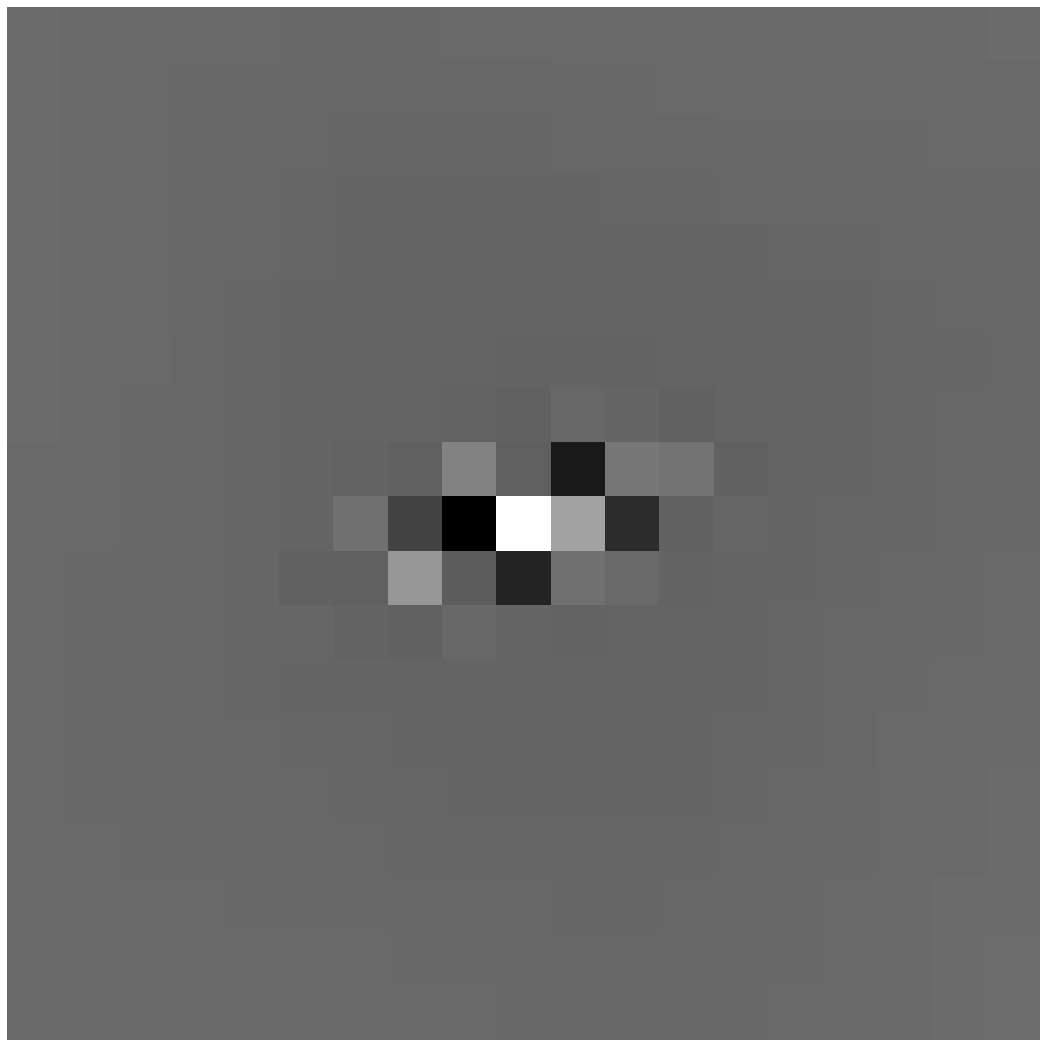

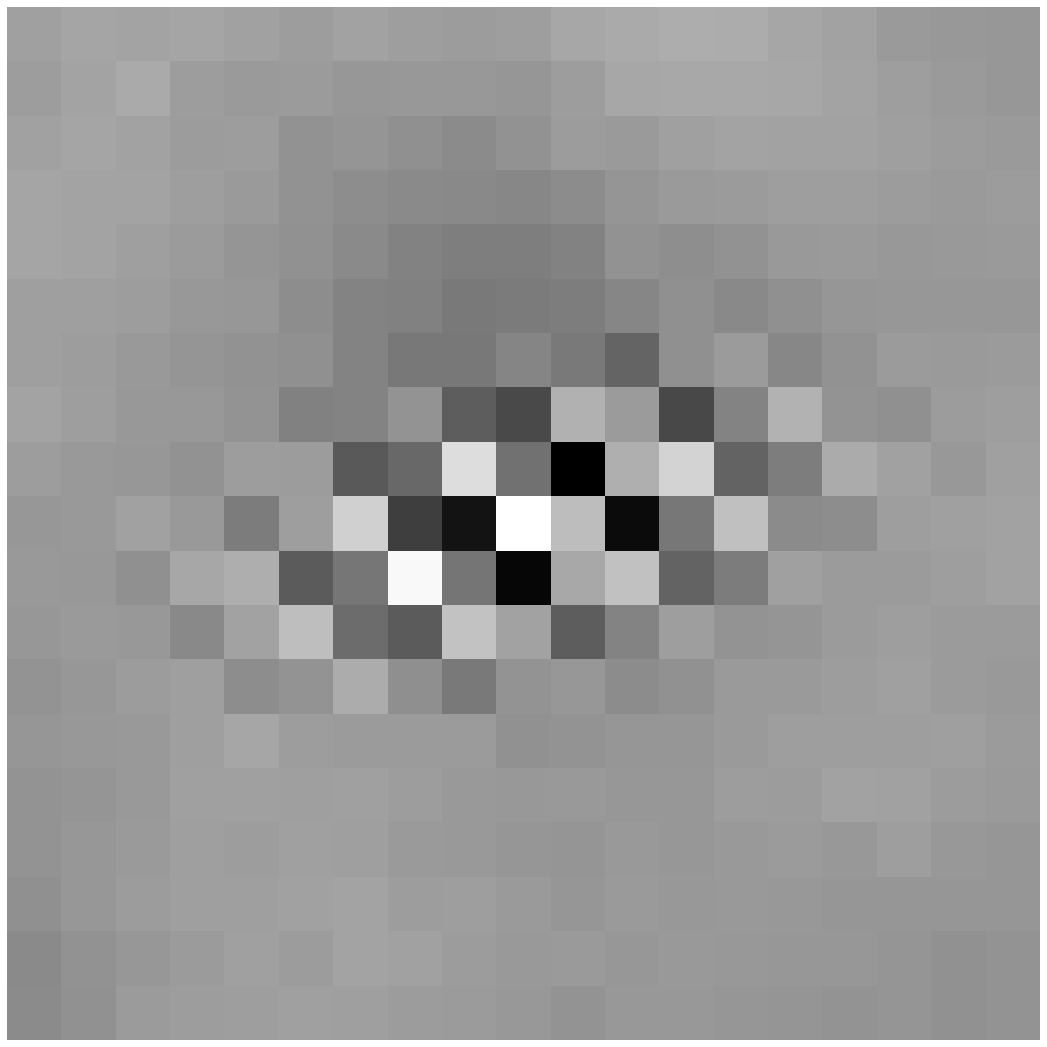

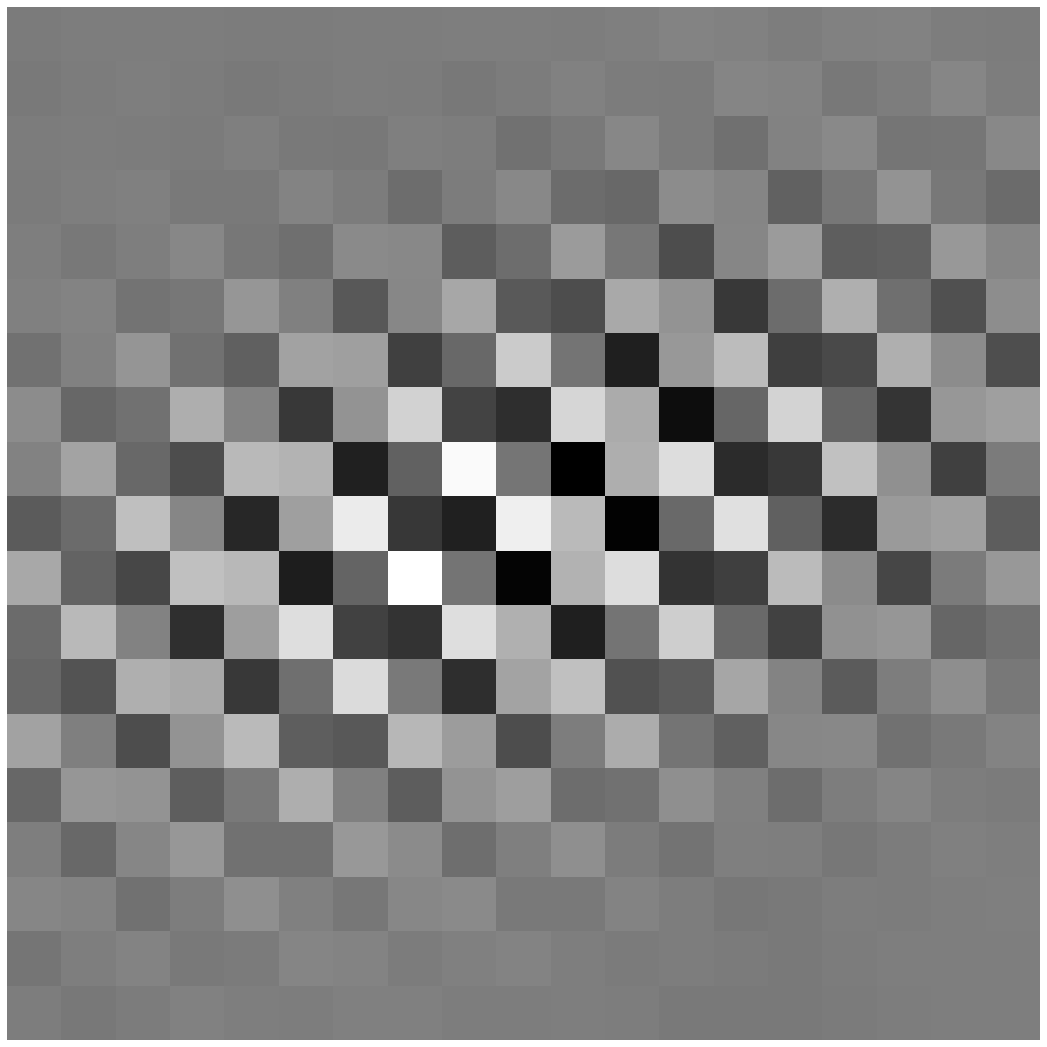

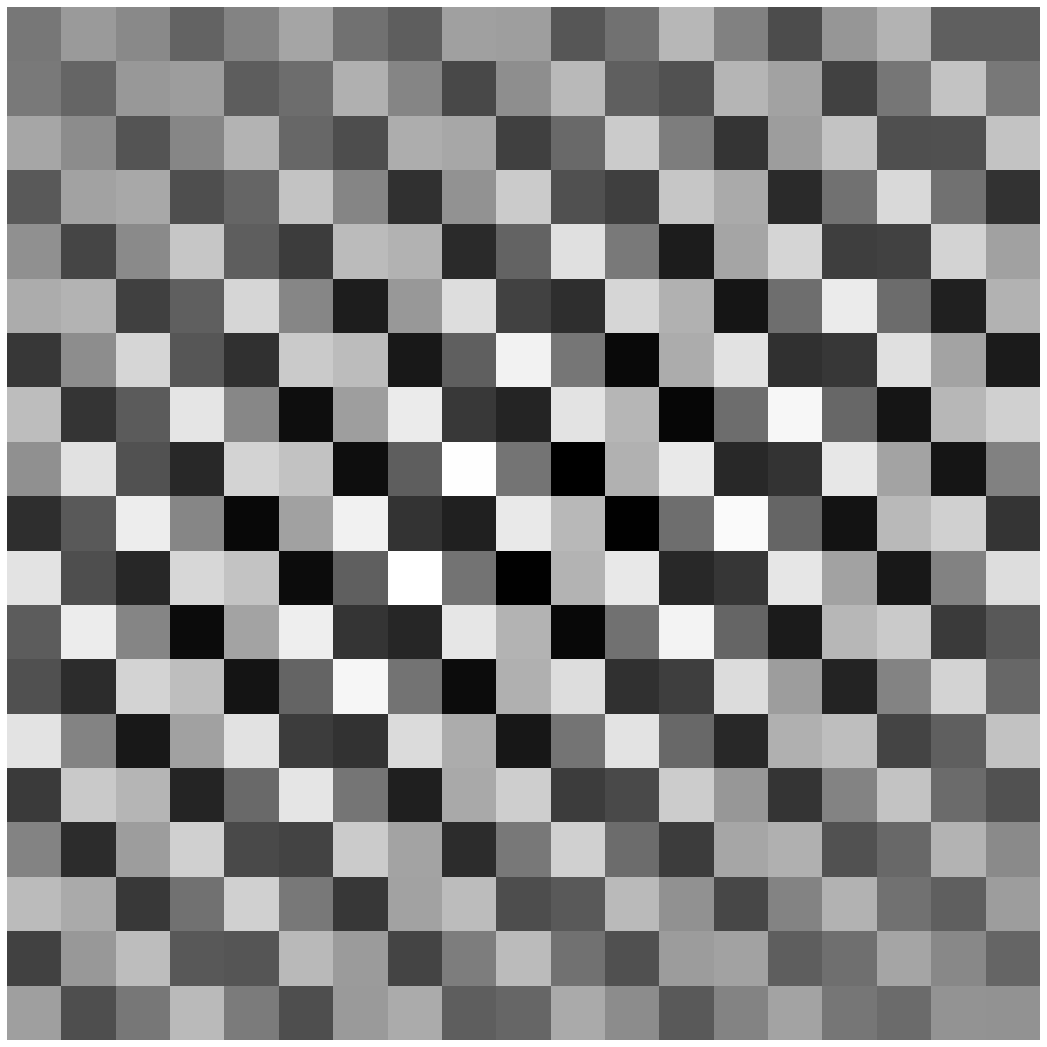

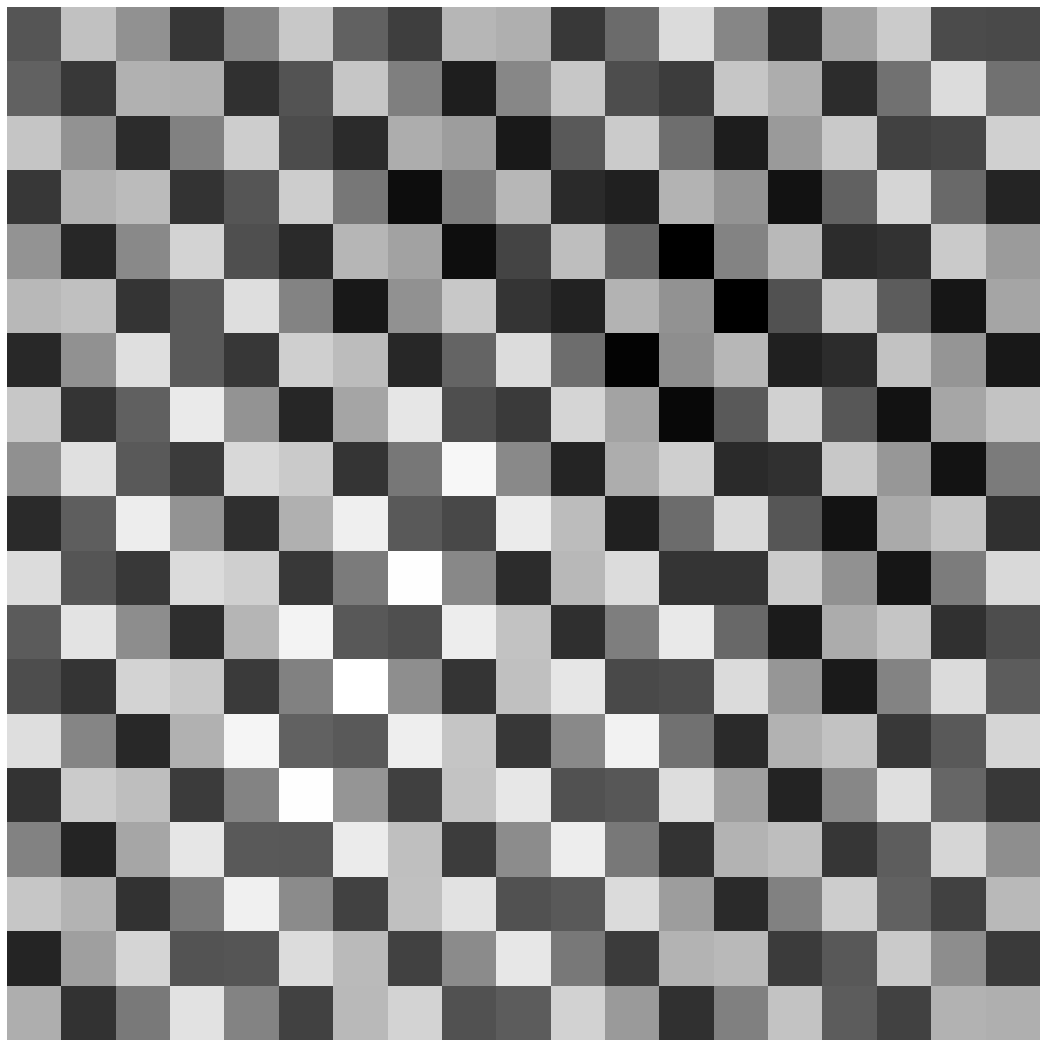

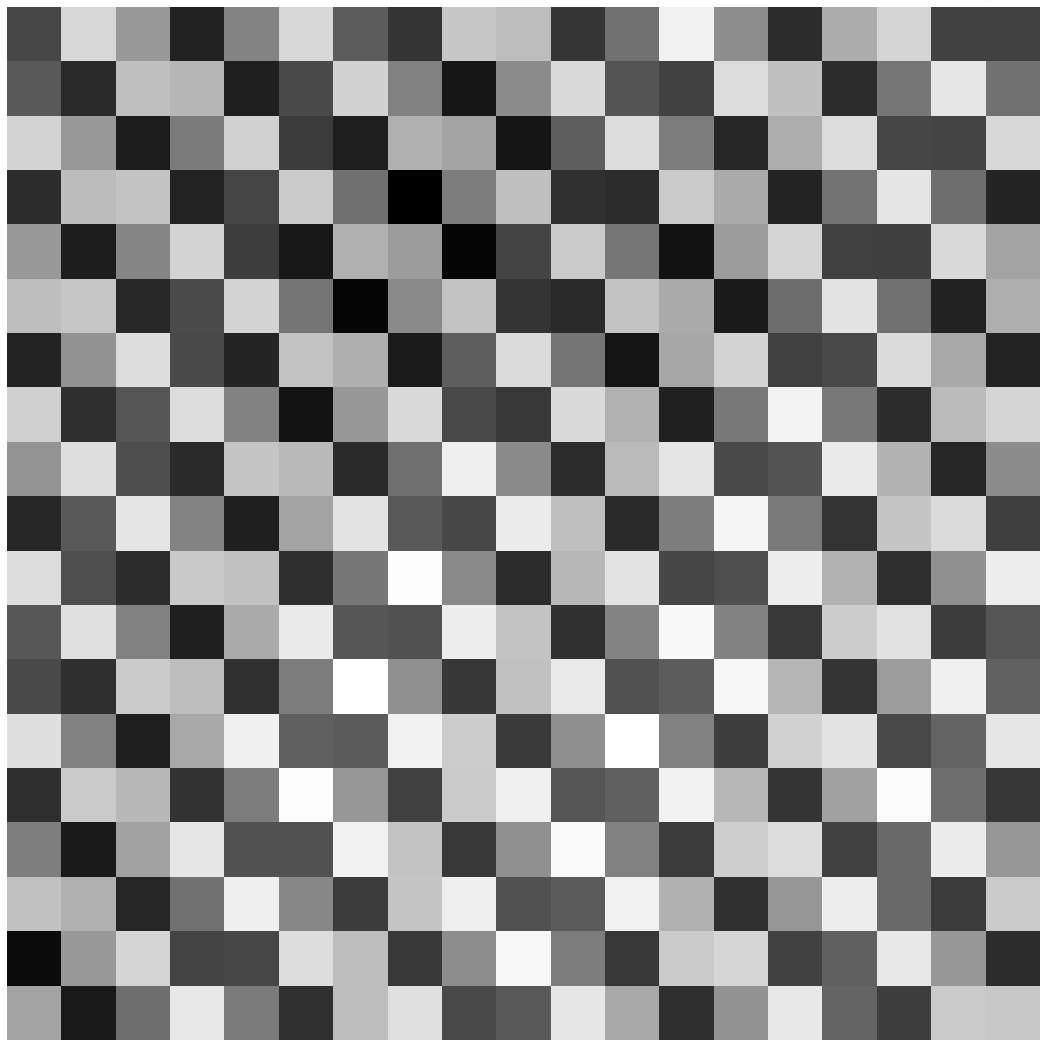

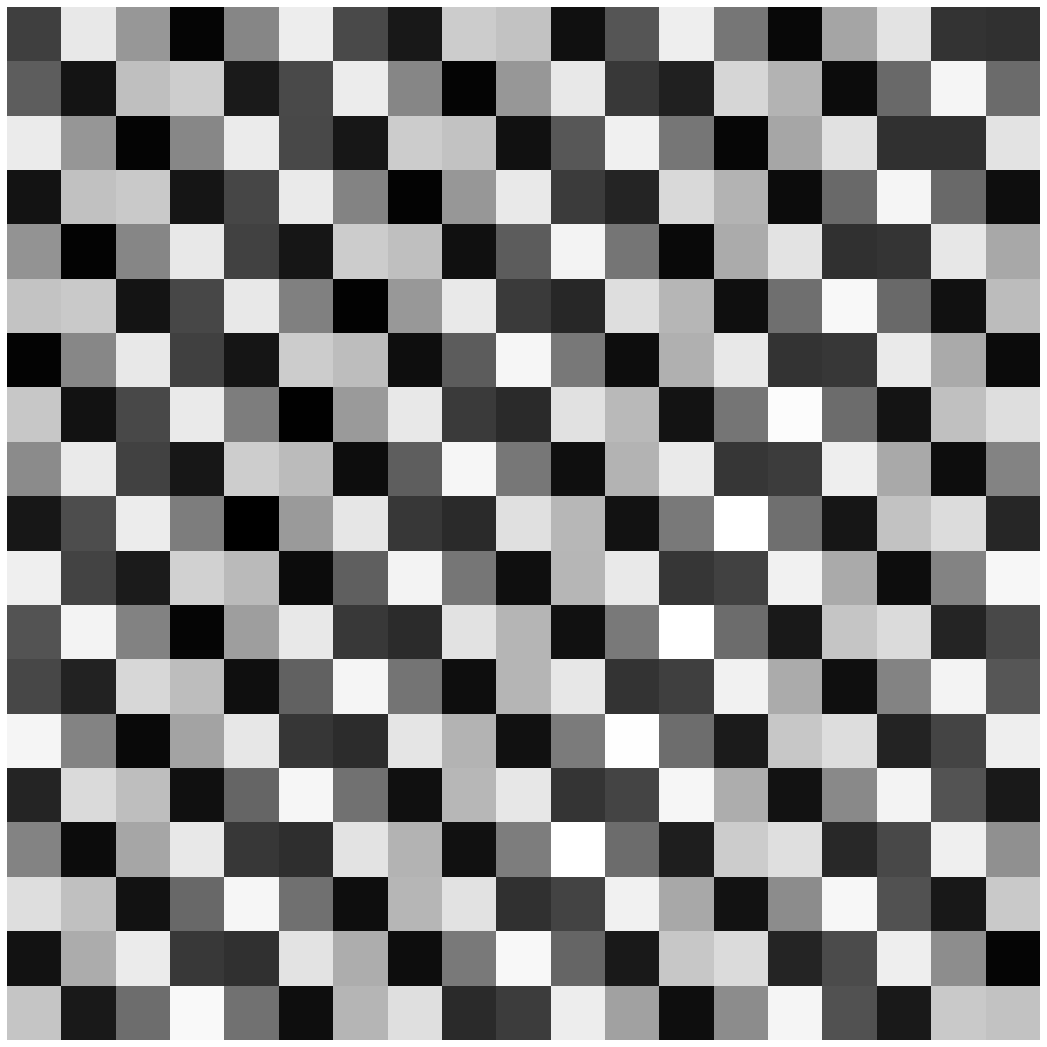

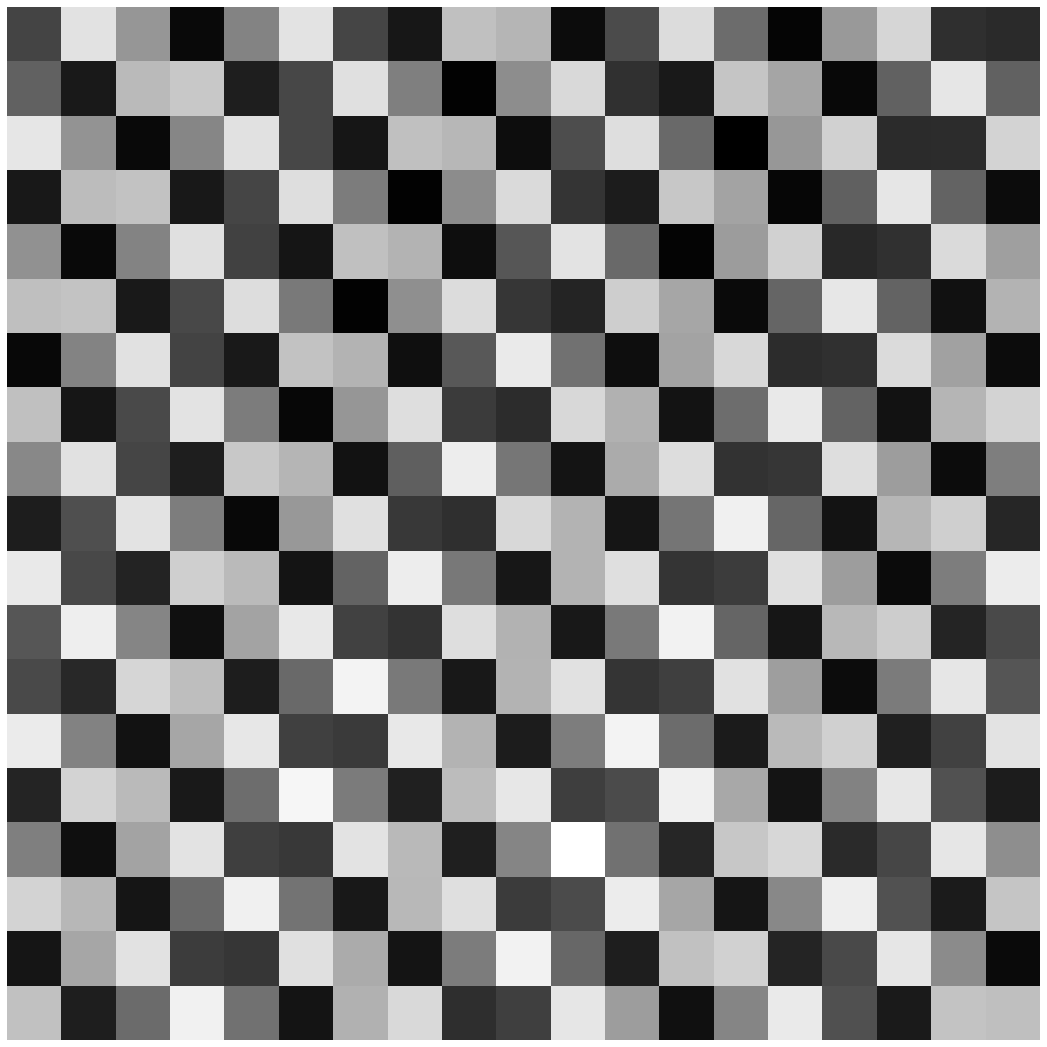

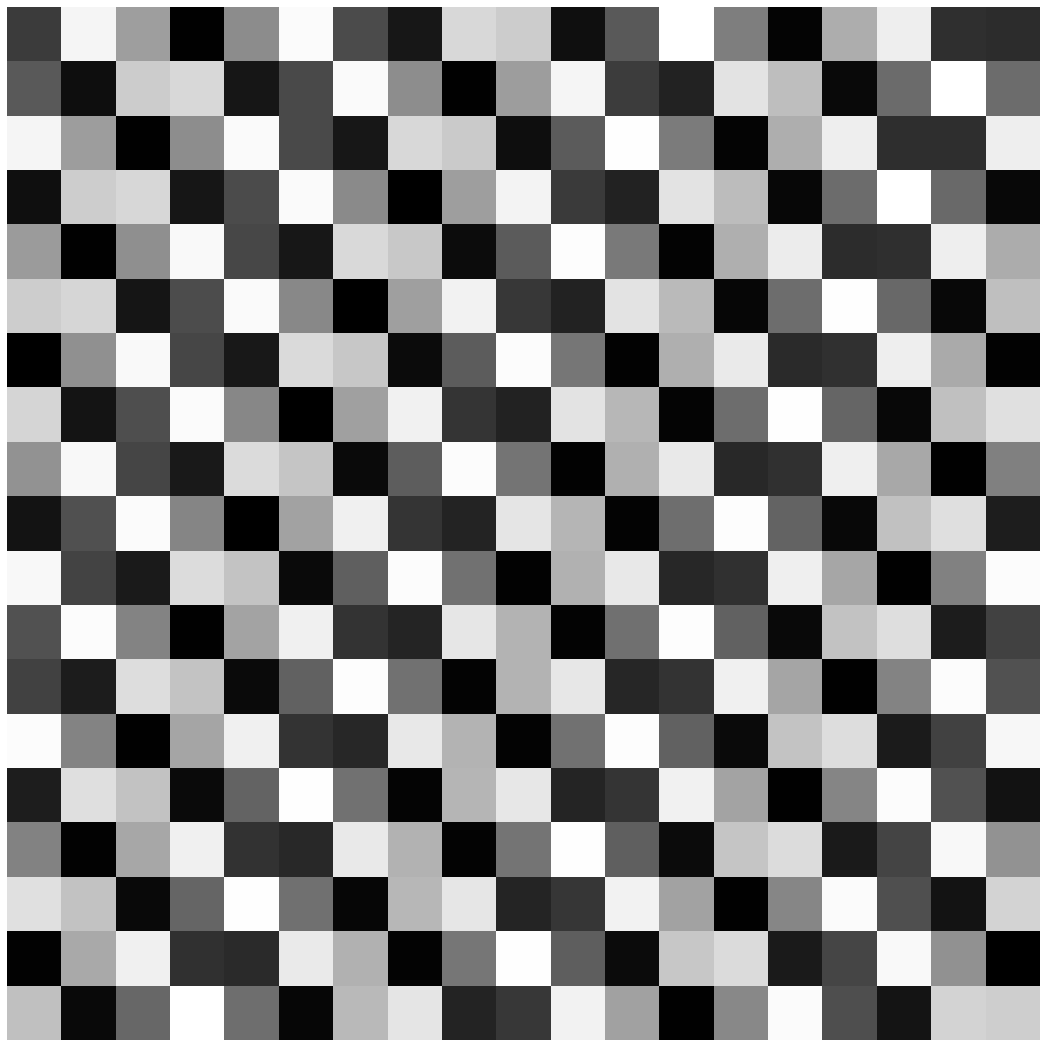

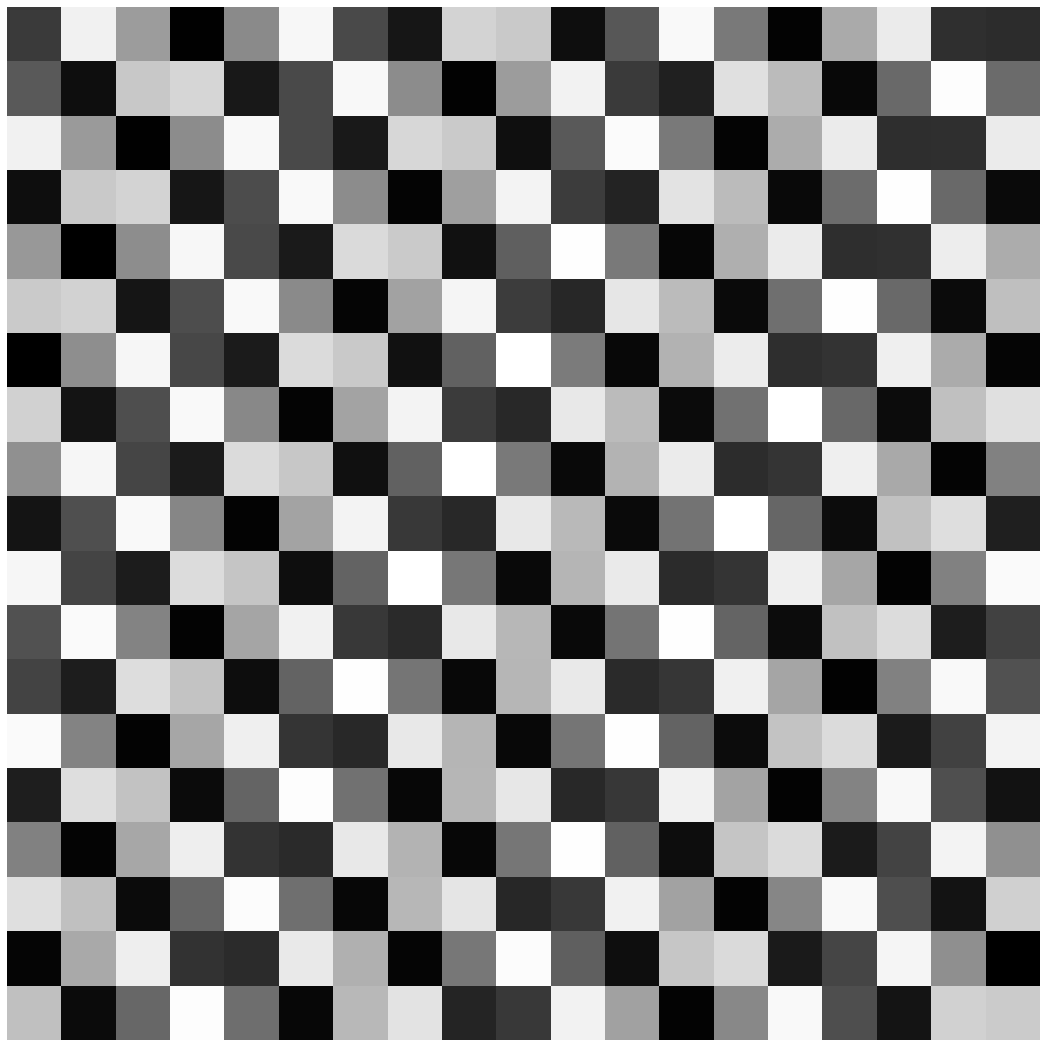

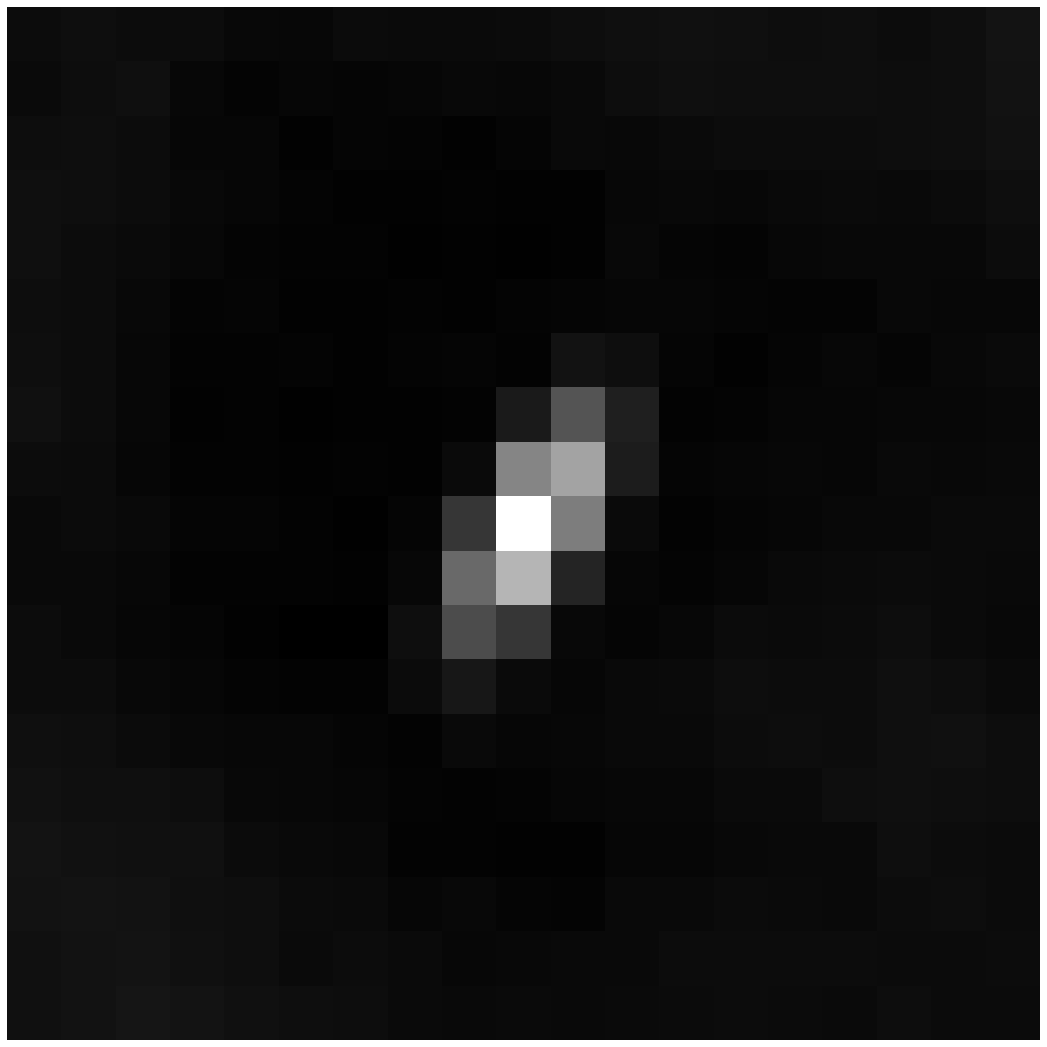

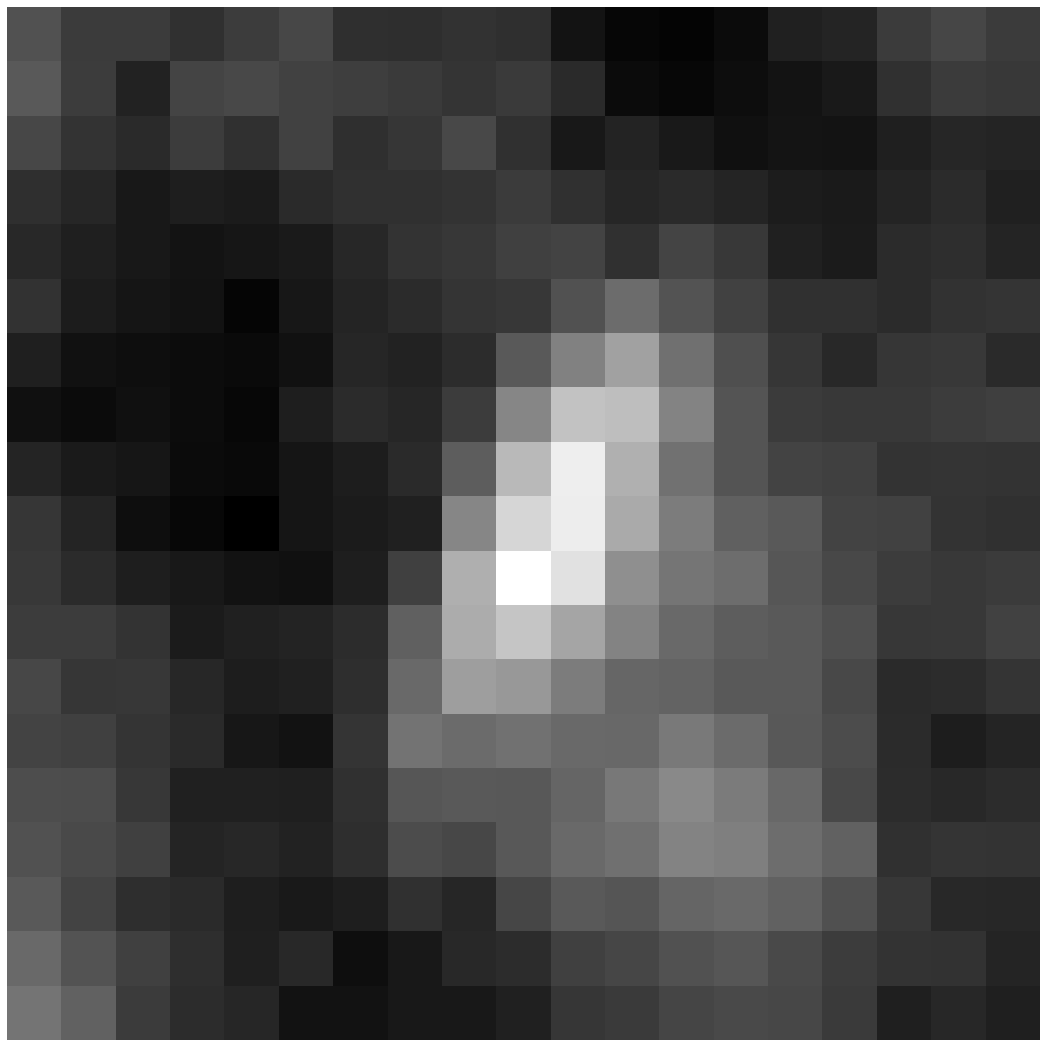

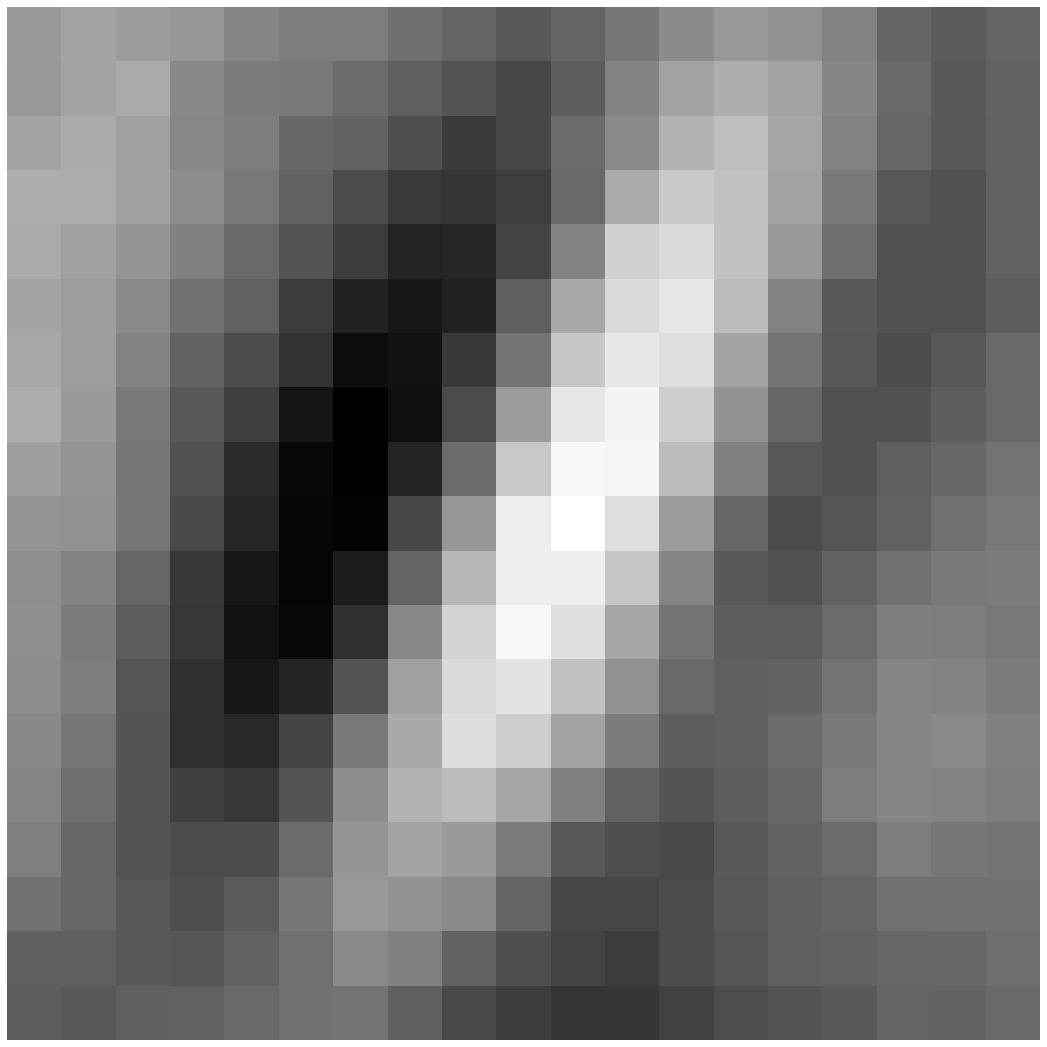

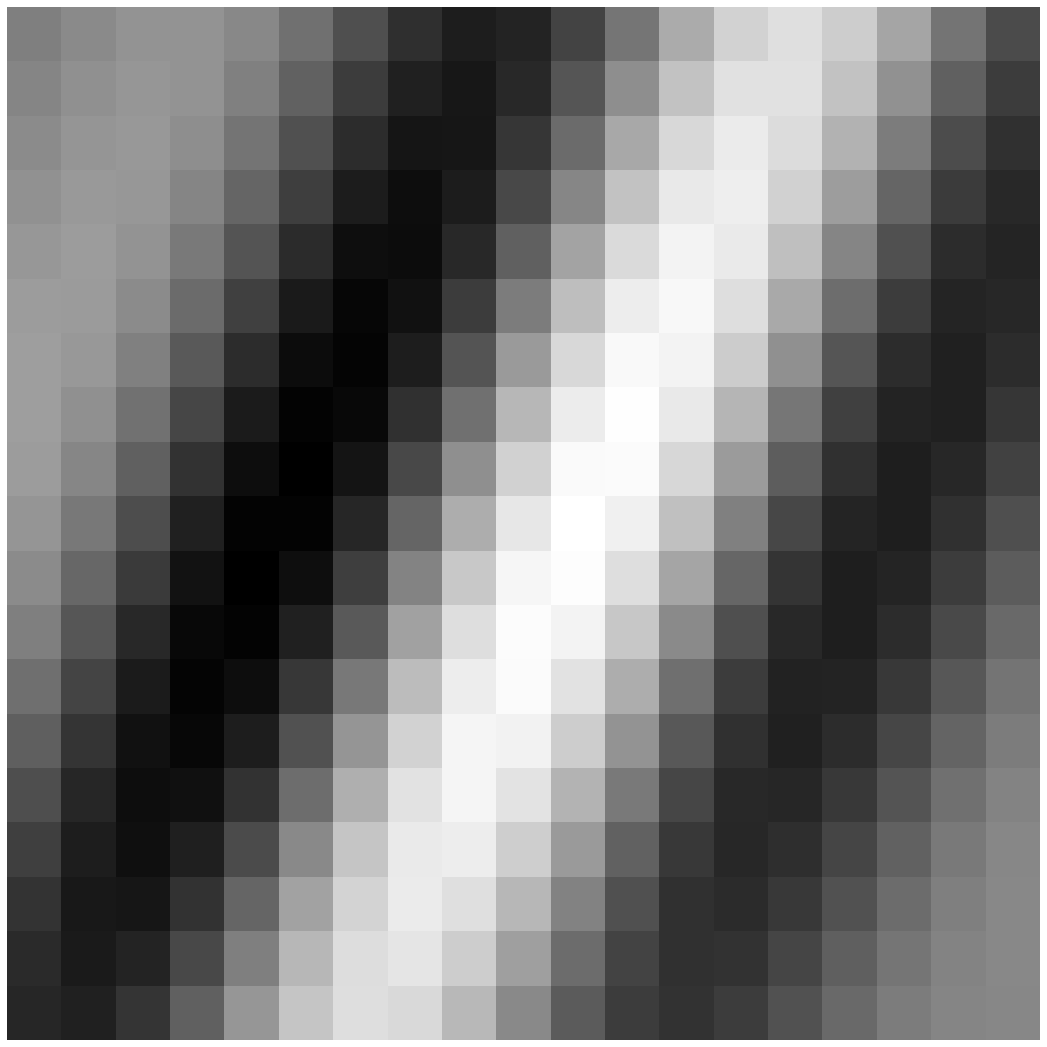

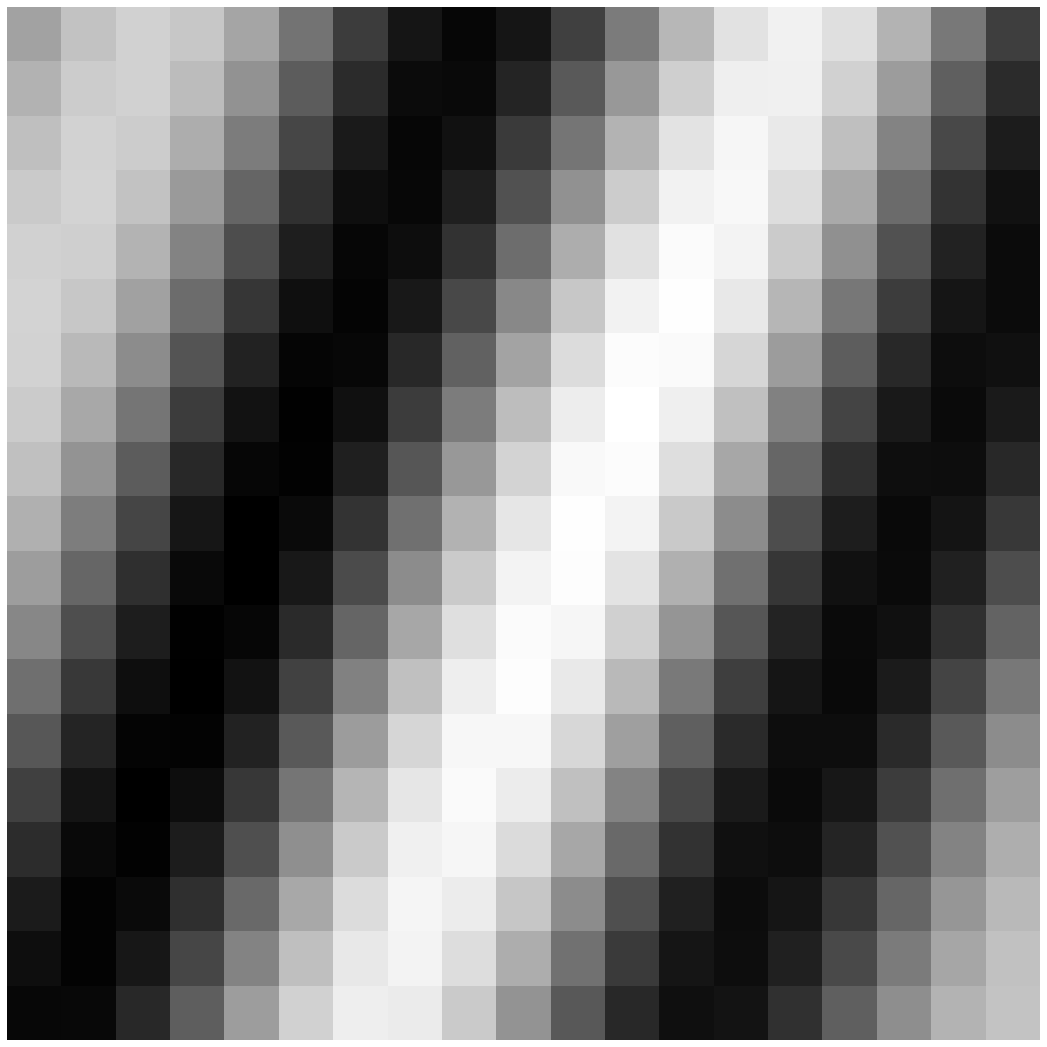

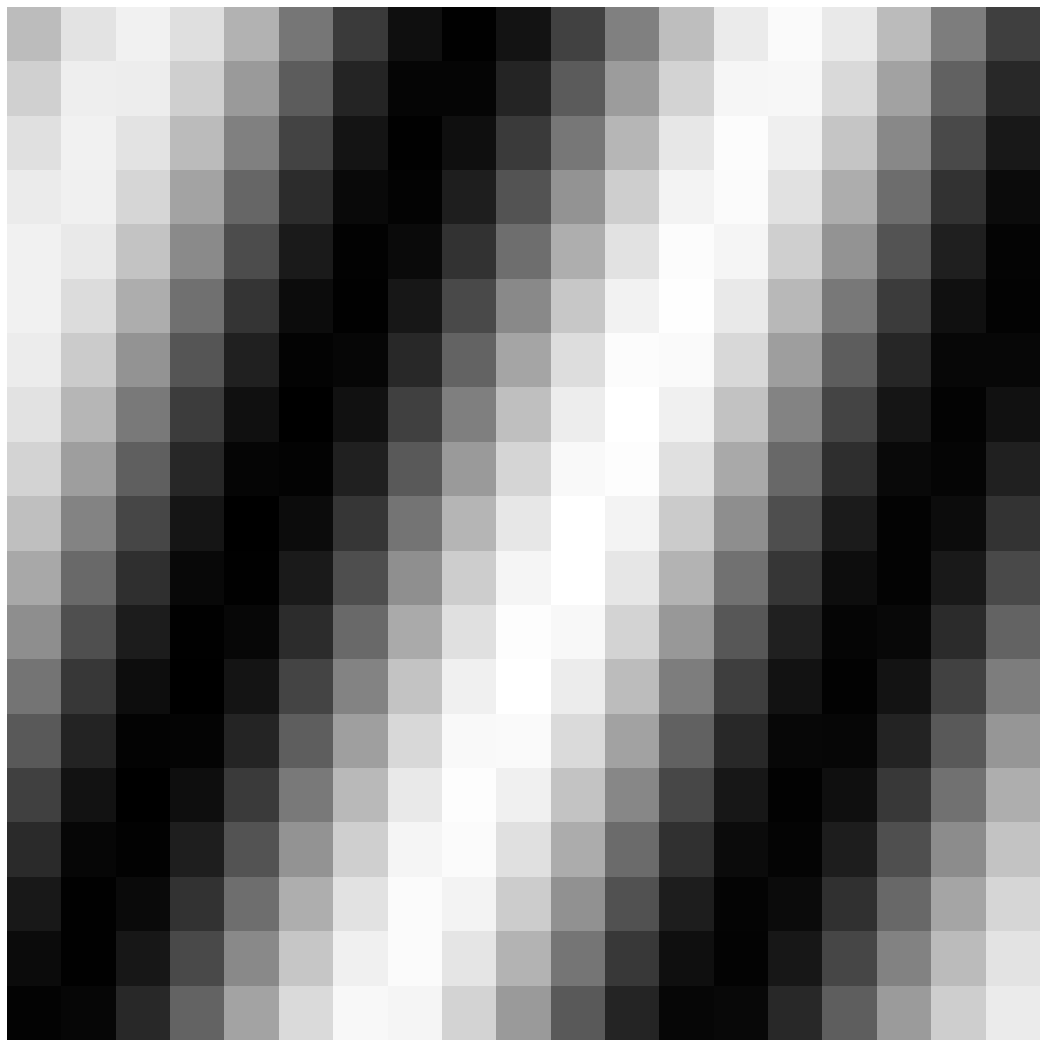

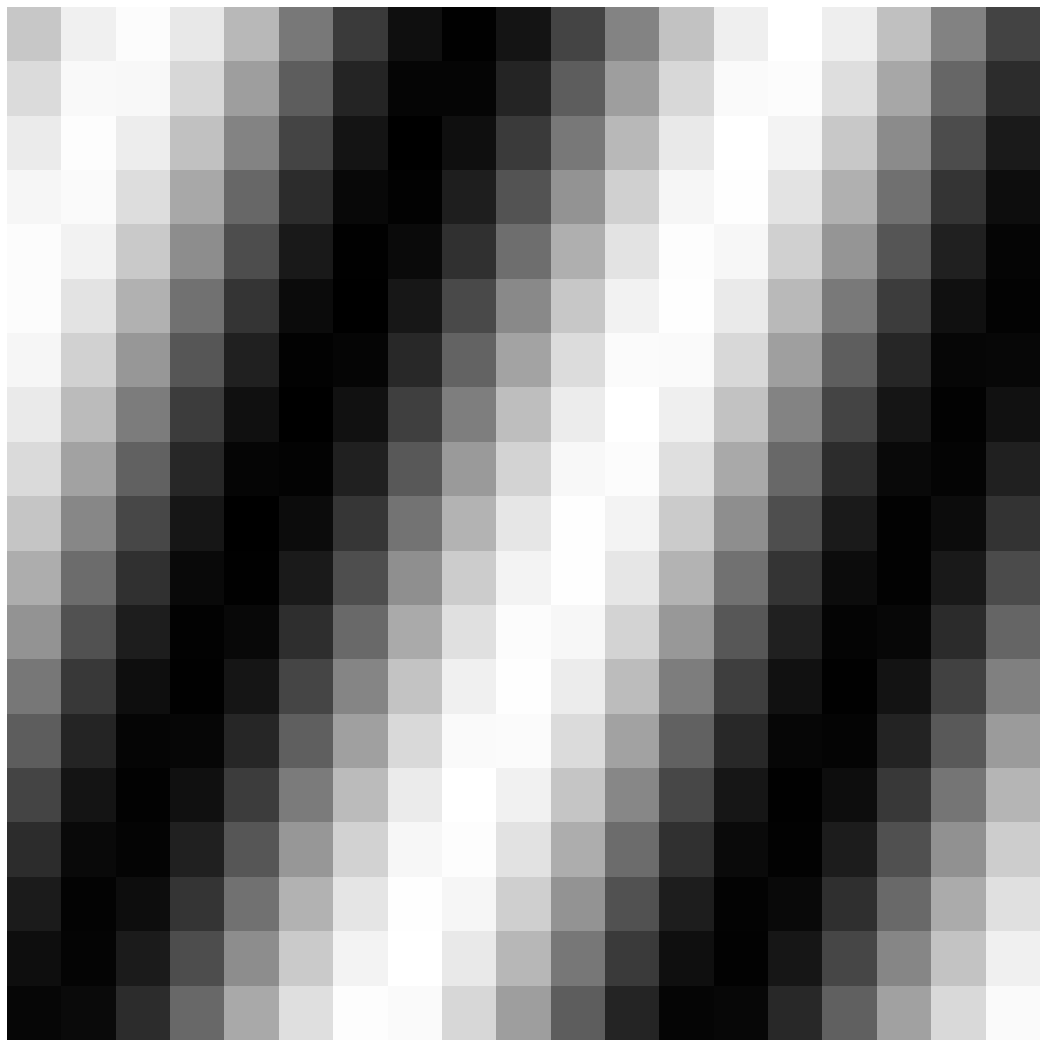

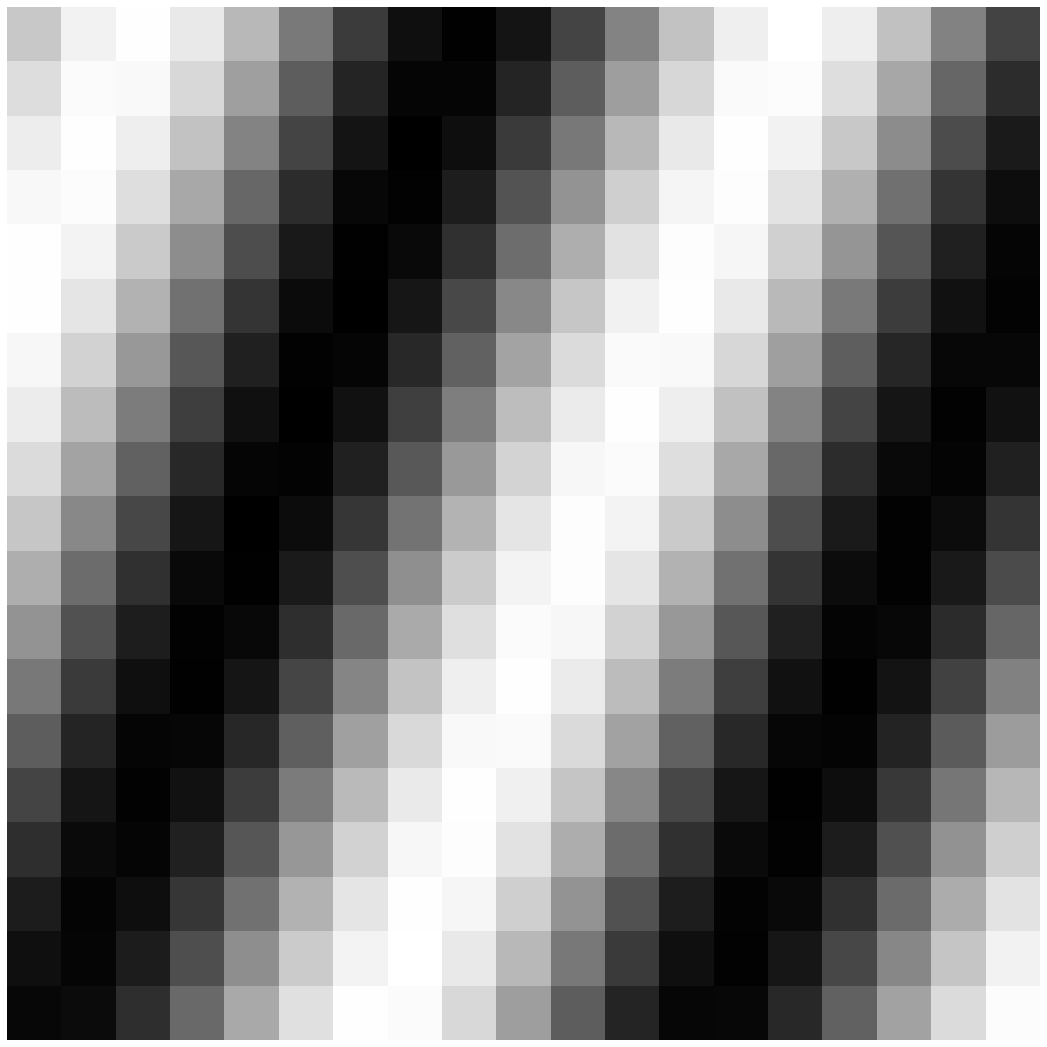

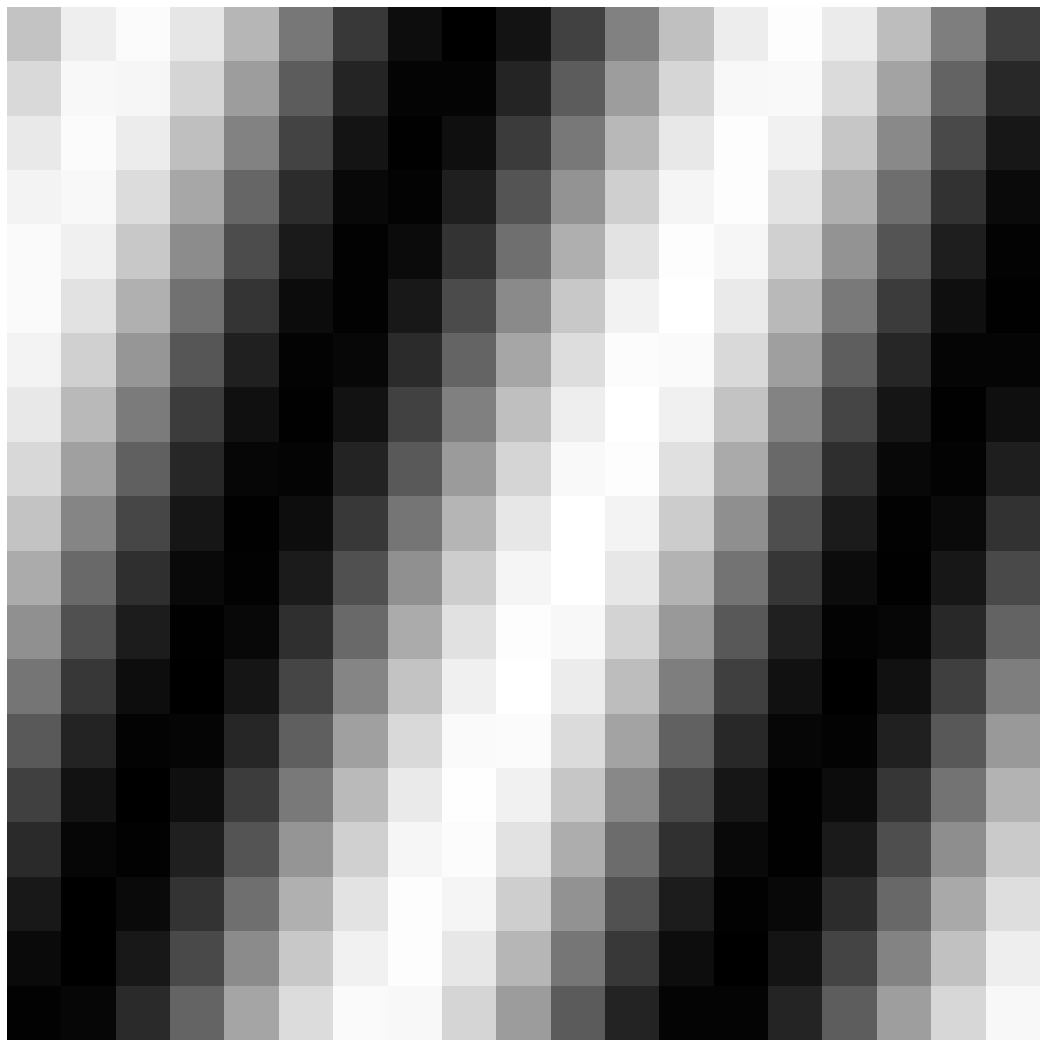

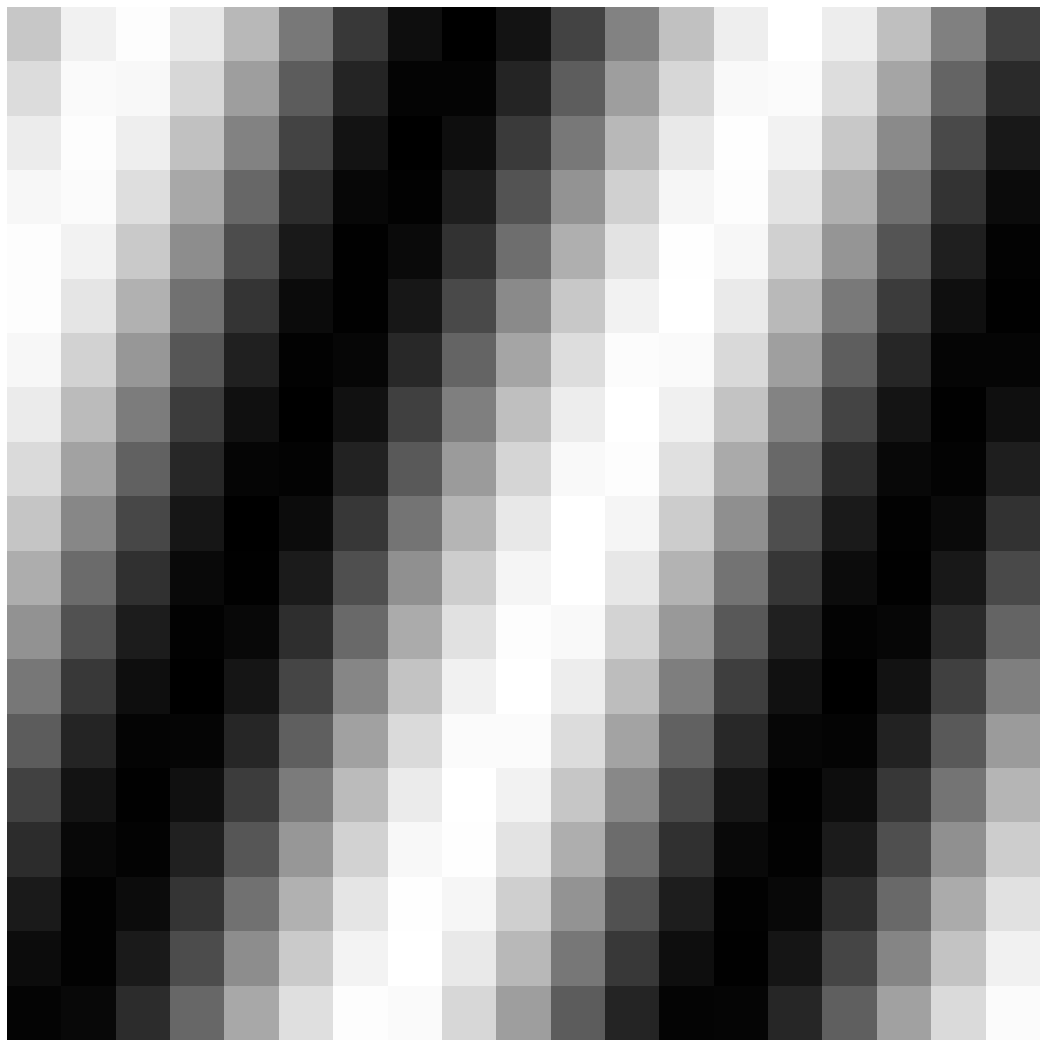

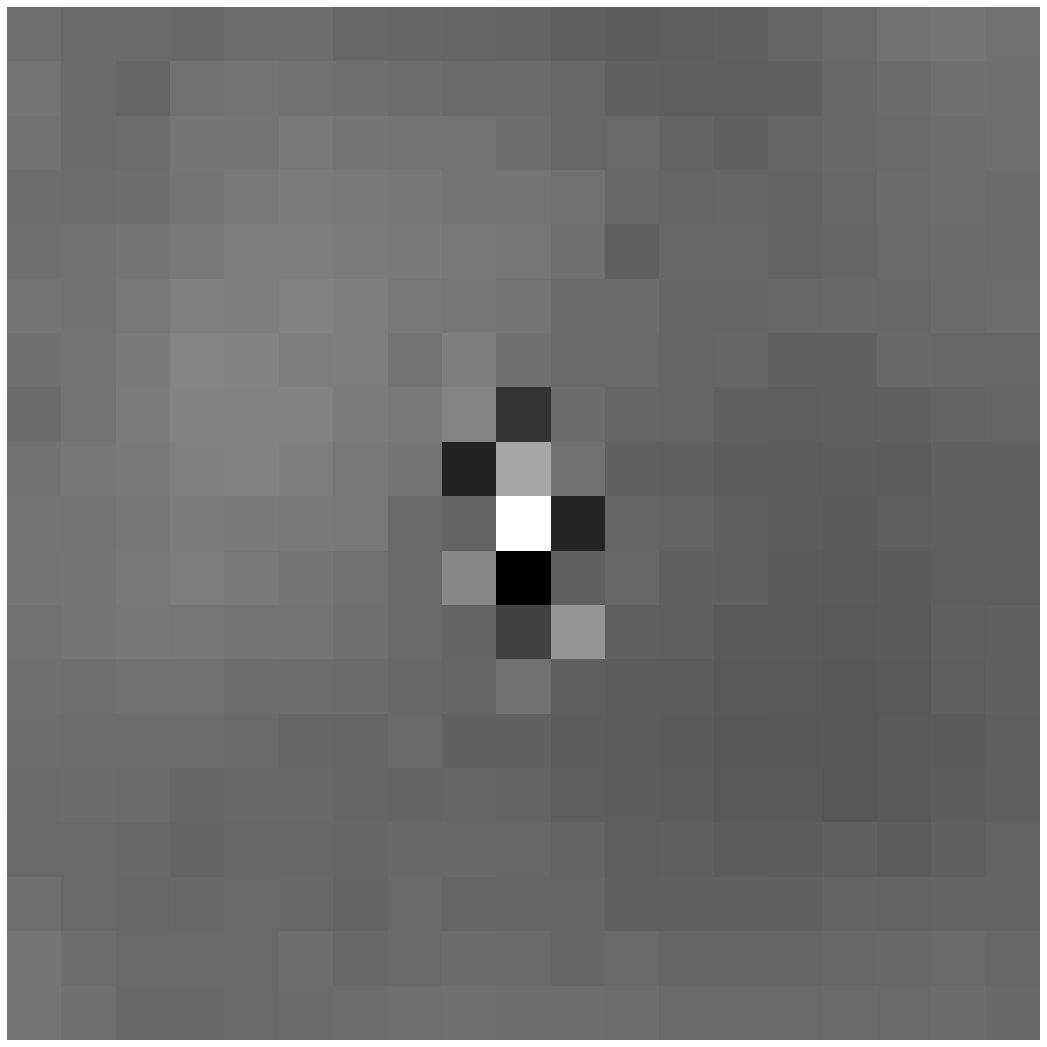

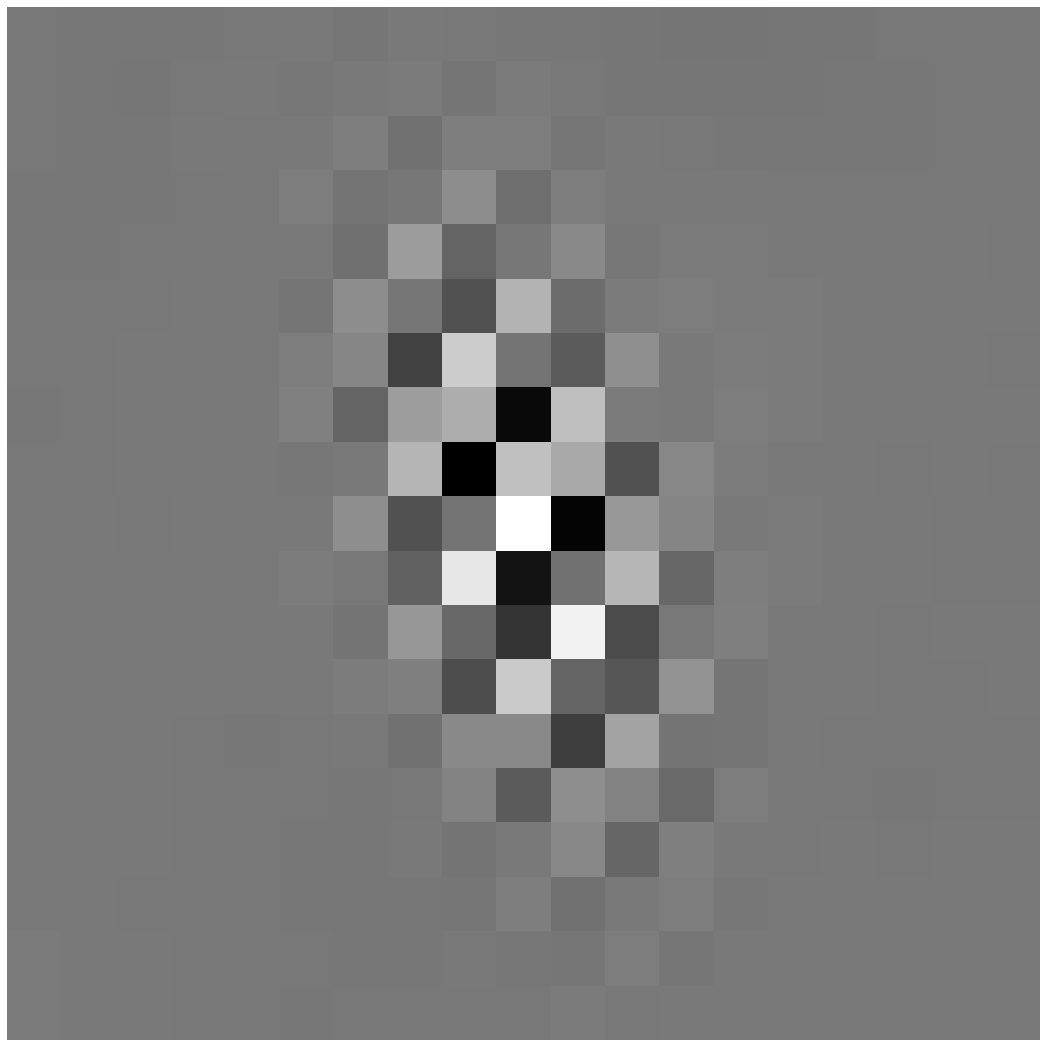

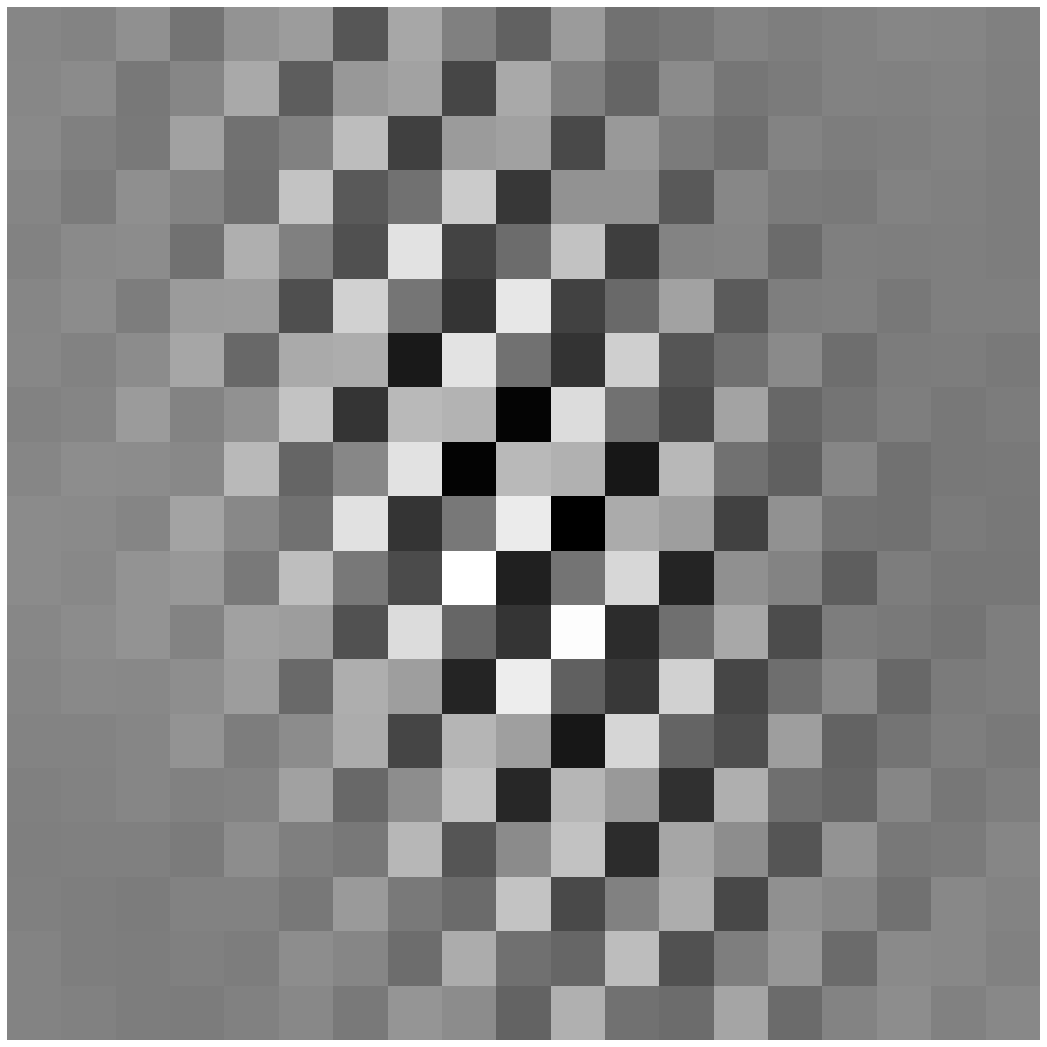

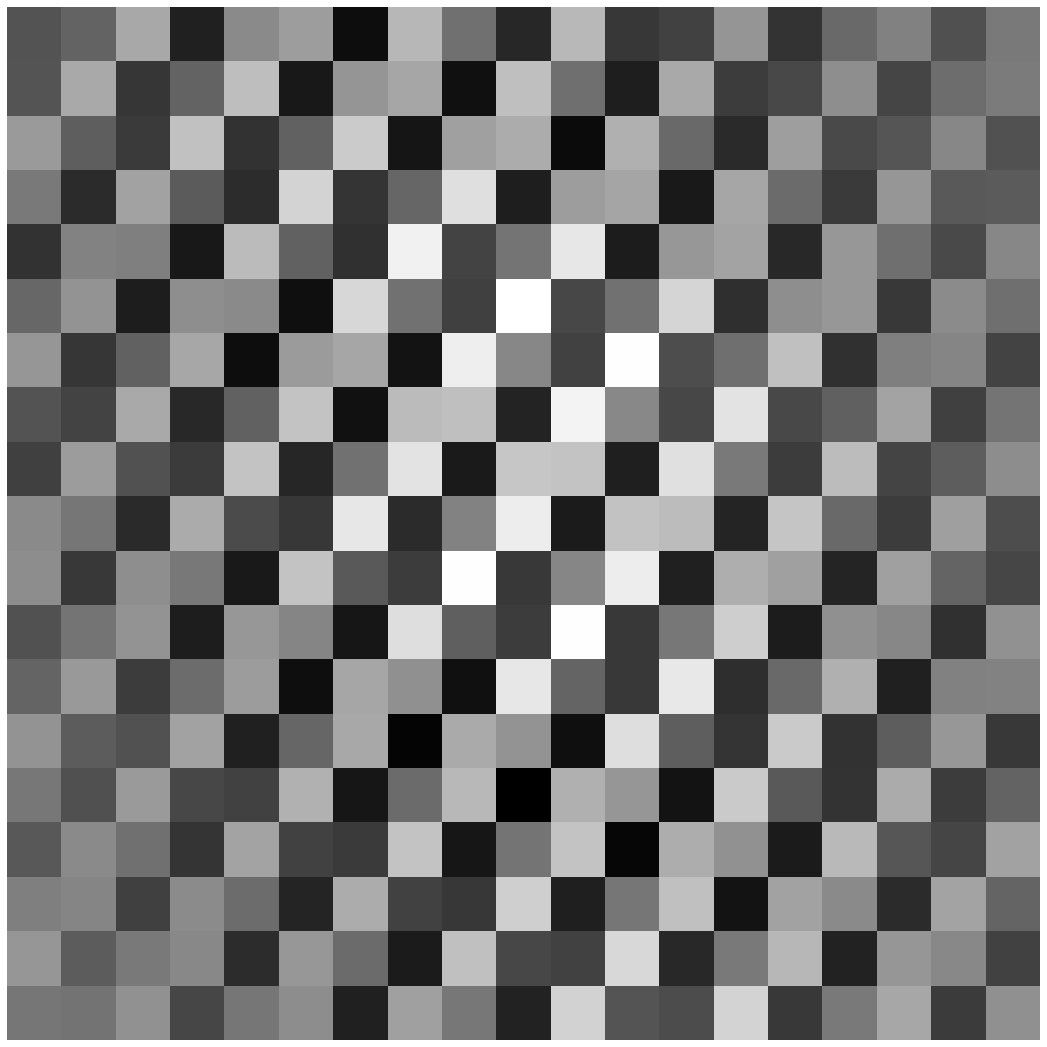

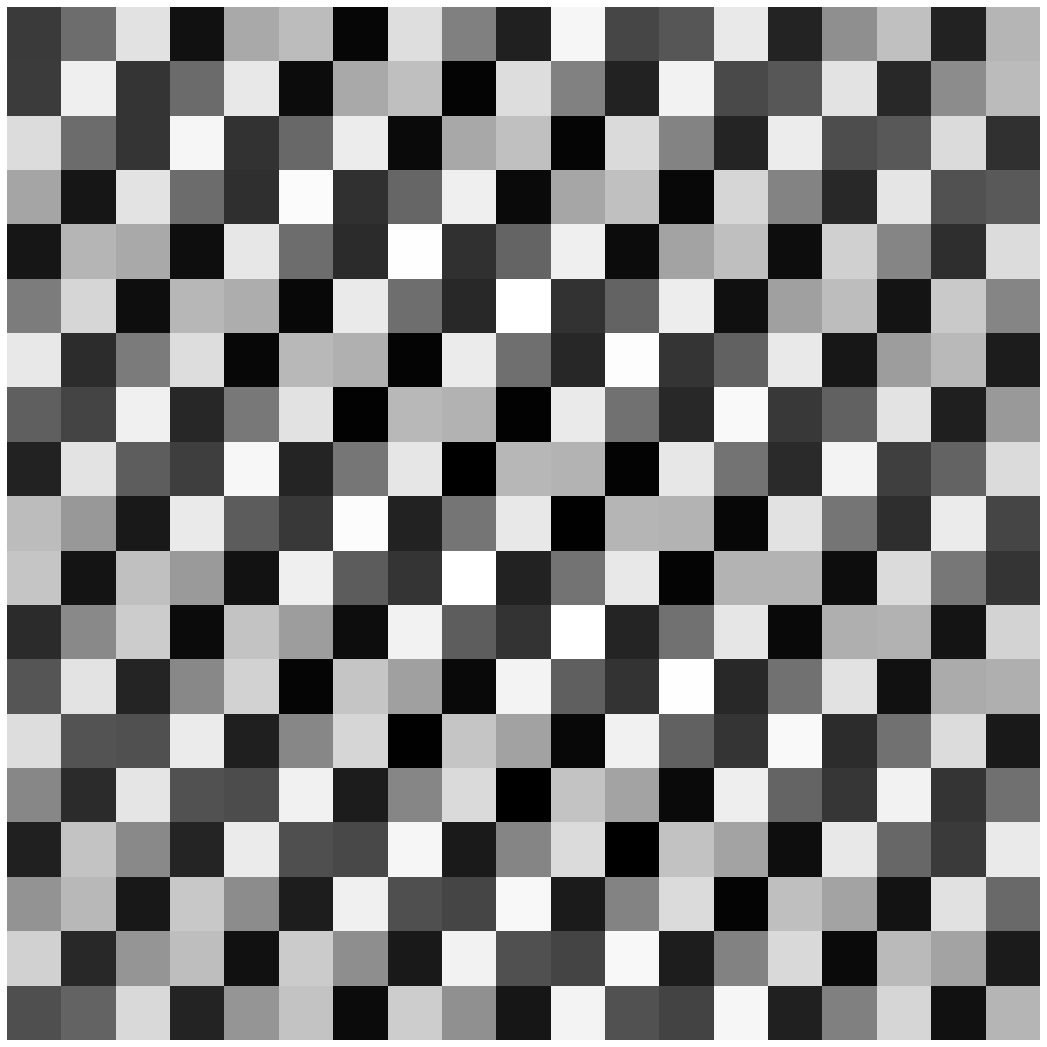

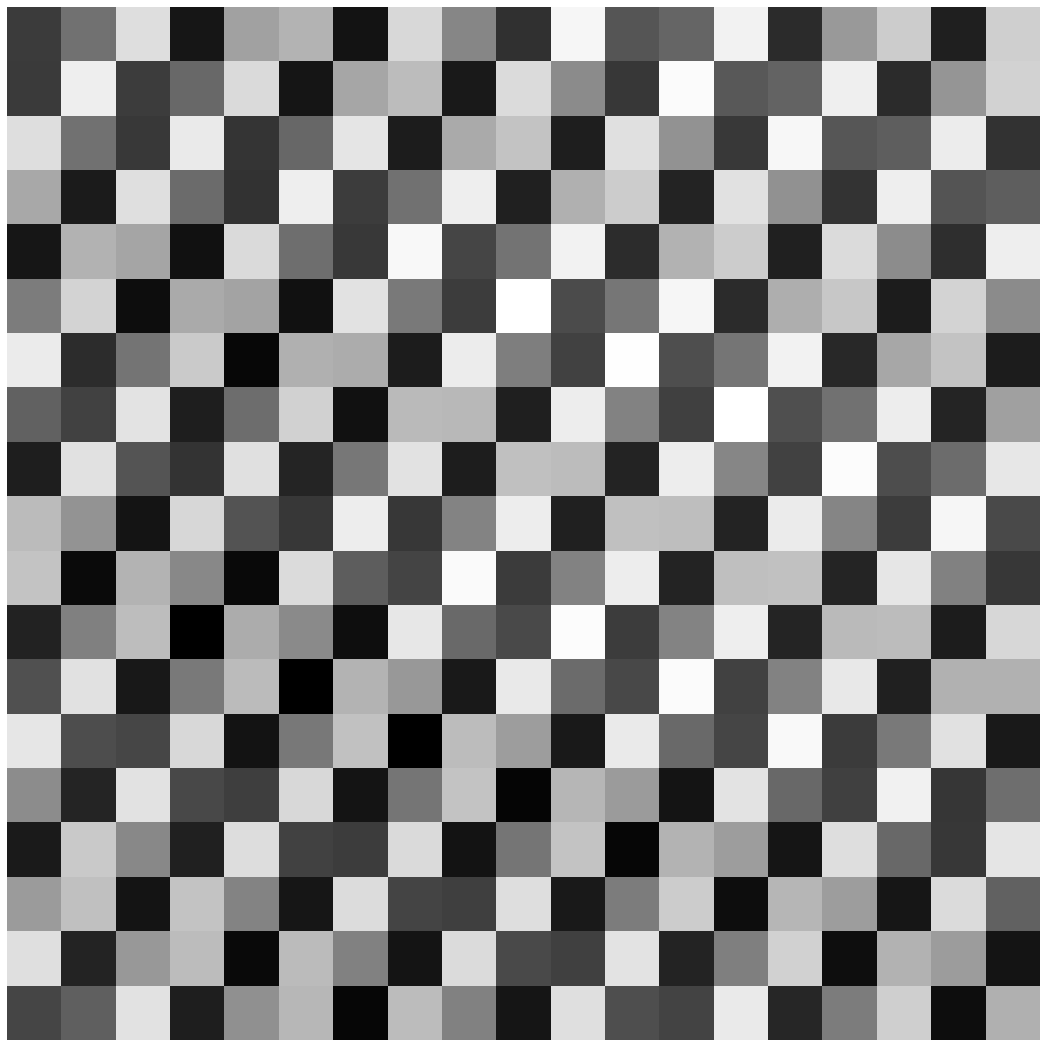

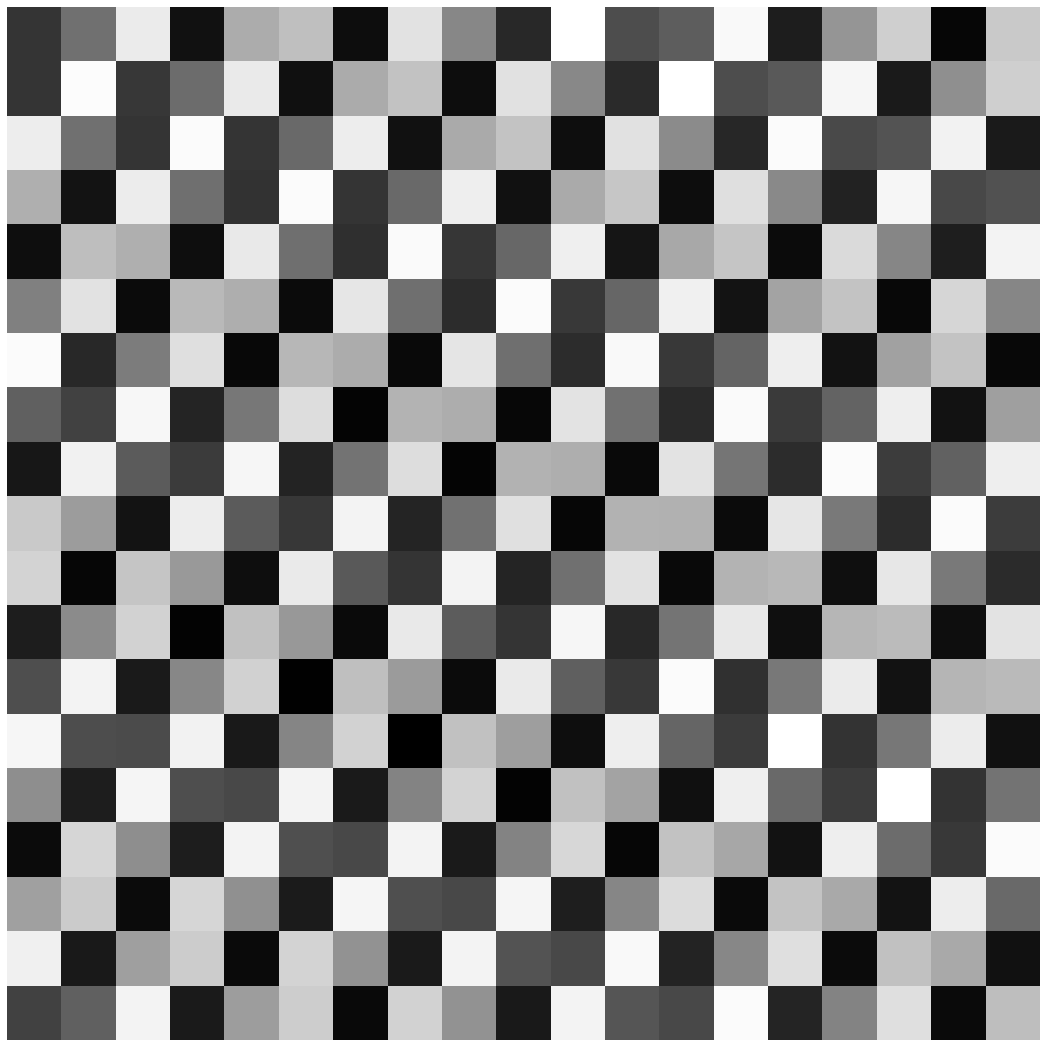

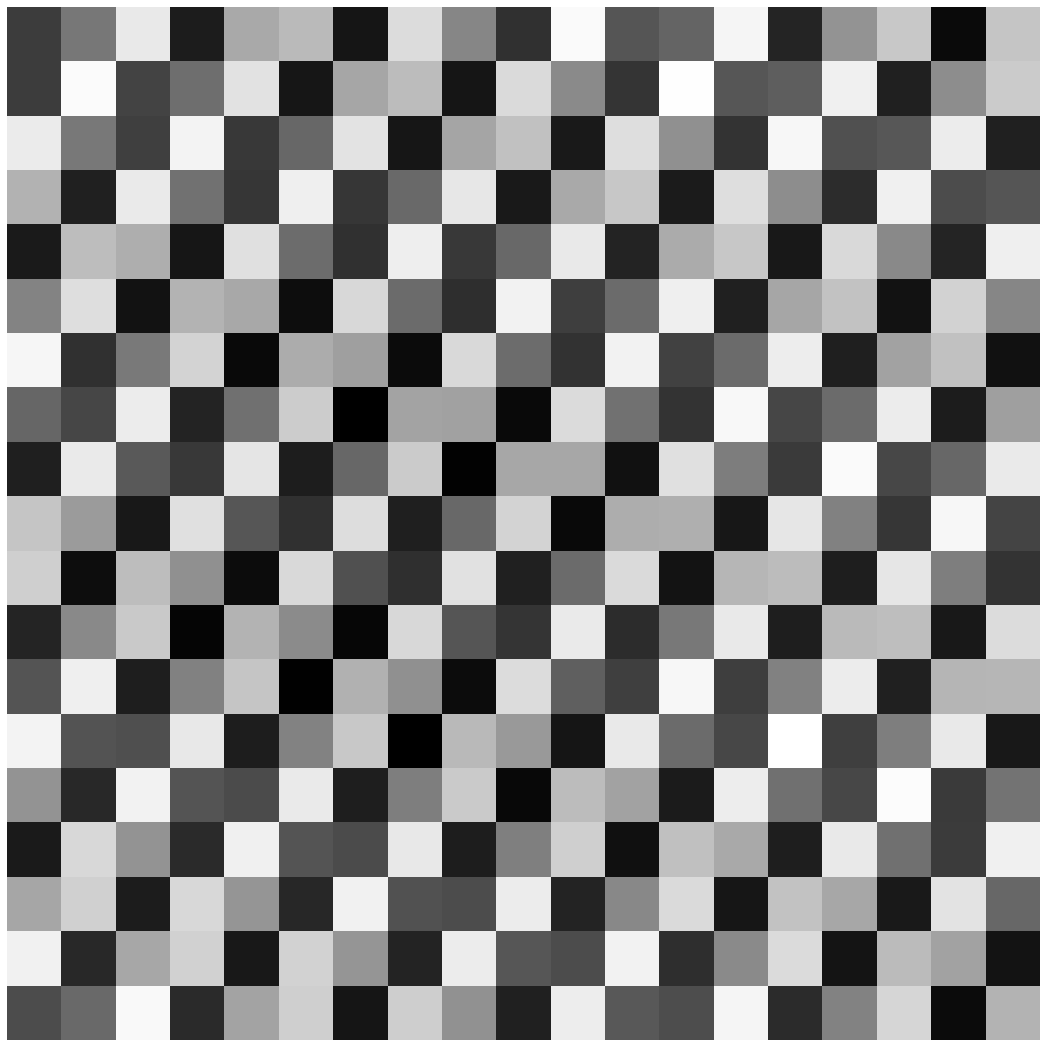

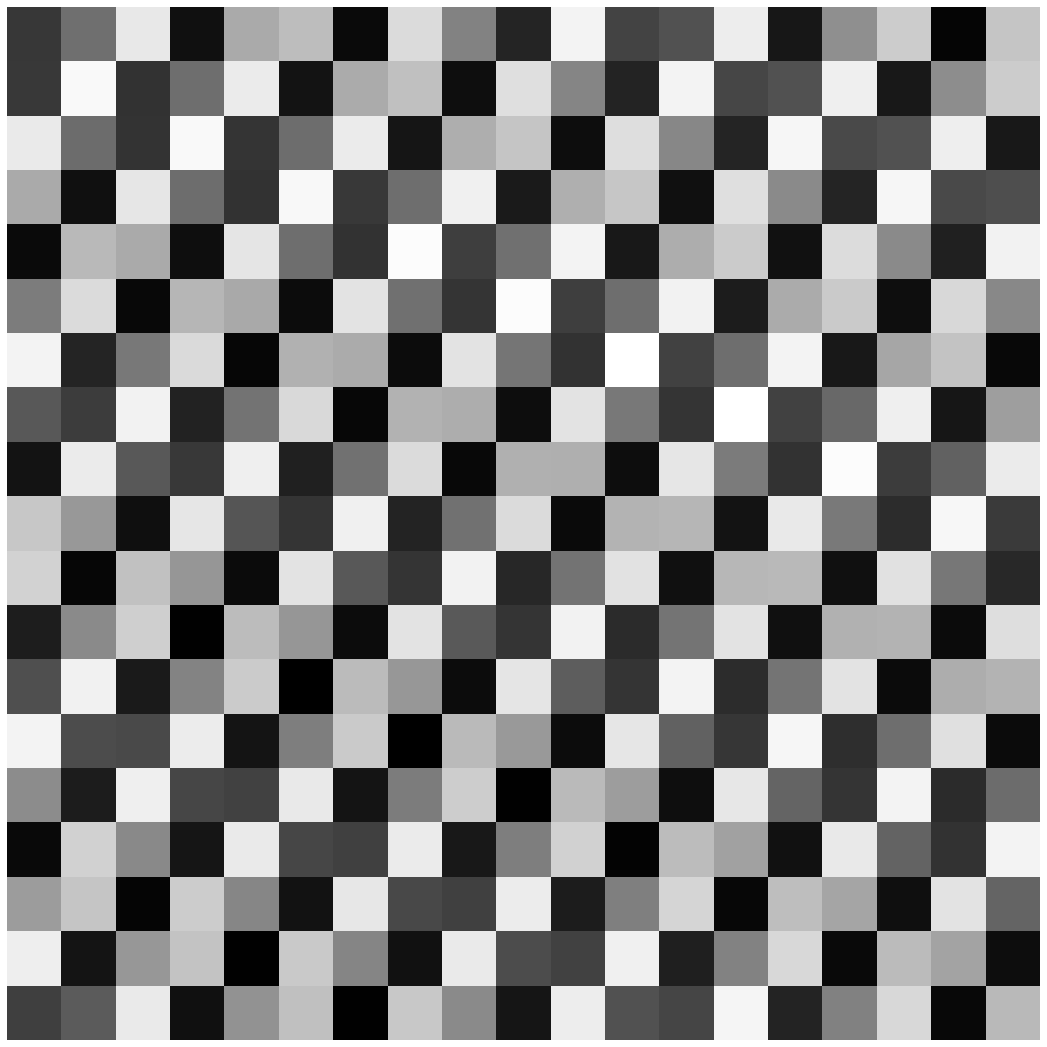

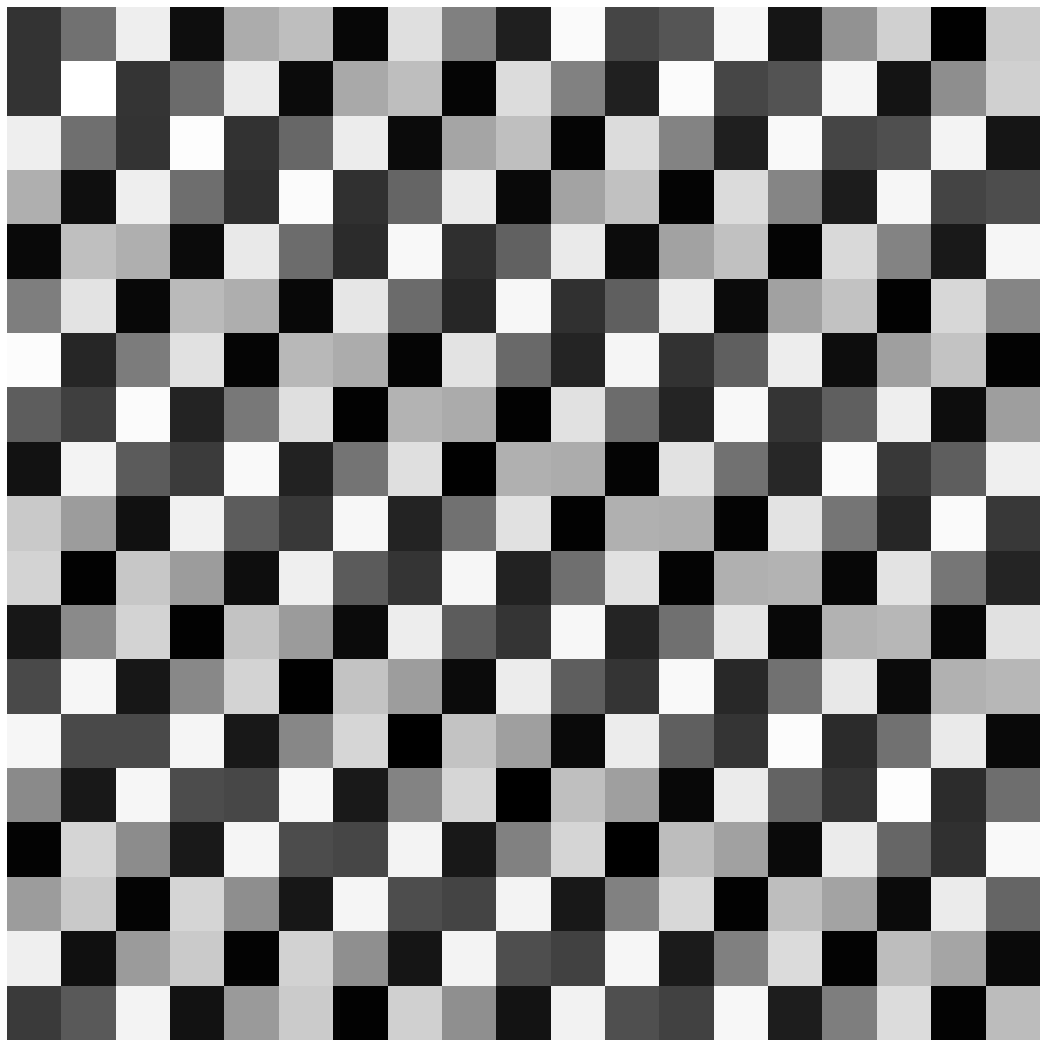

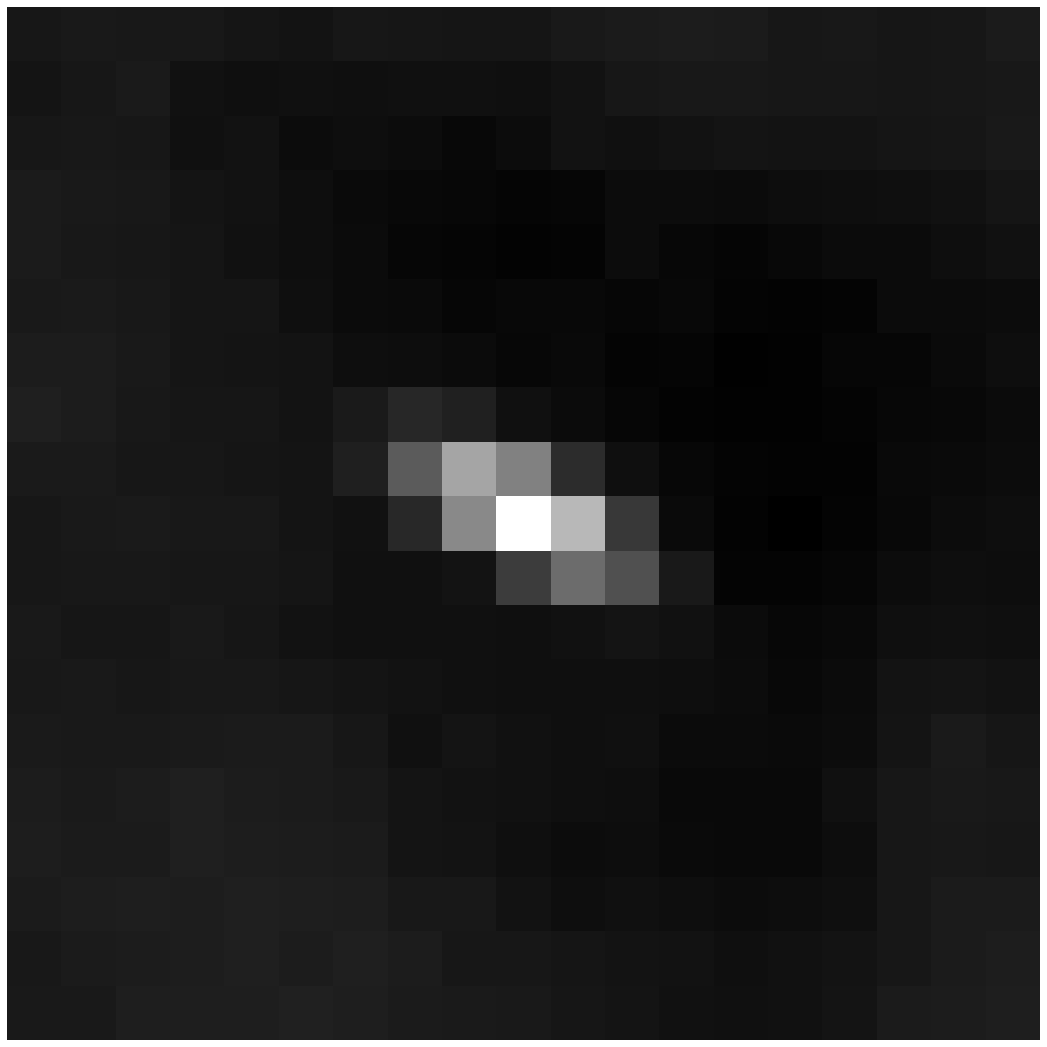

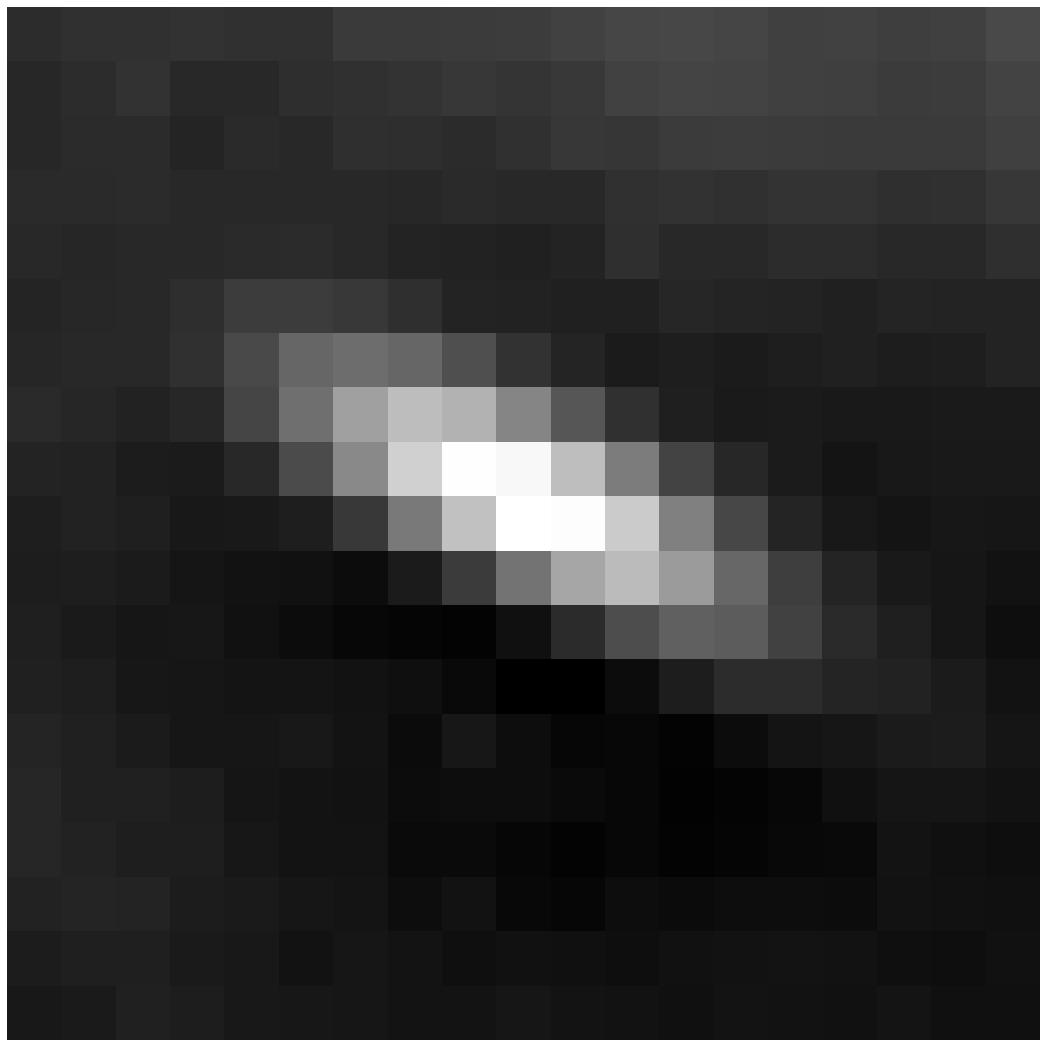

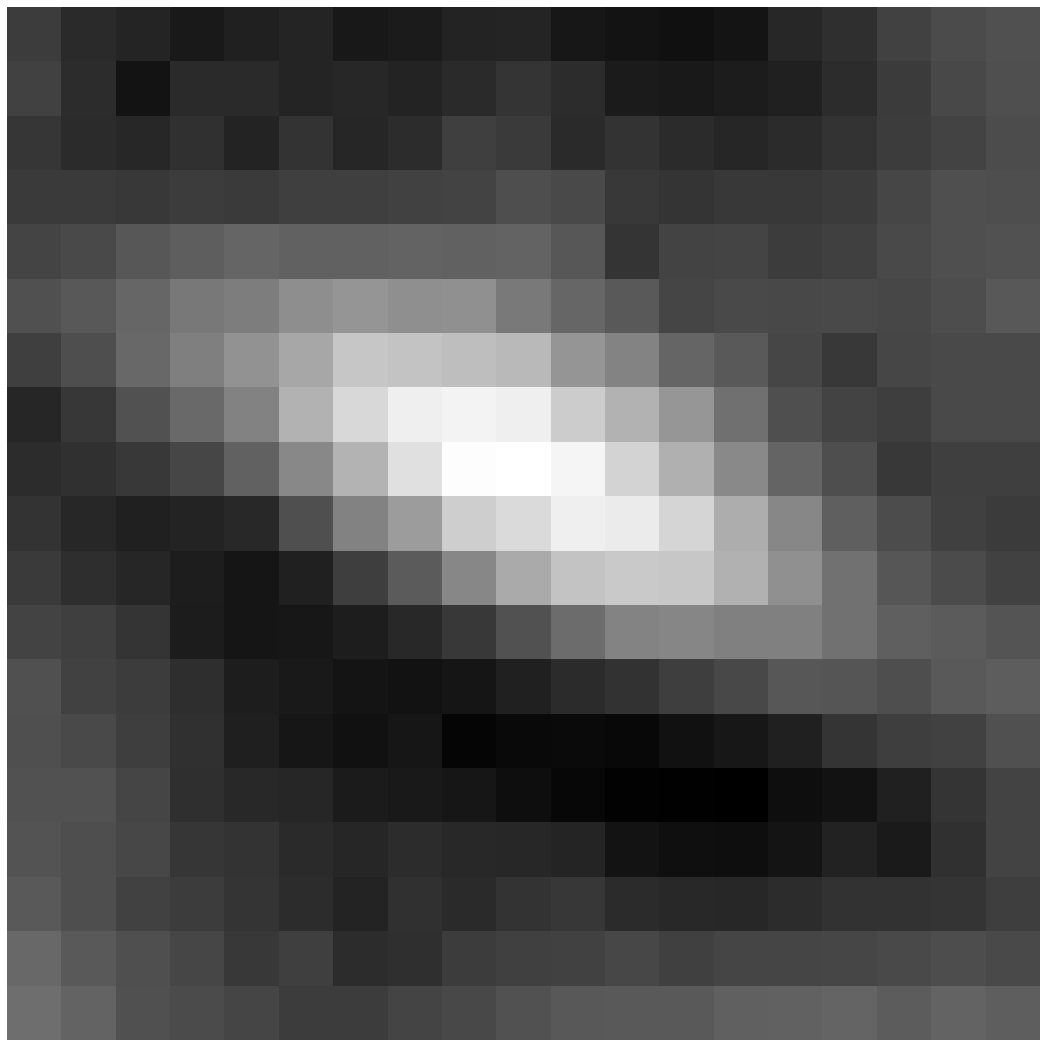

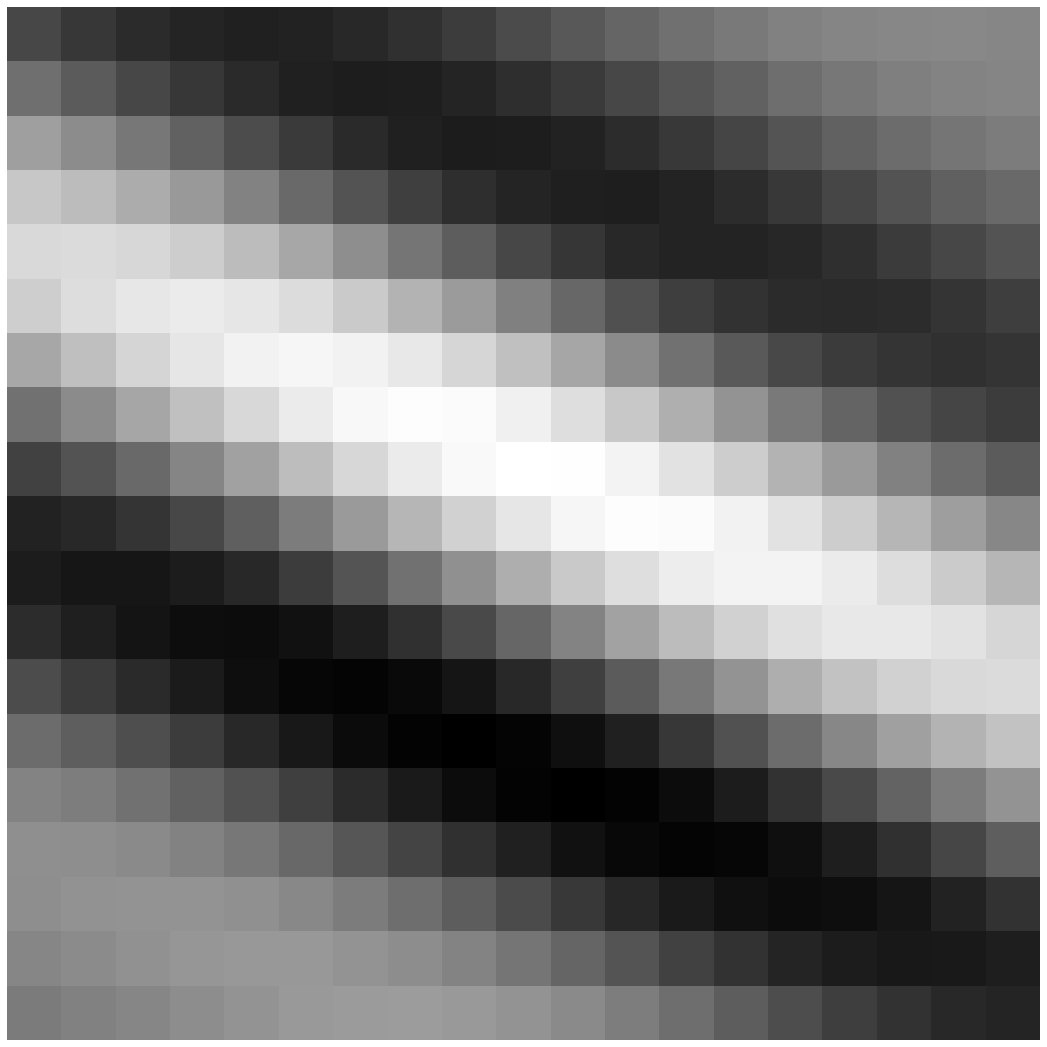

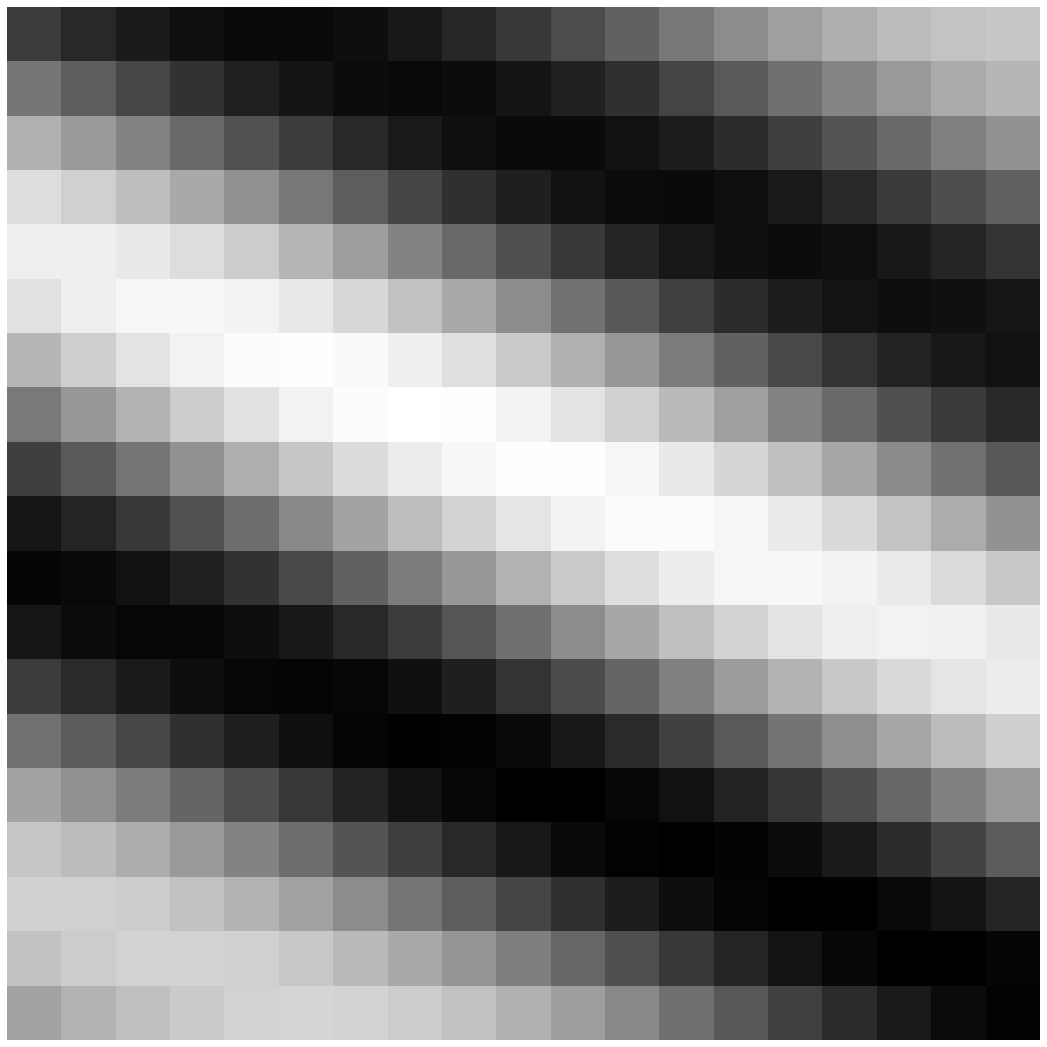

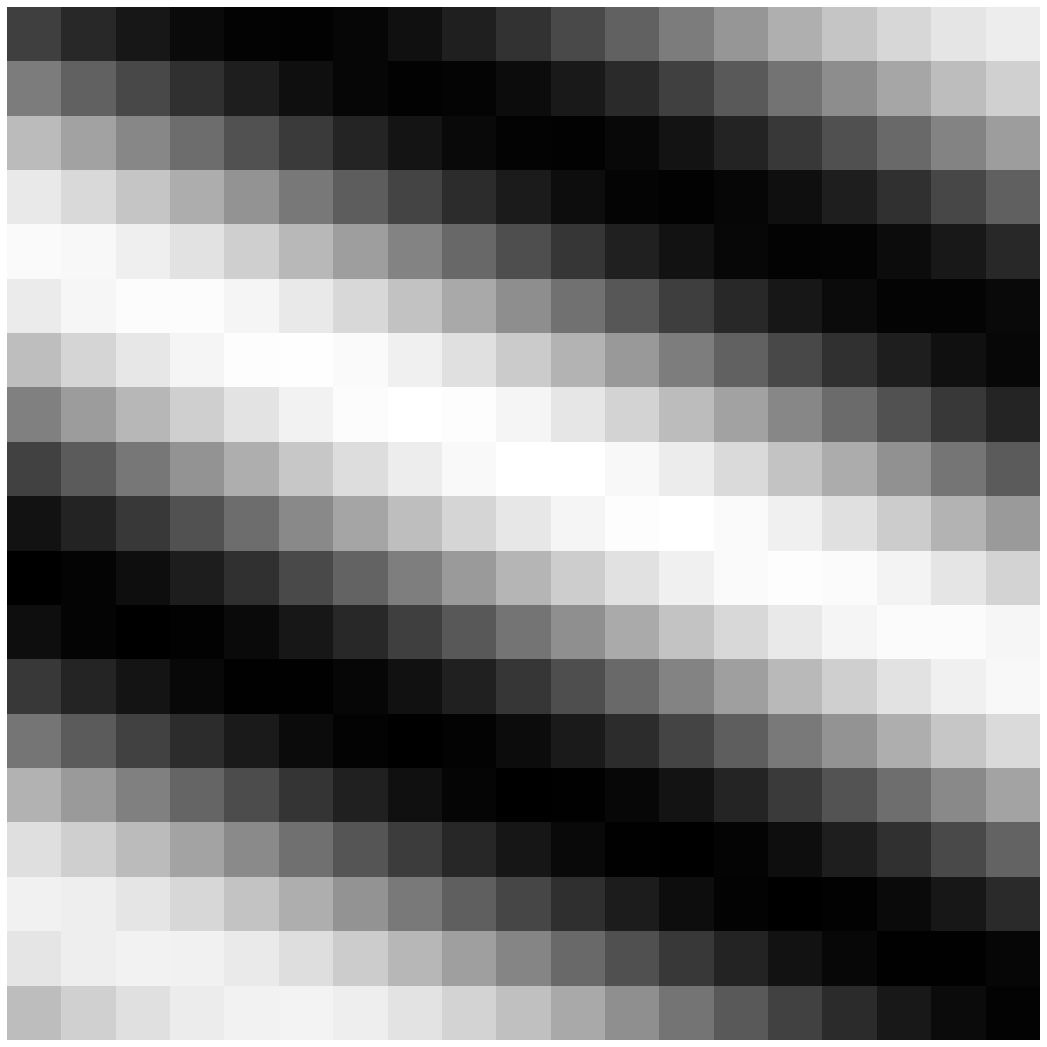

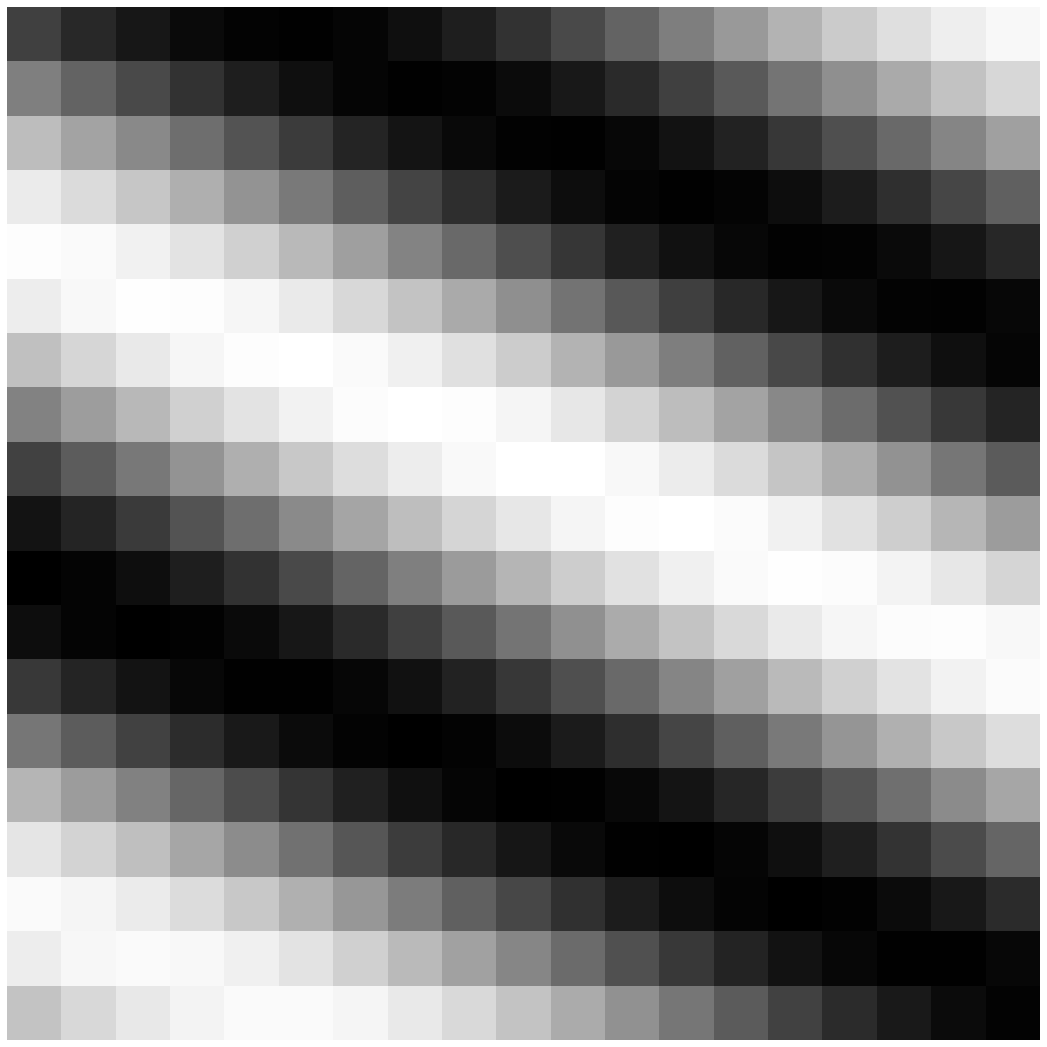

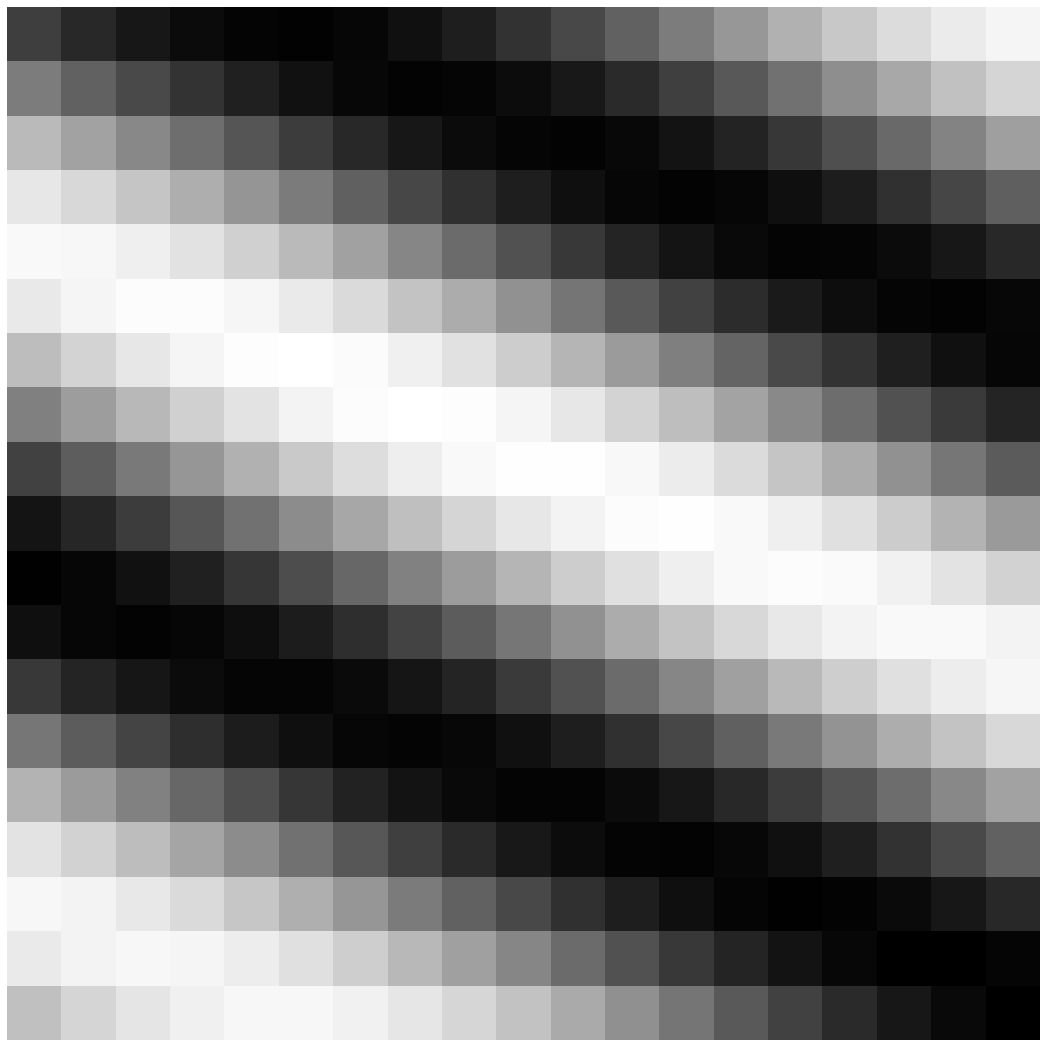

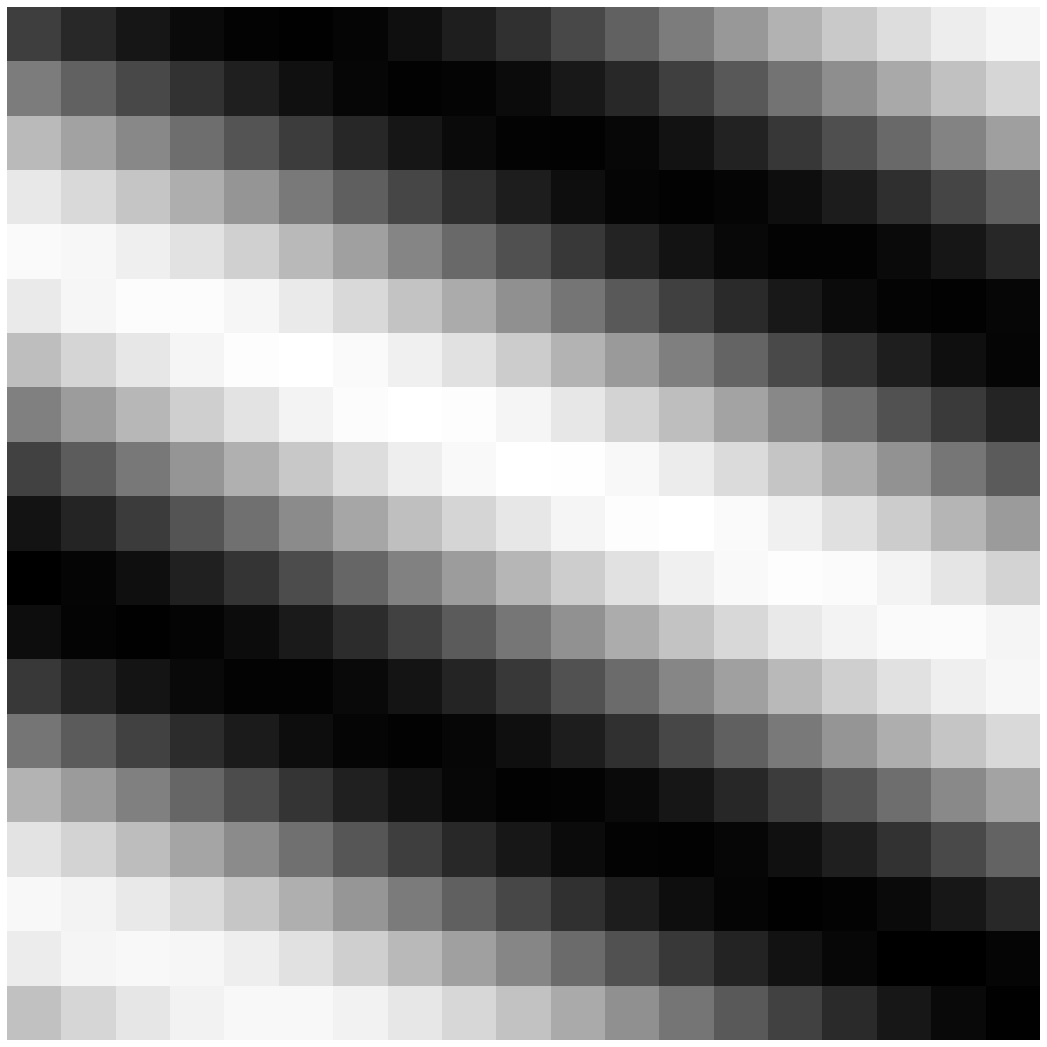

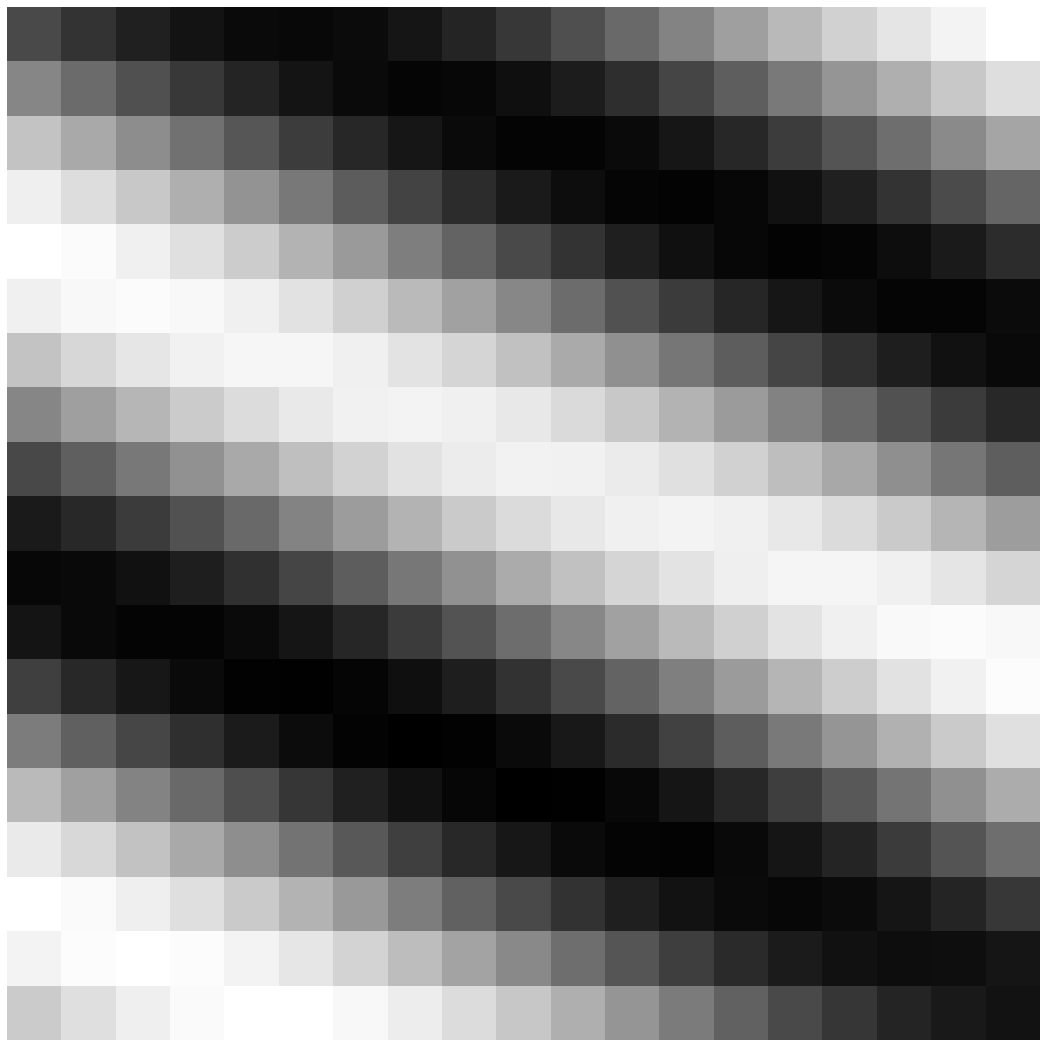

In [36]:
def myLoss(output, target):
#     print("size,size:",output.size(), target.size())
#     print("size,", ((1-2*target) * torch.log(output)).size())
#     return -torch.sum(target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)
    return -torch.sum((36885/34546)*target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = myLoss(output[2], target)
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader,count,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx,(data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += myLoss(output[2], target)
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            t = Variable(torch.Tensor([0.5]))
            pred = (output[2] > t) * 1
            pred = torch.reshape(pred, (len(target), 1))
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
             # Store wrongly predicted images
            if epoch == 9:
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                for i in range(len(wrong_idx)):
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    # Undo normalization
            #         sample = sample * 0.3081
            #         sample = sample + 0.1307
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    count = count+1
                    img.save('./wrong-gabor/batch{}_i{}_actual{}_pc{:.4f}.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item(),output[1][wrong_idx[i]]))
                    num = batch_idx * 64 + wrong_idx[i]
    #                 print(batch_idx,wrong_idx[i])
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-gabor/batch{}_i{}_actual{}_ori.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')
            
                
                    
                
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1])))
    

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=512, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--std', type=float, default=0, metavar='STD',
                        help='noise-std (default: 0)')
    parser.add_argument('--mean', type=float, default=0, metavar='MEAN',
                        help='noise-std (default: 0)')
#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])
    model = GaborConvPC(19, 1, 8, 10).to(device)
    # if torch.cuda.is_available():
    #     torch.set_default_tensor_type('torch.cuda.FloatTensor')
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    count = 0
    for param in model.parameters():
        print(type(param.data), param.size())
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader,count,epoch)
        # for param in model.parameters():
        #     print(param.size(), param.data)
        # print(model.state_dict())
        if epoch == 9:
            print(model.sigma1, model.theta1,model.Lambda1, model.psi1, model.gamma1)
            scale = 0
            ori = 1
            for i in range(len(model.filter_cos)):
#                 sample = model.filter_cos[i]
#                 print('ori' , sample)
#                 sample = sample * 255.
#                 print('first' , sample)
#                 sample = sample.byte()
#                 print('second' , sample)
#                 img = TF.to_pil_image(sample)
                figure, b = plt.subplots()
                figure.set_size_inches(19, 19)
                plt.axis('off')
                plt.imshow(model.filter_cos[i].detach().numpy()[0], cmap='gray')
                print(model.filter_cos[i].detach().numpy()[0])
#                 np.savetxt('train-coeff.txt', model.filter_cos[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
                if scale == 10:
                    scale = 1
                    ori = ori+1
                else:
                    scale = scale + 1
#                 img.save('./filter/{}_ori_{}scale_{}.png'.format('cos',ori,scale))
                plt.savefig("./filter-New/%s_ori_%dscale_%d.png" % ('cos',ori,scale), dpi=1,pad_inches=0.0,bbox_inches='tight')

            scale = 0
            ori = 1
            for i in range(len(model.filter_sin)):
#                 sample = model.filter_sin[i]
#                 sample = sample * 255.
#                 sample = sample.byte()
#                 img = TF.to_pil_image(sample)
                figure, b = plt.subplots()
                figure.set_size_inches(0.19, 0.19)
                plt.axis('off')
                plt.imshow(model.filter_sin[i].detach().numpy()[0], cmap='gray')
#                 np.savetxt('train-coeff.txt', model.filter_sin[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
                if scale == 10:
                    scale = 1
                    ori = ori + 1
                else:
                    scale = scale + 1
#                 img.save('./filter/{}_ori_{}scale_{}.png'.format('sin',ori,scale))
                plt.savefig("./filter-New/%s_ori_%dscale_%d.png" % ('sin',ori,scale), dpi=100,pad_inches=0.0,bbox_inches='tight')




    if (args.save_model):
        torch.save(model.state_dict(),"pretrain_gabor.pt")

if __name__ == '__main__':
    main()

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(3136, 1024)
        self.fc2 = nn.Linear(1024, 2)
        

#     def forward(self, x):
#         x = self.conv1(x)
#         x_conv1 = F.relu(x)
#         x_temp = self.conv2(x_conv1)
#         x_conv2 = F.relu(x_temp)
#         x_conv2 = F.max_pool2d(x_conv2, 2)
#         print(x_conv2.shape)
#         x_conv1 = torch.flatten(x_conv1, 1)
#         x_conv2 = torch.flatten(x_conv2, 1)
#         x_concat = torch.cat((x_conv1, x_conv2), 1)
#         x = self.fc1(x_concat)
#         x = F.relu(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output
    def forward(self, x_ori):
        x = self.conv1(x_ori)
        conv1 = F.relu(x)  #store conv1
        conv2 = self.conv2(conv1)
        conv2 = F.relu(conv2) #store conv2
        x = F.max_pool2d(conv2, 2)
#         x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output,x_ori,conv1,conv2


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        weight = torch.tensor([34546/(36885+34546),36885/(36885+34546)])
        loss = F.nll_loss(output[0], target, weight = weight)
        loss.backward()
        optimizer.step()
        if epoch == 3 and batch_idx == 10:
            for i in range(64):
                img_ori = output[1][i].numpy()
                real = target[i].detach().numpy()
                predict = output[0][i].detach().numpy()
                plt.imsave('./CNN/real{}_{}_a.png'.format(real,num),img_ori[0],cmap = 'gray')
                img_conv1 = output[2][i].detach().numpy()
                for j in range(len(img_conv1)):
                    plt.imsave('./CNN/real{}_{}_conv1_{}.png'.format(real, num, j),img_conv1[0],cmap = 'gray')
                img_conv2 = output[3][i].detach().numpy()
                for k in range(len(img_conv2)):
                    plt.imsave('./CNN/real{}_{}_conv2_{}.png'.format(real,num,k),img_conv2[0],cmap = 'gray')
                num = num+1
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

            if args.dry_run:
                break
                


def test(model, device, test_loader,count,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output[0], target, reduction='sum').item()  # sum up batch loss
            pred = output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
            
            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]
            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
        #         sample = sample * 0.3081
        #         sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                count = count+1
                img.save('./wrong/epoch{}_batch{}_idx{}_actual{}.png'.format(
                epoch,batch_idx,wrong_idx[i], actual_pred.item()))
                num = batch_idx * 64 + wrong_idx[i]
                img_ori = origin_dataset[num][0].numpy()
                plt.imsave('./wrong/epoch{}_batch{}_idx{}_actual{}_ori.png'.format(
                epoch,batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')

    test_loss /= len(test_loader.dataset)
    precision = result[1][1]/(result[1][1]+result[0][1])
    recall = result[0][0]/(result[0][0]+result[1][0])
    f1score = 2*(precision*recall)/(precision+recall)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), f1 score: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),f1score))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    count = 0
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, count, epoch)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/71432 (0%)]	Loss: 0.686289
Train Epoch: 1 [6400/71432 (9%)]	Loss: 0.584539
Train Epoch: 1 [12800/71432 (18%)]	Loss: 0.474190
Train Epoch: 1 [19200/71432 (27%)]	Loss: 0.402076
Train Epoch: 1 [25600/71432 (36%)]	Loss: 0.370735
Train Epoch: 1 [32000/71432 (45%)]	Loss: 0.283491
Train Epoch: 1 [38400/71432 (54%)]	Loss: 0.276498
Train Epoch: 1 [44800/71432 (63%)]	Loss: 0.240855
Train Epoch: 1 [51200/71432 (72%)]	Loss: 0.227262
Train Epoch: 1 [57600/71432 (81%)]	Loss: 0.276971
Train Epoch: 1 [64000/71432 (90%)]	Loss: 0.208923
Train Epoch: 1 [70400/71432 (98%)]	Loss: 0.153050

Test set: Average loss: 0.2378, Accuracy: 7417/8088 (92%), Positive accuracy: 3994/4089 (98%), Negative accuracy: 3423/3999 (86%), f1 score: 0.9208

Train Epoch: 2 [0/71432 (0%)]	Loss: 0.306779
Train Epoch: 2 [6400/71432 (9%)]	Loss: 0.264262
Train Epoch: 2 [12800/71432 (18%)]	Loss: 0.205650
Train Epoch: 2 [19200/71432 (27%)]	Loss: 0.160425
Train Epoch: 2 [25600/71432 (36%)]	Loss: 0.156365
Train Epoch: 2

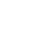

In [26]:
figure, b = plt.subplots()
figure.set_size_inches(0.4, 0.4)
plt.axis('off')
plt.savefig("test.png" , dpi=100,pad_inches=0.0,bbox_inches='tight')

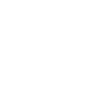

In [28]:
figure, b = plt.subplots()
figure.set_size_inches(1.7, 1.7)
plt.axis('off')
plt.savefig("new.png" , dpi=100,pad_inches=0.0,bbox_inches='tight')
plt.imshow(1-out, cmap='gray')

In [33]:
a = np.array([3,2])
np.savetxt('train-coeff.txt', a, delimiter=',',fmt='%1.2f')